# Przetwarzanie danych

In [1]:
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min
from sktime.datasets import load_basic_motions, load_arrow_head
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
import math
import sys
import mplcursors

#%matplotlib


### Parametry startowe programu

In [2]:
chunk_length_train = 200
chunk_length_test = 200
std_div = 300
n_clusters = 6
dim = 6
injection = 1.0
m = 2
g_error = 0.05

## Dane

In [3]:
%cd ..

D:\FuzzyC\FuzzyClusteringAlgorithms


### Pobieranie danych z biblioteki sktime

In [4]:
# load an example time series panel in numpy mtype Numpy 2D
X_train, y_train = load_basic_motions(split="train", return_type="numpy2D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy2D")

In [5]:
# load an example time series panel in numpy mtype Numpy 3D
X_train, y_train = load_basic_motions(split="train", return_type="numpy3D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy3D")

### Importowanie danych z dysku

In [6]:
from libraries.load import load_dataset_to_dataframe

filepath_train = './datasets/BasicMotions/BasicMotions_TRAIN.arff'
filepath_test = './datasets/BasicMotions/BasicMotions_TEST.arff'

df_train = load_dataset_to_dataframe(filepath_train)
df_test = load_dataset_to_dataframe(filepath_test)

In [7]:
from libraries.segmentation import stack_time_series, stack_time_series_randomly

stacked_train, _ , y_train = stack_time_series_randomly(df_train)
stacked_test, _ , y_test = stack_time_series_randomly(df_test)
#stacked_train, y_train = stack_time_series(df_train)
#stacked_test, y_test = stack_time_series(df_test)

In [8]:
def stack_columns(stacked_train):
    result = stacked_train.loc[0,0]
    
    for i in range(1,stacked_train.shape[0]):
        result = np.column_stack((result, stacked_train.loc[i,0]))
    return result
    
X_train = stack_columns(stacked_train)
X_test = stack_columns(stacked_test)

In [9]:
def extend_list(lista, n):
    wynik = []
    for element in lista:
        wynik.extend([element] * n)
    return wynik

y_test_extended = extend_list(y_test, 100)
y_train_extended = extend_list(y_train, 100)

In [10]:
def map_strings_to_ints(strings):
    # Utwórz słownik do mapowania stringów na inty
    string_to_int = {}
    current_int = 0
    
    # Wynikowa lista z intami
    result = []
    
    # Przejdź przez listę stringów
    for string in strings:
        # Jeśli string nie jest jeszcze w słowniku, dodaj go
        if string not in string_to_int:
            string_to_int[string] = current_int
            current_int += 1
        # Dodaj odpowiadający int do wynikowej listy
        result.append(string_to_int[string])
    
    return result

y_train = map_strings_to_ints(y_train_extended)
y_test = map_strings_to_ints(y_test_extended)

### Genrowanie syntetycznych danych

#### Generowanie danych syntetycznych sinusoidalnych

In [11]:
from libraries.generate_datasets import generate_multidimensional_sine_data, generate_dataset_blobs

# Parametry
num_dimensions = 6  # liczba wymiarów 
frequency = 1  # częstotliwość
amplitude = 1  # amplituda
phase = [0, np.pi/4, np.pi/2, 0, 0, 0]  # fazy początkowe dla każdego wymiaru
duration = 50  # czas trwania sygnału
sampling_rate = 100  # liczba próbek na jednostkę czasu
noise_std = 0.2  # odchylenie standardowe szumu
num_classes = n_clusters

In [12]:
# Generowanie danych
#t_train, X_train, y_train_extended_list = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)
#t_test, X_test, y_test_extended = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)

#### Generowanie plam

In [13]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_blobs(n=3000,c=dim,k=n_clusters,seed=42)

#### Generowanie prostych

In [14]:
from libraries.generate_datasets import generate_dataset_lines

# Parametry linii prostych
a_values = [2, 2, 2]  # Współczynniki a dla różnych składowych
b_values = [1, 10, 20]      # Współczynniki b dla różnych składowych
num_points = 5000           # Liczba punktów danych
std_dev = 0.1     # Odchylenie standardowe dla szumu

In [15]:
#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_lines(a_values, b_values, num_points = num_points, std_dev = std_dev, n_clusters = n_clusters)

## Processing danych

### Tasowanie danych

In [16]:
# Zwykłe tasowanie punktów.
def shuffle_data(X, y):
    
    # Sprawdzenie czy liczba wierszy w X odpowiada liczbie elementów w y
    assert X.shape[0] == len(y), "Liczba wierszy w X musi odpowiadać liczbie elementów w y"
    
    # Losowanie indeksów
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Przemieszanie X i y zgodnie z wylosowanymi indeksami
    X_shuffled = X[indices]
    y_shuffled = np.array(y)[indices].tolist()
    
    return X_shuffled, y_shuffled

def sort_by_class(X, y):
    # Sortowanie według etykiet w y
    sorted_indices = np.argsort(y)
    
    # Zastosowanie posortowanych indeksów do X i y
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    
    return X_sorted, y_sorted

# Dzieli dane dla każdej klasy na odcinki średniej długości mean  z odchyleniem standardowym std_var. Następnie tasuje tak stworzone segmenty.
def shuffle_dataset_with_chunk_sizes(X, y, mean, std_var, seed=42):
    # Ustawiamy seed
    np.random.seed(seed)
    
    # Liczba klas
    num_classes = np.unique(y).size
    y = np.array(y)
    # Listy do przechowywania chunków i etykiet
    X_chunks = []
    y_chunks = []
    chunk_sizes_list = []

    # Ustalanie rozmiaru chunków i mieszanie w obrębie każdej klasy
    start = 0
    for i in range(num_classes):
        # Wyodrębnij dane dla danej klasy
        class_indices = np.where(y == i)[0]
        class_size = len(class_indices)
        
        # Losowanie chunków
        chunk_sizes = []
        while sum(chunk_sizes) < class_size:
            chunk_size = int(np.abs(np.random.normal(mean, std_var)))
            if sum(chunk_sizes) + chunk_size > class_size:
                chunk_size = class_size - sum(chunk_sizes)
            chunk_sizes.append(chunk_size)
        
        # Dzielenie i mieszanie chunków
        class_X_chunks = np.array_split(X[class_indices], np.cumsum(chunk_sizes[:-1]))
        class_y_chunks = np.array_split(y[class_indices], np.cumsum(chunk_sizes[:-1]))
        
        X_chunks.extend(class_X_chunks)
        y_chunks.extend(class_y_chunks)
        chunk_sizes_list.extend(chunk_sizes)

    # Mieszanie w skali całego datasetu
    combined = list(zip(X_chunks, y_chunks, chunk_sizes_list))
    np.random.shuffle(combined)
    
    # Rozdzielenie pomieszanych chunków
    X_shuffled, y_shuffled, shuffled_chunk_sizes = zip(*combined)
    
    # Spłaszczenie listy chunków
    X_shuffled = np.concatenate(X_shuffled)
    y_shuffled = np.concatenate(y_shuffled)

    return X_shuffled, y_shuffled, list(shuffled_chunk_sizes)


In [17]:
# Dziele punkty na segmenty średniej weilkości chunk_length_train z odchyleniem standardowym std_div. Segmenty są jednej klasy
# Następnie tasuje w ten sposób utworzone segmenty


#chunk_train_sizes = [chunk_length_train for i in range(0,int(X_train.shape[0]/chunk_length_train))]
#chunk_test_sizes = [chunk_length_test for i in range(0,int(X_train.shape[0]/chunk_length_test))]

#X_train, y_train = shuffle_data(X_train, y_train)
#X_test, y_test = shuffle_data(X_test, y_test)

X_train, y_train, chunk_train_sizes = shuffle_dataset_with_chunk_sizes(X_train, y_train, chunk_length_train, std_div)
X_test, y_test, chunk_test_sizes = shuffle_dataset_with_chunk_sizes(X_test, y_test, chunk_length_test, std_div)

### Wizualizacja danych

Dane podzielone i potasowane we wcześniejszym kroku, pokolorowane ze względu na klase

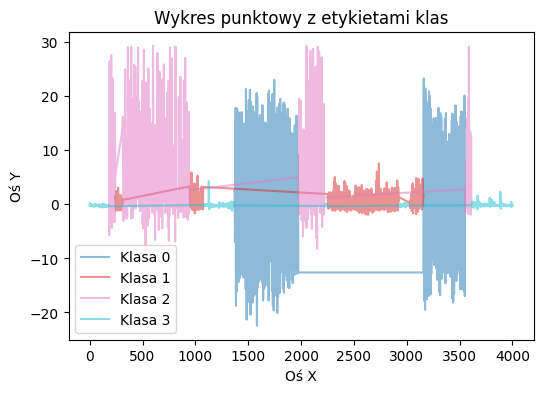

In [18]:
def show_labels_of_dataset(X, y):
  # Ustalamy unikalne etykiety
    unique_labels = np.unique(y)
    
    # Wybieramy kolory dla każdej klasy
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    # Tworzenie wykresu punktowego
    plt.figure(figsize=(6, 4))
    
    for i, label in enumerate(unique_labels):
        # Wybieranie punktów dla danej klasy
        ix = np.array(np.where(label == y)).reshape(-1)
        mask = (y == label)
        plt.plot(ix, X[mask, 0], color=colors[i], label=f'Klasa {label}', alpha=0.5)
    
    # Dodanie tytułu i etykiet osi
    plt.title('Wykres punktowy z etykietami klas')
    plt.xlabel('Oś X')
    plt.ylabel('Oś Y')
    
    # Dodanie legendy
    plt.legend()
    
    # Wyświetlenie wykresu
    plt.show()

show_labels_of_dataset(X_train, y_train)

In [19]:
# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot different data on each subplot
    axs[0, 0].plot(data[:,0])
    axs[0, 0].set_title('accelerometer X')

    axs[0, 1].plot(data[:,1])
    axs[0, 1].set_title('accelerometer Y')

    axs[0, 2].plot(data[:,2])
    axs[0, 2].set_title('accelerometer Z')

    axs[1, 0].plot(data[:,3])
    axs[1, 0].set_title('gyroscope X')

    axs[1, 1].plot(data[:,4])
    axs[1, 1].set_title('gyroscope Y')

    axs[1, 2].plot(data[:,5])
    axs[1, 2].set_title('gyroscope Z')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    c = data.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(c):
        # Plot different data on each subplot
        axs[int(i/3), i%3].plot(data[:,i])
        axs[int(i/3), i%3].set_title(f'param {i}')
        
    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

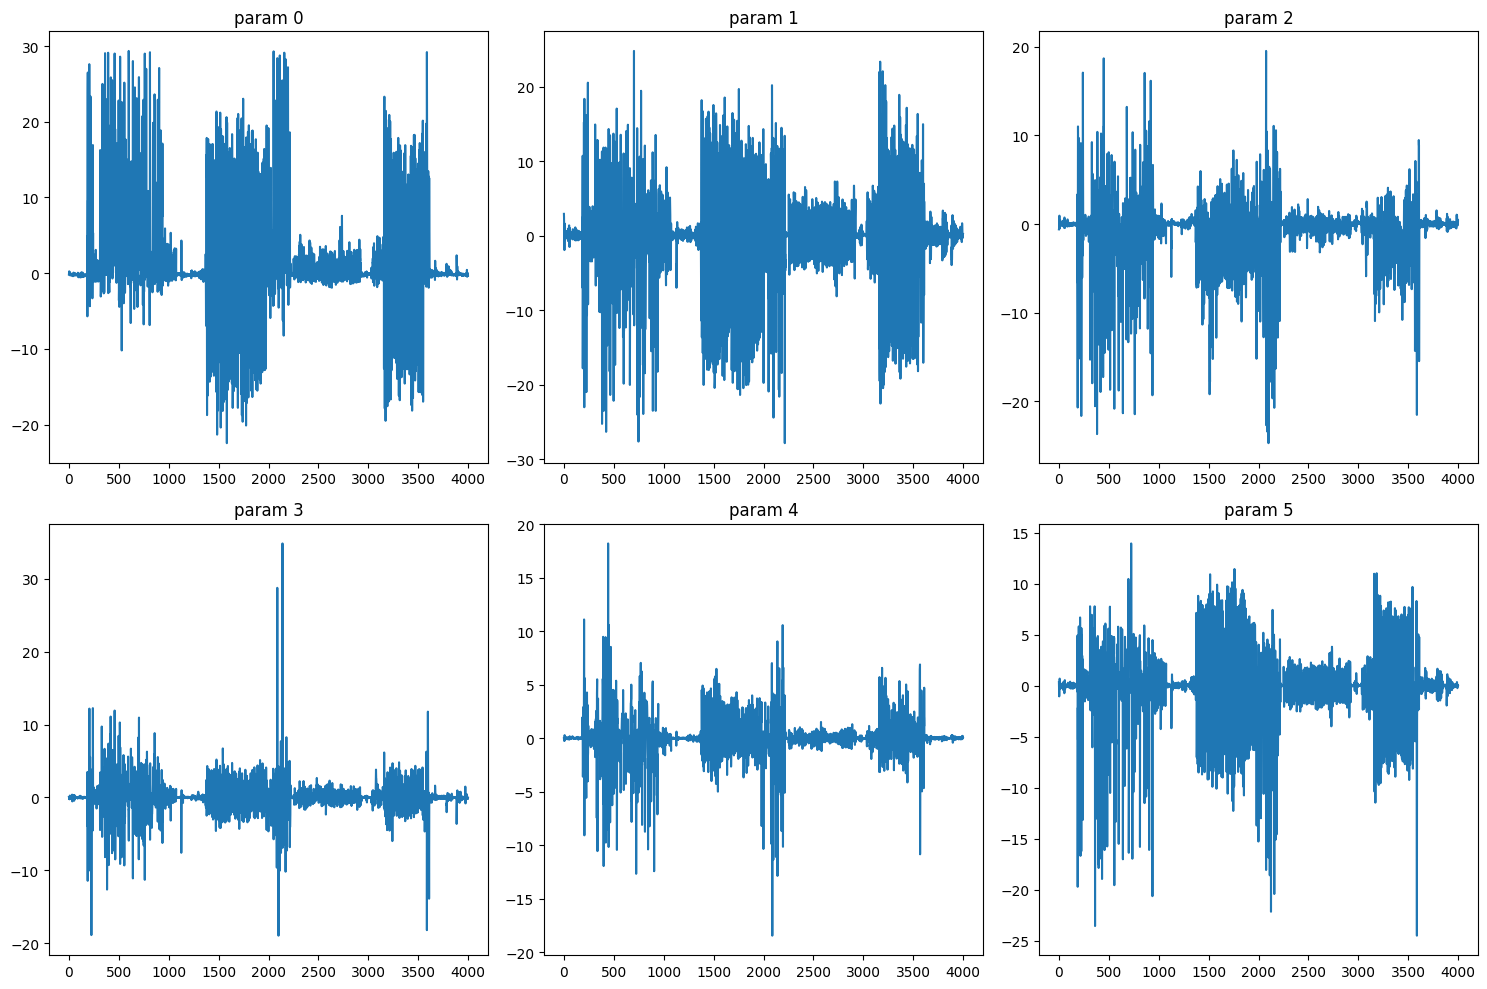

In [20]:
# Wizualizacja każdego wymiaru danych z osobna po potasowaniu.
visualise_loaded_data(X_train)

### Punkty inicjalizacyjne i macierze semi_supervised

In [21]:
# Dla każdej klasy znajdź punkt średni.
def average_by_class(X, y):
    # Unikalne klasy w y
    classes = np.unique(y)
    
    # Słownik do przechowywania średnich dla każdej klasy
    class_averages = {}
    
    for cls in classes:
        # Wybieramy indeksy odpowiadające danej klasie
        indices = np.where(y == cls)
        
        # Wybieramy punkty z X odpowiadające danej klasie
        class_points = X[indices]
        
        # Obliczamy średnią dla danej klasy
        class_avg = np.mean(class_points, axis=0)
        
        # Dodajemy średnią do słownika
        class_averages[cls] = class_avg
    
    return class_averages


In [22]:
# Tworzy clustry na podstawie średnich punktów dla każdej klasy. Dla każdej klasy generuje kilka punktów z lekkim odchyleniem od średniego punktu dla danej klasy.
# Punkty wygenerowane sumują się do n_clusters.
def generate_clusters_proportional(average_points, n_clusters, deviation=0.1):
    """
    average_points: słownik zawierający średnie punkty dla każdej klasy
    n_clusters: łączna liczba punktów do wygenerowania dla wszystkich klas
    deviation: maksymalne odchylenie od średniej, domyślnie 0.1 (10%)
    
    Zwraca: słownik zawierający generowane punkty dla każdej klasy
    """
    # Liczba klas
    num_classes = len(average_points)
    
    # Początkowy przydział punktów do klas (podział równomierny)
    points_per_class = [n_clusters // num_classes] * num_classes
    
    # Jeśli n_clusters nie jest podzielne przez num_classes, rozdysponuj pozostałe punkty
    remainder = n_clusters % num_classes
    for i in range(remainder):
        points_per_class[i] += 1
    
    # Generowanie punktów dla każdej klasy
    generated_points = []

    # Dla każdego centroida przyporządkowana informacja o klasie
    class_of_centroid = []

    # Dla każdej klasy zwraca listę centroidów (jeden bądź wiele punktów)
    clusters_for_each_class = {}
    indicies_start = 0
    
    for i, (cls, avg_point) in enumerate(average_points.items()):
        # Liczba punktów do wygenerowania dla danej klasy
        points_count = points_per_class[i]
        
        # Tworzymy losowe odchylenie dla każdego wymiaru
        deviations = np.random.randn(points_count, avg_point.size) * deviation
        
        # Generujemy punkty z lekkim odchyleniem od średniej
        points = avg_point + deviations

        clusters_for_each_class[cls] = range(indicies_start,indicies_start + points_per_class[i])
        
        indicies_start += points_per_class[i]
        # Przechowujemy wygenerowane punkty w słowniku
        for point in points:
            generated_points.append(point)
            class_of_centroid.append(cls)
    
    return np.array(generated_points), np.array(class_of_centroid), clusters_for_each_class


In [23]:
# Metoda tworząca z wektora labelów tablicę labelów potrzebną do implementacji algorytmu SSFCM.
def label_vector_to_semi_supervised_matrix(y, n_clusters, clusters_for_each_class,  procent_of_data=0.5):
    array = np.zeros((len(y), n_clusters))

    for i, label in enumerate(y):
        
        if(i >= len(y)*procent_of_data):
            break

        injection_power = 1 / len(clusters_for_each_class[label]) - 0.05
        for element in clusters_for_each_class[label]:
            array[i, element] = injection_power
            
    return array

# Tworzy macierz do uczenia nadzorowanego. Przydziela kilka klastrów do danej klasy.
# Injection to procent danych jakie labelujemy
# Zwraca punkty stworzone przez funkcje generate_clusters_proportional.
def create_semi_supervised_matrix(X, y, n_clusters, injection=injection):

    average_classes = average_by_class(X, y)

    init_centroids, class_of_centroid, clusters_for_each_class = generate_clusters_proportional(average_classes, n_clusters, deviation=0.1)

    y_matrix = label_vector_to_semi_supervised_matrix(y_train, n_clusters, clusters_for_each_class, injection)

    return y_matrix, init_centroids, clusters_for_each_class

def upload_semi_supervised_matrix(y, new_cluster_id, clusters_for_each_class, n_clusters):

    idx = len(clusters_for_each_class)
    
    for i in range(len(clusters_for_each_class)):
        k = clusters_for_each_class[i].stop 
        n = clusters_for_each_class[i].start
        if new_cluster_id in clusters_for_each_class[i]:
            clusters_for_each_class[i] = range(n, k+1)
            idx = i
        if i > idx:
            clusters_for_each_class[i] = range(n+1,k+1)
    
    y_matrix = label_vector_to_semi_supervised_matrix(y, n_clusters, clusters_for_each_class, injection)
    
    return y_matrix, clusters_for_each_class



In [24]:
# Inicjalizacja centroidów oraz stworzenie y_matrix_label dla odmian algorytmu semi-supervised.
y_train_matrix, init_centroids, clusters_for_each_class = create_semi_supervised_matrix(X_train, y_train, n_clusters)

### Tworzenie chunków

In [25]:
def create_chunks(chunk_sizes, matrix):
    # Rozmiary kolejnych chunków, mogą mieć różne wielkości. Następnie ze względu na te liczby dzielone są chunki
    chunks = []
    start = 0
    for size in chunk_sizes:
        end = start + size
        chunks.append(matrix[start:end])
        start = end

    return chunks

def create_dataset_chunks(chunk_sizes, X, y, y_matrix=None):
    # Rozmiary kolejnych chunków, mogą mieć różne wielkości. Następnie ze względu na te liczby dzielone są chunki
    chunks = create_chunks(chunk_sizes, X)
    chunks_y = create_chunks(chunk_sizes, y)
    if y_matrix is not None:
        chunks_y_matrix  = create_chunks(chunk_sizes, y_matrix)
    else:
        chunks_y_matrix = None

    return chunks, chunks_y, chunks_y_matrix

In [26]:
# Dzielimy dane oraz labele na chunki długości elementów listy chunk_train_sizes (ew. test)
chunks, chunks_y, chunks_y_matrix = create_dataset_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
chunks_test, chunks_test_y, _ = create_dataset_chunks(chunk_test_sizes, X_test, y_test)

# Metody klastrujące biblioteczne

### Fuzzy cmeans

In [27]:
# tutaj gotowe algorytmu fcm i odmiany


# Algorytm IFCM

Importowanie funkcji bibliotecznych. Implementacja własna

In [28]:
from libraries.IFCM import incremental_fuzzy_cmeans_predict
from libraries.IFCM import incremental_fuzzy_cmeans

# Algorytm ISSFCM

Importowanie funkcji bibliotecznych. Implementacja własna

In [29]:
from libraries.ISSFCM import incremental_semi_supervised_fuzzy_cmeans_predict
from libraries.ISSFCM import incremental_semi_supervised_fuzzy_cmeans

# Algorytm DISSFCM


In [30]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist
import random

##### Normalizacja

In [31]:
def normalize_columns(columns):
    # broadcast sum over columns
    normalized_columns = columns/np.sum(columns, axis=0, keepdims=1)

    return normalized_columns

def reflect_labels(y):
    result = 1 - np.sum(y, axis=0, keepdims=1)
    
    return result

def normalize_power_columns(x, exponent):
    assert np.all(x >= 0.0)

    x = x.astype(np.float64)

    # values in range [0, 1]
    x = x/np.max(x, axis=0, keepdims=True)

    # values in range [eps, 1]
    x = np.fmax(x, np.finfo(x.dtype).eps)

    if exponent < 0:
        # values in range [1, 1/eps]
        x /= np.min(x, axis=0, keepdims=True)

        # values in range [1, (1/eps)**exponent] where exponent < 0
        # this line might trigger an underflow warning
        # if (1/eps)**exponent becomes zero, but that's ok
        x = x**exponent
    else:
        # values in range [eps**exponent, 1] where exponent >= 0
        x = x**exponent

    result = normalize_columns(x)

    return result

##### Trening

In [32]:
def choose_random_rows(array, c):
    if c > array.shape[0]:
        raise ValueError("Liczba wierszy do wybrania jest większa niż liczba dostępnych wierszy w tablicy.")
    
    # Wybór c unikalnych indeksów wierszy
    row_indices = np.random.choice(array.shape[0], c, replace=False)
    
    # Wybranie wierszy o wybranych indeksach
    selected_rows = array[row_indices]
    
    return selected_rows
    
def initialize_c_first_centroids(data, c):
    # Inicjalizuje biorąc pierwsze k punktów jako centroidy
    selected_rows = choose_random_rows(data, c)
    return selected_rows

def create_labels(data, y, centroids, metric, m):
    # Tablica dystansów
    dist = _distance(data, centroids, metric)

    # Tablica prawdopodobieństw z zwykłego algorytmu FCM
    fuzzy_labels = normalize_power_columns(dist, - 2. / (m - 1))

    # 1 - sum j = 1:C y(j)
    y_ = reflect_labels(y)
    y_ = np.tile(y_, (fuzzy_labels.shape[0], 1))

    fuzzy_labels = y + np.multiply(fuzzy_labels, y_)
    
    return fuzzy_labels

def _fp_coeff(u):
    # Mierzy rozmytość wyliczonych klastrów
    n = u.shape[1]
    
    return np.trace(u.dot(u.T)) / float(n)

def _distance(data, centroids, metric='euclidean'):
    # Oblicza dystans dla każdego punktu do każdego centroidu
    dist = cdist(data, centroids, metric=metric).T
    
    return np.fmax(dist, np.finfo(np.float64).eps)

def semi_supervised_cmeans0(data, y, centroids, metric, c, m):
    # Obliczanie tablicy dystansów
    dist = _distance(data, centroids, metric)

    # Obliczanie fuzzy_labels na podstawie centroidów i tablicy dystansów
    fuzzy_labels = create_labels(data, y, centroids, metric, m)

    fuzzy_labels_supervised = abs(fuzzy_labels - y)
    
    fuzzy_labels_supervised_m = fuzzy_labels_supervised ** m
    
    # Aktualizowanie centroidów
    centroids = fuzzy_labels_supervised_m.dot(data) / np.atleast_2d(fuzzy_labels_supervised_m.sum(axis=1)).T

    jm = (fuzzy_labels_supervised_m * dist ** 2).sum()
    
    return centroids, fuzzy_labels, jm, dist


def dynamic_incremental_semi_supervised_fuzzy_cmeans(data, y, c, m, error, maxiter, metric = 'euclidean', init_centroid=None):
    # data jeste postaci (n_samples, k_features)

    # Struktura do której bedziemy zbierać informacje z każdej iteracji
    statistics = Multilist(['fpc'])
    
    centroids = init_centroid
    
    if(init_centroid is None):
        centroids = initialize_c_first_centroids(data, c)
        #centroids = initialize_average_c_centroids(data, y_train, k)
    
    fuzzy_labels = create_labels(data,y = y.T,centroids = centroids, metric = metric,m = m)

    # Initialize loop parameters
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        fuzzy_labels_copy = fuzzy_labels.copy()
        centroids_copy = centroids.copy()

        [centroids, fuzzy_labels, Jjm, dist] = semi_supervised_cmeans0(data, y.T, centroids_copy, metric, c, m)

        fpc = _fp_coeff(fuzzy_labels)
        statistics.add_elements([fpc])
        p += 1
        
        # Stopping rule
        if np.linalg.norm(fuzzy_labels - fuzzy_labels_copy) < error and p > 1:
            break
        if np.linalg.norm(centroids_copy - centroids) < error and p > 1:
            break
            
    # Final calculations
    error = np.linalg.norm(fuzzy_labels - fuzzy_labels_copy)
    fpc = _fp_coeff(fuzzy_labels)

    return centroids, fuzzy_labels, dist, p, fpc, statistics


##### Predykcja

In [33]:
def dynamic_incremental_semi_supervised_fuzzy_cmeans_predict(test_data, cntr_trained, m, error, maxiter, metric='euclidean', init=None, seed=None):
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = semi_supervised_cmeans_predict0(test_data, cntr_trained, u2, c, m, metric)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc 
    
def semi_supervised_cmeans_predict0(test_data, cntr, u_old, c, m, metric):

    # Normalizing, then eliminating any potential zero values.
    u_old = normalize_columns(u_old)
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return u, jm, d

##### Funkcja split

In [34]:
# Liczy funkcje kosztów, dla danej iteracji pętli
def split_centroids_cost_function(v, data, z, m=2):
    # Inicjalizacja funkji kosztów
    J = 0

    for k in range(2):
        J += (v[:,k] ** m).dot(np.linalg.norm(data - z[k,:], axis=1)**m)

    return J

# Inicjalizacja tablicy przyporządkowań
def init_v(data, fuzzy_labels_spliting):
    # Inicjalizacja tablicy
    v = np.zeros((data.shape[0], 2))

    for i in range(data.shape[0]):
        for k in range(2):
            # Chcemy aby nowa tablica sumowała się po wierszach do wiersza tablicy przyporządkowań która modyfikujemy.
            v[i,k] = fuzzy_labels_spliting[i] / 2
    return v

# Liczymy nowo otrzymane centroidy)
def calculate_z(data, v_m):
    # Mnożenie pierwszej kolumny matrix1 przez matrix2 i sumowanie
    z1 = np.sum(v_m[:, 0][:, np.newaxis] * data, axis=0) / np.atleast_2d(v_m[:, 0].sum(axis=0)).T

    # Mnożenie drugiej kolumny matrix1 przez matrix2 i sumowanie
    z2= np.sum(v_m[:, 1][:, np.newaxis] * data, axis=0) / np.atleast_2d(v_m[:, 1].sum(axis=0)).T
    
    z = np.vstack((z1,z2))

    return z

def exchange_rows(array, row_index, new_rows):
    # Tworzenie nowej tablicy z zastąpionym wierszem
    new_array = np.vstack((array[:row_index], new_rows, array[row_index+1:]))

    return new_array

def exchange_columns(array, col_index, new_cols):
    # Tworzenie nowej tablicy z zastąpioną kolumną
    new_array = np.hstack((array[:, :col_index], new_cols, array[:, col_index+1:]))

    return new_array

def init_z_centroids(centroids, spliting_cluster, data):
    # Nowe centroidy
    z = np.random.rand(2, data.shape[1]) * 10

    # Parametry rozkładu normalnego
    mean = 0       # Średnia
    sigma = 20    # Odchylenie standardowe

    # Generowanie szumu z rozkładu normalnego
    noise1 = np.random.normal(mean, sigma, data.shape[1])
    noise2 = np.random.normal(mean, sigma, data.shape[1])

    z[0,:] = centroids[spliting_cluster,:] + noise1
    z[1,:] = centroids[spliting_cluster,:] + noise2
    
    return z

def split_centroids(data, fuzzy_labels, centroids, spliting_cluster, m=2, metric='euclidean', maxiter=100, error=0.05):

    # Transpozycja fuzzy_labels aby posiadało rozmiar (n, n_clusters)
    fuzzy_labels = fuzzy_labels.T

    # Wyciągamy tylko wiersz który podzielimy.
    fuzzy_labels_spliting =  fuzzy_labels[:, spliting_cluster]

    # Nowe centroidy
    z = init_z_centroids(centroids, spliting_cluster, data)

    # Nowa tablica z prawdopodobieństwem przyporządkowanym do elementów.
    v = init_v(data, fuzzy_labels_spliting)

    # Funkcja kosztu
    J = split_centroids_cost_function(v, data, z, m)
    
    J_prev = 0
    
    i = 0
    while (abs(J - J_prev) > error and i < maxiter):
        
        dist = _distance(data, z, metric)

        # Tablica przyporządkowań
        v = (normalize_power_columns(dist, -m) * (fuzzy_labels_spliting)).T

        v_m = v ** m

        # Wyznaczamy centroidy
        z = calculate_z(data, v_m)

        i += 1
        J_prev = J
        J = split_centroids_cost_function(v, data, z, m)

    # Zamieniamy stary centroid dwoma nowymi
    new_centroids = exchange_rows(centroids, spliting_cluster, z)

    # Zamieniamy tablicę przyporządkowań nową, zaktualizowną.
    new_fuzzy_labels = exchange_columns(fuzzy_labels, spliting_cluster, v)

    return new_centroids, new_fuzzy_labels.T, z

##### Funkcja reconstruction error

In [35]:
# Funkcja liczy błąd rekonstrukcji dla każdego clustra, następnie zwraca nawiększą wartość
def reconstruction_error(data, fuzzy_labels, centroids, m=2):

    fuzzy_labels = fuzzy_labels.T

    # Przynależność do clustró dla punktów z data
    cluster_membership = np.argmax(fuzzy_labels.T, axis=0)
    
    n_clusters = fuzzy_labels.shape[1]
    
    # Obliczanie współczynika q, suma kwadratów danych.
    q = (np.sum(data ** m)) ** (1/m)

    fuzzy_labels_m = fuzzy_labels ** m
    
    # Tablica do przechowywania wyników x_j
    normalized_data = np.zeros(data.shape)
    
    # Liczba wierszy w macierzy u
    N = fuzzy_labels.shape[0]
    
    # Obliczanie x_j dla każdego j
    for j in range(N):
        numerator = np.sum(fuzzy_labels_m[j, :][:, np.newaxis] * centroids, axis=0)  # Licznik sumy
        denominator = np.sum(fuzzy_labels_m[j, :])  # Mianownik sumy
        normalized_data[j,:] = numerator / denominator  
  
    V = np.zeros(n_clusters)

    for i in range(n_clusters):
        label = cluster_membership == i
        V[i] =  np.sum(np.linalg.norm(data[label] - normalized_data[label], axis=1)**m) / q

    # Zwracamy nawiększą wartość i indeks clustra
    return np.max(V), np.argmax(V), V

# Metody wizualizacji danych

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import random
from tqdm import tqdm

### Wizualizacja danych ze zredukowanymi wymiarami

In [37]:
def simple_plot(X, cntr, cluster_labels, name):
    n_clusters = cntr.shape[0]
    if X.shape[1] > 2:
        # Jeżeli dane mają więcej niż 2 wymiary, to można redukować ich wymiarowość. 
        # Zwracamy zatem True, aby użyć algorytmu redukującego wymiarowość
        return True
    
    elif X.shape[1] == 2:
        # Tworzymy wykres dla danych 2 wymiarowych
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(X[cluster_labels == i, 0], X[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering 2D ' + name)
        plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', s=200, c='black', label='Cluster Centers')
    
    elif X.shape[1] == 1:
        #Losujemy liste kolorow
        colors_list = list(plt.cm.tab10.colors)
        
        # Tworzymy wykres dla danych jednowymiarowych
        plt.figure(figsize=(10, 8))
        plt.title('Fuzzy C-Means Clustering 1D ' + name)
        for i in range(n_clusters):       
            plt.plot(np.array(np.where(cluster_labels == i)).reshape(-1), X[cluster_labels == i, 0], label=f'Cluster {i+1}', color=colors_list[i], marker='o')
    else:
        print('Zły wymiar danych, plot function')
        return False
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    return False


def plot_pca(X, cntr, validation_y, cluster_to_class, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    #data_type = simple_plot(X, cntr, cluster_labels, 'pca')

    n_clusters = cntr.shape[0]
    print(n_clusters)
    # Redukcja wymiarowości za pomocą PCA do 2 wymiarów
    if True:
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(X)
        description = []
        scatter_plots = []

        # Redukcja wymiarowości centrów klastrów
        cntr_pca = pca.transform(cntr)
        fig, ax = plt.subplots(figsize=(10, 8))


        # for i in range(n_clusters):
        #     plt.scatter(data_pca[cluster_labels == i, 0], data_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')
        colors = plt.cm.get_cmap('viridis', 4)
        #print("fuzzy_labels, ", fuzzy_labels)

        # for i in range(validation_y.shape[0]):
        #     validation_y[i] = cluster_to_class[validation_y[i]]

        #print("klasy, ", validation_y)
        # Rysowanie danych dla każdej klasy osobno
        for class_idx in range(4):
            #print("---------------klasa-----------", class_idx)
            class_mask = validation_y == class_idx
            for i in range(fuzzy_labels.shape[1]):
                if class_mask[i]:  # Sprawdzamy, czy maska dla tego indeksu jest prawdziwa
                    #for value in fuzzy_labels_val[:, i]:
                    description.append(fuzzy_labels[:, i])
                    #print("labele: ",fuzzy_labels[:, i] )
                    #print("klasa: ", cluster_to_class[np.argmax(fuzzy_labels[:, i])])

    
            scatter = ax.scatter(data_pca[class_mask, 0], data_pca[class_mask, 1], 
                       color=colors(class_idx), label=f'Klasa {class_idx}')
            scatter_plots.append(scatter)
    
        

        if cluster_to_class is not None:
            for idx, (centroid, class_idx) in enumerate(zip(cntr_pca, cluster_to_class)):
                ax.scatter(centroid[0], centroid[1], 
                           color=colors(class_idx), edgecolor='black', 
                           marker='o', s=200, linewidths=2, label=f'Centroid {idx} (Klasa {class_idx})')
        def hover_label(sel):
            text = ''
            #for i in description[sel.index]:
            #print(description[sel.index])
            k = 0
            for i in description[sel.index]:
                text += (f"u do centorida {k} wynosi: {i:.3f}\n")
                k += 1
            sel.annotation.set_text(text)
           
        mplcursors.cursor(scatter_plots, hover=True).connect("add", hover_label)
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering (PCA Reduced Data)')
        ax.scatter(cntr_pca[:, 0], cntr_pca[:, 1], marker='x', s=200, c='black', label='PCA Cluster Centers')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()

def plot_heatmap(data, centroids, fuzzy_labels):   
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'heatmap')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        combined_labels = np.hstack([cluster_labels, [-1] * len(centroids)])  # -1 dla centroidów
    
        plt.figure(figsize=(12, 8))
        sns.heatmap(combined_data, cmap='coolwarm', xticklabels=False, yticklabels=False)
        plt.title('Heatmap of Data and Centroids')
        plt.show()

def plot_tsne(data, centroids, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'tsne')
    if(data_type):
        combined_data = np.vstack([data, centroids])
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(tsne_results[:-len(centroids), 0], tsne_results[:-len(centroids), 1], c=cluster_labels, cmap='viridis', label='Data')
        plt.scatter(tsne_results[-len(centroids):, 0], tsne_results[-len(centroids):, 1], c='black', label='Centroids', marker='x', s=200)
        plt.legend()
        plt.colorbar()
        plt.title('t-SNE Plot of Data and Centroids')
        plt.show()


def plot_mds(data, centroids, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'mds')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        mds = MDS(n_components=2, random_state=42)
        mds_results = mds.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(mds_results[:-len(centroids), 0], mds_results[:-len(centroids), 1], c=cluster_labels, cmap='viridis', label='Data')
        plt.scatter(mds_results[-len(centroids):, 0], mds_results[-len(centroids):, 1], c='black', label='Centroids', marker='x', s=200)
        plt.legend()
        plt.colorbar()
        plt.title('MDS Plot of Data and Centroids')
        plt.show()

    

### Wizualizacja zestawów danych

In [38]:
def plot_centroids(centroids):
    # Przeprowadzenie PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(centroids)

    colors_list = list(plt.cm.tab10.colors)
    
    # Wykres PCA
    plt.figure(figsize=(10, 5))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c = colors_list[:data_pca.shape[0]], cmap='viridis')
    plt.colorbar(label='Czas')
    plt.xlabel('Główna składowa 1')
    plt.ylabel('Główna składowa 2')
    plt.title('Wizualizacja centroidów startowych PCA')
    plt.grid(True)
    plt.show()

def plot_two(data, centroids, cluster_labels, plot1, plot2):
    plot1(data, cntr, cluster_labels)
    plot2(data, cntr, cluster_labels)

def visualize_all(data, centroids, fuzzy_labels):
    # Wizualizacja dla pierwszej iteracji
    print('PCA plot')
    plot_pca(data, centroids, fuzzy_labels)
    print('heatmap plot')
    plot_heatmap(data, centroids, fuzzy_labels)
    print('TSNE plot')
    plot_tsne(data, centroids, fuzzy_labels)
    print('MDS plot')
    plot_mds(data, centroids, fuzzy_labels)

def prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations):
    chunk_lists = diagnosis_chunk.get_lists()
    
    lists_amount =len(diagnosis_iterations[0].get_lists())
    
    iter_lists = []
    iter_lists_concatenate = []
    
    for i in range(0,lists_amount):
        iter_lists.append([])
        iter_lists_concatenate.append([])
        
    for di in diagnosis_iterations:
        lists = di.get_lists()
        for i, list_ in enumerate(lists):
            iter_lists[i].append(list_)
            iter_lists_concatenate[i] = iter_lists_concatenate[i] + list_
    return chunk_lists, iter_lists, iter_lists_concatenate
                        
# Funkcja wyświetla historię rozwoju algorytmu IFCM (i jego odmian)
def overview_plot(diagnosis_chunk, diagnosis_iterations, n_centroids_history=5):
    print('Historia danych ze względu na kolejne chunki')
    diagnosis_chunk.plot_lists('Historia danych ze względu na kolejne chunki')
    
    print('Historia statystyk ze względu na kolejne chunki')
    diagnosis_chunk.plot_statistics('Historia danych ze względu na kolejne chunki')
    
    print('Historia danych wewnatrz iteracji dla pierwszego chunka')
    diagnosis_iterations[0].plot_lists('Historia danych wewnatrz iteracji dla pierwszego chunka')
    
    print('Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    chunk_lists, iter_lists, iter_lists_concatenate = prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations)
    plot_lists_inside_lists(chunk_lists, iter_lists, 'Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    
    print('Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    plot_multiple_functions([(iter_lists_concatenate[0],'fpc')], 'Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    
    print('Historia centroidów ze względu na chunki')
    diagnosis_chunk.plot_centroid_history(n_centroids_history)
    
    print('fpc last', diagnosis_chunk.fpc_data[-1])
    print('rand last', diagnosis_chunk.rand_data[-1])
    print('chunk_length_train', chunk_length_train)
    print('chunk_length_test', chunk_length_test)
    print('n_clusters', n_clusters)
    print('m',m)
# Funkcje wyświetla wiele funkcji na jednym wykresie. 
# Input: args to lista par (lista, nazwa)
def plot_multiple_functions(args, title='multiple functions'):

    plt.figure(figsize=(10, 6))
    
    for y_values, label in args:
        x_values = list(range(len(y_values)))  # Zakładamy, że x to indeksy listy y
        plt.plot(x_values, y_values, label=label)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Funkcja do tworzenia wykresu
def plot_lists_inside_lists(first_class_lists, second_class_lists, title='Plot of First Class and Second Class Lists'):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Wykres list pierwszej klasy
    for i, first_list in enumerate(first_class_lists):
        ax.plot(first_list, marker='o')
        
        # Wykresy list drugiej klasy dla każdej listy pierwszej klasy

    for i in range(len(second_class_lists)):
        for j in range(len(first_class_lists[0]) - 1):
            second_list = second_class_lists[i][j]
            x_vals = np.linspace(j, j+1, len(second_list))
            y_vals = np.array(second_list)

            ax.plot(x_vals, y_vals)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

# Predykcja i Validacja danych

In [39]:
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, log_loss
from sklearn.neighbors import KNeighborsClassifier

### Validacja

In [40]:
def calculate_statistics(y_true, y_pred, y_proba=None):
    stats = {}

    # Accuracy
    stats['Accuracy'] = accuracy_score(y_true, y_pred)

    # Precision
    stats['Precision'] = precision_score(y_true, y_pred, average='weighted')

    # Recall
    stats['Recall'] = recall_score(y_true, y_pred, average='weighted')

    # F1-Score
    stats['F1-Score'] = f1_score(y_true, y_pred, average='weighted')

    # Confusion Matrix
    stats['Confusion Matrix'] = confusion_matrix(y_true, y_pred)

    # ROC-AUC (wymaga prawdopodobieństw dla każdej klasy)
    if y_proba is not None:
        stats['ROC-AUC'] = roc_auc_score(y_true, y_proba, average='weighted', multi_class='ovo')

    # MCC
    stats['MCC'] = matthews_corrcoef(y_true, y_pred)

    # Log-Loss (wymaga prawdopodobieństw dla każdej klasy)
    if y_proba is not None:
        stats['Log-Loss'] = log_loss(y_true, y_proba)

    return stats

def most_frequent_in_segments(array, segment_length=100):
    # Sprawdzenie czy tablica ma odpowiedni rozmiar
    if len(array) % segment_length != 0:
        raise ValueError(f"Array length must be a multiple of {segment_length}.")
    
    # Podział tablicy na segmenty
    segments = [array[i:i + segment_length] for i in range(0, len(array), segment_length)]
    
    # Przechowywanie wyników
    results = []

    for segment in segments:
        # Znajdź najczęściej występującą wartość i jej liczbę wystąpień
        counter = Counter(segment)
        most_common_value, count = counter.most_common(1)[0]
        results.append((most_common_value, count))
    
    return results
    
def classify_data_segment(data, cluster_membership, time_segment=100):
    
    results = most_frequent_in_segments(cluster_membership, time_segment)

    results_ = [int(result[0])  for result in results]

    # Zwraca klasę dla każdego odcinku czasowego wielkości time_segment klatek
    return results_
    
def merge_chunks(chunks, chunks_y):
    # Inicjalizacja pustych list na połączone dane
    data_set = []
    y = []

    # Iteracja przez wszystkie segmenty i etykiety
    for chunk, chunk_y in zip(chunks, chunks_y):
        # Rozszerzenie listy data_set o elementy z bieżącego segmentu
        data_set.extend(chunk)
        # Rozszerzenie listy y o elementy z bieżących etykiet
        y.extend(chunk_y)

    # Konwersja data_set i y na numpy.array (opcjonalne)
    data_set = np.array(data_set)
    y = np.array(y)

    return data_set, y
    
def valid_data_ifcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    # Scalamy segmenty w jeden dataset    
    data_test, y_extended = merge_chunks(chunks, chunks_y)

    # Predykcja algorytmu dissfcm
    cluster_membership, fuzzy_labels = predict_data_ifcm(data_test, centroids)
    
    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc, statistics

def valid_data_issfcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    # Scalamy segmenty w jeden dataset    
    data_test, y_extended = merge_chunks(chunks, chunks_y)

    # Predykcja algorytmu dissfcm
    cluster_membership, fuzzy_labels = predict_data_issfcm(data_test, centroids)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc, statistics

def valid_data_dissfcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    # Scalamy segmenty w jeden dataset    
    data_test, y_extended = merge_chunks(chunks, chunks_y)

    # Predykcja algorytmu dissfcm
    cluster_membership, fuzzy_labels = predict_data_dissfcm(data_test, centroids)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc, statistics
    
def valid_data_fcm(chunks, centroids, chunks_y, m=m, error=g_error, metric='euclidean'):

    data_test, y_extended = merge_chunks(chunks, chunks_y)
    
    fuzzy_labels, u0, d, jm, p, fpc = cmeans_predict(data_test.T, centroids, m=m, error=error, maxiter=1000)

    cluster_membership = np.argmax(fuzzy_labels, axis=0)
    
     # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)
    
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc

### Predykcja

In [41]:
def predict_data_dissfcm(data_test, centroids, m=m, error=g_error, metric='euclidean'):

    fuzzy_labels, u0, d, jm, p, fpc = dynamic_incremental_semi_supervised_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=error, maxiter=1000, metric=metric, init=None)
    
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    return  cluster_membership, fuzzy_labels

def predict_data_issfcm(data_test, centroids, m=m, error=g_error, metric='euclidean'):

    fuzzy_labels, u0, d, jm, p, fpc = incremental_semi_supervised_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=error, maxiter=1000, metric=metric, init=None)
    
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    return  cluster_membership, fuzzy_labels

def predict_data_ifcm(data_test, centroids, m=m, error=g_error, metric='euclidean'):

    fuzzy_labels, u0, d, jm, p, fpc = incremental_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=error, maxiter=1000, metric=metric, init=None)
    
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    return  cluster_membership, fuzzy_labels


# Przypisywanie clustrów do klas

In [42]:
# Zwraca tablicę z przyporządkowanymi klasami dla każdego clustra.
def assign_clusters_to_classes_count_single_points(cluster_membership, centroids, y):
    n_classes = len(np.unique(y))
    n_clusters = centroids.shape[0]    

    count_points = np.zeros((n_clusters, n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


# Zwraca tablicę z przyporządkowanymi klasami dla każdego clustra.
def assign_clusters_to_classes_count_summary_labels(fuzzy_labels, centroids, y, power=1):
    n_classes = len(np.unique(y))
    n_clusters = centroids.shape[0]

    count_points = np.zeros((n_clusters, n_classes))
    
    for i, fuzzy_row in enumerate(fuzzy_labels.T):
        for j in range(n_clusters):
            count_points[j, y[i]] += fuzzy_row[j] ** power
    
    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


In [43]:
# Dla każdego segmentu podaje najczęściej występujący cluster
# Klasyfikujemy punkty przy pomocy modelu następnie
def get_segments_labels_count_single_points(chunks, centroids, cluster_membership):

    segment_clusters = []
    start_chunk = 0
    for i, chunk in enumerate(chunks):
        # Liczba klastrów
        num_clusters = len(centroids)
        chunk_size = chunk.shape[0]
        
        # Zmienna do zliczania punktów w segmentach przypisanych do każdego klastra
        cluster_counts = np.zeros(num_clusters)

        for x in cluster_membership[start_chunk:start_chunk+chunk_size]:
            cluster_counts[x] += 1

        start_chunk += chunk_size
        segment_clusters.append(np.argmax(cluster_counts))
        
    return segment_clusters


def get_segments_labels_count_summary_labels(chunks, centroids, fuzzy_labels):

    fuzzy_labels = fuzzy_labels.T
    segment_clusters = []
    start_chunk = 0
    n_clusters = len(centroids)
    
    for i, chunk in enumerate(chunks):
        # Liczba klastrów
        chunk_size = chunk.shape[0]
        
        # Zmienna do zliczania punktów w segmentach przypisanych do każdego klastra
        cluster_counts = np.zeros(n_clusters)

        for fuzzy_row in fuzzy_labels[start_chunk:start_chunk+chunk_size]:
            for j in range(n_clusters):
                cluster_counts[j] += fuzzy_row[j]

        start_chunk += chunk_size
        segment_clusters.append(np.argmax(cluster_counts))
        
    return segment_clusters

# Dla segmentu zwracamy liczbę punktów które należą do danego clustra
def get_segments_clusters_labels_count_single_points(chunks, centroids, cluster_membership):

    segment_clusters = []
    start_chunk = 0
    for i, chunk in enumerate(chunks):
        # Liczba klastrów
        num_clusters = len(centroids)
        chunk_size = chunk.shape[0]
        
        # Zmienna do zliczania punktów w segmentach przypisanych do każdego klastra
        cluster_counts = np.zeros(num_clusters)

        for x in cluster_membership[start_chunk:start_chunk+chunk_size]:
            cluster_counts[x] += 1

        start_chunk += chunk_size
        segment_clusters.append(cluster_counts)
        
    return segment_clusters

# Dla segmentu zwracamy sumę współczyników punktów które należą do danego clustra
def get_segments_clusters_labels_count_summary_labels(chunks, centroids, fuzzy_labels):

    fuzzy_labels = fuzzy_labels.T
    segment_clusters = []
    start_chunk = 0
    n_clusters = len(centroids)
    
    for i, chunk in enumerate(chunks):
        # Liczba klastrów
        chunk_size = chunk.shape[0]
        
        # Zmienna do zliczania punktów w segmentach przypisanych do każdego klastra
        cluster_counts = np.zeros(n_clusters)

        for fuzzy_row in fuzzy_labels[start_chunk:start_chunk+chunk_size]:
            for j in range(n_clusters):
                cluster_counts[j] += fuzzy_row[j]

        start_chunk += chunk_size
        segment_clusters.append(cluster_counts)
        
    return segment_clusters

In [44]:
def knn_classify_based_on_labels(X_train, y_train, X, y, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Trenujemy model na danych
    knn.fit(X_train, y_train)
    
    # Przewidujemy klasy dla tych samych punktów
    y_pred = knn.predict(X)

    return y_pred

In [45]:
# Łączy powyższe 2 funkcje. Zwraca klasy dla segmentów
def validate_segments(chunks, chunks_y, centroids, fuzzy_labels):

    # Mergujemy chunki w dataset
    data, y = merge_chunks(chunks, chunks_y)
    
    # Przydzielenie punktów do danych klustrów. Przydzielamy cluster najczesciej wystepujacy u sasiadow
    cluster_membership = np.argmax(fuzzy_labels, axis=0)
    #cluster_membership = knn_classify_based_on_labels(X_train, y_train, data, cluster_membership, n_neighbors=5)
   
    # Znajudjemy do jakiego clustra przypisany jest dany segment.
    segment_clusters = get_segments_labels_count_single_points(chunks, centroids, cluster_membership)
    #segment_clusters = get_segments_labels_count_summary_labels(chunks, centroids, fuzzy_labels)

    # Klasy segmentów
    labels = [chunk_y[0] for chunk_y in chunks_y]

    # Przyporządkujemy clustry do klas na podstawie danych treningowych.
    cluster_to_class = assign_clusters_to_classes_count_single_points(cluster_membership, centroids, y)
    #cluster_to_class = assign_clusters_to_classes_count_summary_labels(fuzzy_labels, centroids, y)

    segment_labels = [cluster_to_class[cluster] for cluster in segment_clusters]
    #print('segment clusters', [int(x) for x in segment_clusters])
    print('przynalznosc clustra do klasy', cluster_to_class)
    #print([int(x) for x in segment_labels])
    #print([int(x) for x in labels])
    #print('y',[int(x) for x in labels])
    #print('segment_labels', [int(x) for x in segment_labels])
    
    return calculate_statistics(labels, segment_labels)


In [46]:
def find_best_fitting_class(cluster_to_class, clusters_count, n_classes):
    
    # Przygotuj tablicę wynikową
    result = np.zeros(n_classes)
    
    # Sumowanie punktów w klastrach na podstawie klas
    for i in range(len(clusters_count)):
        class_idx = cluster_to_class[i]  # Przynależność klastra do klasy
        result[class_idx] += clusters_count[i]  # Sumowanie punktów dla danej klasy
        
    return np.argmax(result)

# Łączy powyższe 2 funkcje. Zwraca klasy dla segmentów
def validate_segments_(chunks, chunks_y, centroids, fuzzy_labels):
    
    #segment_clusters = get_segments_labels_count_single_points(chunks, centroids, fuzzy_labels)
    #segment_clusters = get_segments_labels_count_summary_labels(chunks, centroids, fuzzy_labels)
    segment_clusters = get_segments_clusters_labels_count_summary_labels(chunks, centroids, fuzzy_labels)

    y = np.concatenate(chunks_y)
    n_classes = len(np.unique(y))
    
    labels = [chunk_y[0] for chunk_y in chunks_y]

    #cluster_to_class = assign_clusters_to_classes_count_single_points(fuzzy_labels, centroids, y)
    cluster_to_class = assign_clusters_to_classes_count_summary_labels(fuzzy_labels, centroids, y)
    
    segment_labels = [find_best_fitting_class(cluster_to_class, clusters_count, n_classes) for clusters_count in segment_clusters]
    #print('segment clusters', [int(x) for x in segment_labels])
    print(cluster_to_class)
    print([int(x) for x in segment_labels])
    #print('y',[int(x) for x in labels])
    #print('segment_labels', [int(x) for x in segment_labels])
    
    return calculate_statistics(labels, segment_labels)

### Zliczanie popularności danych clustrów

In [47]:
# Zliczamy dla każdego clustra, liczbę wystąpień punktów należących do niego
def count_points_for_clusters(cluster_membership, n_clusters):
    # Zlicz występowanie każdej wartości (każdego klastra)
    counts = np.bincount(cluster_membership, minlength=n_clusters)

    return counts

def sum_probability_for_clusters(fuzzy_labels):
    summed_labels = np.sum(fuzzy_labels, axis=1)

    return summed_labels

In [48]:
def popularity_of_clusters(fuzzy_labels, n_clusters):

    cluster_membership = np.argmax(fuzzy_labels, axis=0)
    
    counts = count_points_for_clusters(cluster_membership, n_clusters)

    summed_labels = sum_probability_for_clusters(fuzzy_labels)
    
    # Iteracja przez każdy klaster
    for cluster in range(len(counts)):
        print(f"Cluster {cluster}: counts = {counts[cluster]}, summed_labels = {summed_labels[cluster]}")

# Testowanie algorytmu FCM i innych algorytmów bez funkcjonalności inkrementacyjnej

In [49]:
def create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics):
    return {
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Score': davies_bouldin_avg,
        'Rand Score': rand,
        'Tested fpc': fpc,
        'Accuracy': statistics['Accuracy'],
        'Precision': statistics['Precision'],
        'Recall': statistics['Recall']
    }

def compare_models_statistics(statistics):
    # Wyciągamy wszystkie nazwy modeli
    models = list(statistics.keys())
    
    # Wyciągamy wszystkie nazwy metryk (przyjmujemy, że wszystkie modele mają te same metryki)
    metrics = list(statistics[models[0]].keys())
    
    # Tworzymy macierz wyników
    results = np.array([[statistics[model][metric] for model in models] for metric in metrics])
    
    # Ustawienia wykresu
    x = np.arange(len(metrics))  # Pozycje na osi X
    width = 0.15  # Szerokość słupków
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Tworzymy słupki dla każdego modelu
    for i, model in enumerate(models):
        ax.bar(x + i * width, results[:, i], width, label=model)
    
    # Dodajemy etykiety i tytuły
    ax.set_xlabel('Metryki')
    ax.set_ylabel('Wartość')
    ax.set_title('Porównanie statystyk różnych modeli')
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Wyświetlamy wykres
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [50]:
models = {}
plot_func = plot_pca
metric = 'euclidean'
# Testowanie bibliotecznego modelu fcm
print('Algorytm biblioteczny FCM')
centroids, fuzzy_labels, u0, d, jm, p, fpc = cmeans(X_train.T, c=n_clusters, m=m, error=g_error, maxiter=1000, init=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, statistics = valid_data_ifcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['FCM_library'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)

from libraries.IFCM import cmeans0
# Testowanie własnej implementacji fcm
print('Algorytm IFCM wykonany na jednym chunku, z zainicjalziowanymi centroidami')
centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(X_train, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = metric, init_centroid=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, statistics = valid_data_ifcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['FCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)

# Testowanie własnej implementacji semi-supervised fcm
print('Algorytm ISSFCM wykonany na jednym chunku, z inicjalizacją')
centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(X_train, y_train_matrix, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, statistics = valid_data_issfcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['SSFCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)


#print('Algorytm DISSFCM wykonany na jednym chunku, z inicjalizacją')
#centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = dynamic_incremental_semi_supervised_fuzzy_cmeans(X_train, y_train_matrix, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=init_centroids)
#
#silhouette_avg, davies_bouldin_avg, rand, fpc, statistics = valid_data_dissfcm(chunks_test, centroids, chunks_test_y, m, g_error)
#
#models['DSSFCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)

compare_models_statistics(models)


Algorytm biblioteczny FCM
przynalznosc clustra do klasy [0 3 0 1 1 0]
Silhouette Score: 0.2621507612412038
Davies-Bouldin Score: 1.2207498582358707
Rand Score: 0.7434956239059765
Tested fpc: 0.476124980950213
Accuracy: 0.7
Precision:  0.5133333333333333
Recall:  0.7


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: plot_pca() missing 2 required positional arguments: 'cluster_to_class' and 'fuzzy_labels'

# Testowanie algorytmu DISSFCM

In [53]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       chunks_y - lista chunków labeli odpowiadających chunks. Labele nie są postaci listy tylko macierzy rozmytych przynależności do danej klasy.
#       validation_chunks - dane validacyjne
#       validation_chunks_y - labele dla danych validacyjnych
def dynamic_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, validation_chunks, validation_chunks_y, clusters_for_each_class, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    # Zbierane statystki dla każdej iteracji.
    diagnosis_tools = DiagnosisTools()
    # Zbierane statystki dla każdej iteracji, wraz z iteracjami wewntrznymi.
    diagnosis_iterations = []

    V_max_prev = np.inf
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            centroids = init_centroids
            
        chunk_y_supervised = chunks_y[count]

        # Algorytm ssfcm dla jednej iteracji, dla jednego chunk'a
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = dynamic_incremental_semi_supervised_fuzzy_cmeans(data, chunk_y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)
        
        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_dissfcm(validation_chunks, centroids, validation_chunks_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)
        diagnosis_iterations.append(diagnosis_iteration)

        if(visualise_data and count > 3):
            fuzzy_labels_all = create_labels(np.concatenate(chunks[:]), y=(np.concatenate(chunks_y[:])).T, centroids = centroids, metric = metric, m = m)
            plot_func(np.concatenate(chunks[:]), centroids, fuzzy_labels_all)

        # błąd rekonstrukcji
        V_max, V_max_cluster_id = reconstruction_error(data, fuzzy_labels, centroids, m)

        while V_max > V_max_prev and count > 0:

            # Funkcja Split, dzieli centroidy/generuje nowe.
            centroids, fuzzy_labels = split_centroids(data, fuzzy_labels, centroids, V_max_cluster_id, m=2, metric='euclidean', maxiter=100, error=0.05)
            n_clusters += 1
            
            # Aktualizowane chunks_y_train
            y_train_matrix, clusters_for_each_class = upload_semi_supervised_matrix(y_train, V_max_cluster_id, clusters_for_each_class, n_clusters)
            chunks_y = create_chunks(chunk_train_sizes, y_train_matrix)

            # Ponowne obliczanie blędu rekonstrukcji
            V_max_prev = V_max
            V_max, V_max_cluster_id = reconstruction_error(data, fuzzy_labels, centroids, m)

        V_max_prev = V_max
 
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)

    # Wyswielenie wyników
    _, fuzzy_labels = predict_data_dissfcm(X_test, centroids)
    plot_func(X_test, centroids, fuzzy_labels)
    popularity_of_clusters(fuzzy_labels, n_clusters)
    
    return diagnosis_tools, diagnosis_iterations

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Załóżmy, że mamy dane (data) i centroidy (centroids)

# Funkcja przypisująca punkty do najbliższych centroidów
def assign_labels_to_closest_centroid(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)



def classify_dynamic(validation_chunks, chunk_y_supervised, centroids, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = 'euclidean', clusters_for_each_class = None):
    num_classes = len(clusters_for_each_class)
    result = []
    diff_prototypes = np.full(num_classes, np.inf)
    for data in validation_chunks:
        
        for class_num in range(num_classes):
            clusters = list(clusters_for_each_class[class_num])
            centroids_local = centroids[clusters]
            chunk_y_supervised_local = np.full((len(data),len(clusters)), (0.95/len(clusters)))
            centroids_local_updated, _, _, _, _, _ = dynamic_incremental_semi_supervised_fuzzy_cmeans(data, chunk_y_supervised_local, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid = centroids_local)
            
            distance_sum = 0
            for point1, point2 in zip(centroids_local, centroids_local_updated):
                distance = np.linalg.norm(point1 - point2)
                distance_sum += distance
            diff_prototypes[class_num] = distance_sum/len(clusters)
            
        classifcation = np.full(len(data), np.argmin(diff_prototypes))
        #print("classifcation")
        result.append(classifcation)

    return np.concatenate(result)

def assign_clusters_for_each_class_tab(fuzzy_labels, centroids, data_y, n_classes):
    # Inicjalizujemy słownik dla każdej klasy, gdzie będą przechowywane centroidy
    clusters_for_each_class = {i: [] for i in range(n_classes)}

    # Liczba centroidów
    n_clusters = centroids.shape[0]
    
    # Znalezienie centroidów z największą przynależnością dla każdego punktu
    cluster_membership = np.argmax(fuzzy_labels, axis=0)  # Axis=1, aby dla każdego punktu wybrać centroid
    print(fuzzy_labels)
    #print(cluster_membership)
    # Inicjalizacja tablicy do zliczania punktów dla każdej klasy i klastra
    count_points = np.zeros((n_clusters, n_classes))
    
    # Zliczamy punkty dla każdego klastra i przypisanej klasy
    for i, label in enumerate(cluster_membership):
        count_points[label, data_y[i]] += 1*fuzzy_labels[label,i]  # data_y[i] to klasa przypisana punktowi i

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego klastra (cluster_to_class)
    cluster_to_class = np.argmax(count_points, axis=1)
    #print(data_y)
    #print(cluster_to_class)
    # Teraz tworzymy słownik, który dla każdej klasy mapuje przypisane centroidy
    for cluster_idx, class_idx in enumerate(cluster_to_class):
        clusters_for_each_class[class_idx].append(cluster_idx)

    return clusters_for_each_class


In [59]:

# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       chunks_y - lista chunków labeli odpowiadających chunks. Labele nie są postaci listy tylko macierzy rozmytych przynależności do danej klasy.
#       validation_chunks - dane validacyjne
#       validation_chunks_y - labele dla danych validacyjnych
def dynamic_local_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_supervised, chunks_y, validation_chunks, validation_chunks_y, clusters_for_each_class, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    V_max_prev = np.inf
    centroids = init_centroids

    local_errors = np.full(4,np.inf)
    class_itr = np.full(4,1)
    sh_scores_local_last = np.full(4,np.inf)
    sh_scores_local = []
    sh_scores_global = []

    clusters_for_each_class_tab = {key: list(value) for key, value in clusters_for_each_class.items()}
    
    class_chunks = [[] for _ in range(4)]

    class_iterations = len(chunks)/4
    
    for count, data in enumerate(chunks):
        current_class = chunks_y[count][0]
        class_chunks[current_class].append(count)
        chunk_y_supervised_old = chunks_y_supervised
        chunk_y_supervised = np.concatenate([chunks_y_supervised[i] for i in class_chunks[current_class]])

        # Segment jest klasy current_class

        data = np.concatenate([chunks[i] for i in class_chunks[current_class]])
        print("data length: " , len(data))
        print("aktualna klasa", current_class)
        # Wybieramy tylko centroidy do treningu, które łączą się z daną klasą.
        clusters = list(clusters_for_each_class[current_class][:])
        print('clusters: ', clusters_for_each_class)

        centroids_local = centroids[clusters]
        chunk_y_supervised_local = chunk_y_supervised[:,clusters]

        # Algorytm (di)ssfcm dla jednej iteracji, dla jednego chunk'a
        print("Aktualna iteracja dla tej kalsy: ",class_itr[current_class])
        #print("Liczba Iteracji: ", (10/class_itr[current_class]))
        centroids_local, fuzzy_labels, dist, p, fpc, diagnosis_iteration = dynamic_incremental_semi_supervised_fuzzy_cmeans(data, chunk_y_supervised_local, c=n_clusters, m=m, error=g_error, maxiter = (1000), metric = 'euclidean', init_centroid=centroids_local)
        print("Wykonałem tyle iteracji: ", p)

        _, fuzzy_labels_all = predict_data_dissfcm(data, centroids)

        # Łączenie wyćwiczone centroidy z starymi
        centroids[clusters] = centroids_local
        chunk_y_supervised[:,clusters] = chunk_y_supervised_local
        
        # Validacja danych
        # silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_dissfcm(validation_chunks, centroids, validation_chunks_y, m, g_error, metric)
        # diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        # diagnosis_tools.add_centroids(centroids)
        # diagnosis_iterations.append(diagnosis_iteration)

        
        # labels = assign_labels_to_closest_centroid(data, centroids_local)
        # silhouette_avg = silhouette_score(data, labels)
        # sh_scores_local_last[current_class] = silhouette_avg
        # sh_score_local_avg = 0
        # div = 0
        # for sh in sh_scores_local_last:
        #     if sh is not np.inf:
        #         sh_score_local_avg += sh
        #         div += 1
        # sh_scores_local.append((sh_score_local_avg/div))
    
        # labels = assign_labels_to_closest_centroid(np.concatenate(chunks[:count]) if count > 0 else data, centroids)
        # silhouette_avg = silhouette_score(np.concatenate(chunks[:count]) if count > 0 else data, labels)
        # sh_scores_global.append(silhouette_avg)
    
       # # print("sh scores")
       #  print(silhouette_avg)
       #  print(sh_scores[current_class])
        # plt.plot( sh_scores[current_class], marker='o', linestyle='-', color='b', label='Silhouette Score')
        # plt.title('Silhouette Score w czasie')
        # plt.xlabel('Kolejna iteracja')
        # plt.ylabel('Silhouette Score')
        # plt.legend()
        # plt.show()
        _, fuzzy_labels = predict_data_dissfcm(data, centroids)
        #fuzzy_labels_all = create_labels(chunk, centroids, metric, m)      


        if(visualise_data and count > 0):
            _, f_t, _, _, _, _ = dynamic_incremental_semi_supervised_fuzzy_cmeans(np.concatenate(chunks[:count]), np.concatenate(chunk_y_supervised_old[:count]), c=n_clusters, m=m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)
            #f_t = None
            cluster_mem, fuzzy_labels_whole = predict_data_dissfcm(np.concatenate(validation_chunks[:]), centroids)

            validation_y_predicted, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val = classify_points_knn_eliminate_minor_class(np.concatenate(chunks[:]), np.concatenate(chunks_y[:]),np.concatenate(validation_chunks[:]), np.concatenate(validation_chunks_y[:]), centroids, 'euclidean', m, 4, True, validation_chunks, clusters_for_each_class = clusters_for_each_class, f_t= f_t)
            if np.concatenate(validation_chunks_y[:]).shape[0] == np.concatenate(validation_y_chunked[:]).shape[0]:
                statistics = calculate_statistics(np.concatenate(validation_chunks_y[:]), np.concatenate(validation_y_chunked[:]))  
                #print('cluster_to_class', cluster_to_class)
                #print('validation_y_predicted', validation_y_predicted)
                print('--------------Precision-Presidential------:' , statistics['Precision'])
                print('--------------Accuracy-Presidential------:' , statistics['Accuracy'])
                print('--------------Recall-Presidential------:' , statistics['Recall'])
                #print('Precision: ', statistics['Precision'])
                #print('Recall: ', statistics['Recall'])      
                # _, fuzzy_labels_all = predict_data_dissfcm(np.concatenate(chunks[:count]), centroids)
                #print("labele")
                #print(fuzzy_labels_val)
                #fuzzy_labels_all = create_labels(np.concatenate(chunks[:count]), y=(np.concatenate(chunks_y[:count])).T, centroids = centroids, metric = metric, m = m)
                #print("----------------------cluster_to_class: ", cluster_to_class)
                plot_func(np.concatenate(validation_chunks[:]), centroids, validation_y_predicted, cluster_to_class, fuzzy_labels_whole)
            result = classify_dynamic(validation_chunks, chunk_y_supervised, centroids, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = 'euclidean', clusters_for_each_class = clusters_for_each_class)
            statistics = calculate_statistics(np.concatenate(validation_chunks_y[:]), result)  
            print('--------------Accuracy for dynamic algorithm-----------------:' , statistics['Accuracy'])

       
        fuzzy_labels_local = fuzzy_labels[clusters, :]
        V_max, V_max_cluster_id, V = reconstruction_error(data, fuzzy_labels_local, centroids[clusters], m)
        #V = V[clusters]
        # V_max = np.max(V)
        # V_max_cluster_id = np.argmax(V)
        # for v in V:
        #     print('V (blad tylko na z centoridow lokalnych):',v)
        # V_max_prev = np.min(local_errors) if np.mean(local_errors) == np.inf else np.mean(local_errors)
        #print('V_prevmax', local_errors[current_class])
        

        V_max_all, V_max_cluster_id_all, V = reconstruction_error(data, fuzzy_labels, centroids, m)
        V = V[clusters]
        V_max_all = np.max(V)
        V_max_all_cluster_id = np.argmax(V)
        # for v in V:
        #     print('V (blad ze wszystkich centroidów):',v)
        print("V_max_all: ", V_max_all)
        print("local_errors[current_class]: ", local_errors[current_class])
        split_while_iteration = 0

       
        # Pętla Split
        while (V_max_all > (local_errors[current_class]) and abs(V_max_all - local_errors[current_class]) > 5 ) and count > 0 and split_while_iteration < 10:
            # Funkcja Split, dzieli centroidy/generuje nowe.
            _, fuzzy_labels = predict_data_dissfcm(data, centroids)
            fuzzy_labels_local = fuzzy_labels[clusters, :]
            centroids_updated, fuzzy_labels, z = split_centroids(data, fuzzy_labels_local, centroids[clusters], V_max_cluster_id, m=2, metric='euclidean', maxiter=100, error=0.05)
            n_clusters += 1
            
            centroids = np.vstack((centroids[: clusters[V_max_cluster_id]], z, centroids[ clusters[V_max_cluster_id]+1:]))
            _#, fuzzy_labels_do_zmiany = predict_data_dissfcm(np.concatenate(chunks[:]), centroids)
            #clusters_for_each_class_tab = assign_clusters_for_each_class_tab(fuzzy_labels_do_zmiany, centroids, np.concatenate(chunks_y[:]), 4)

            
            y_train_matrix, clusters_for_each_class = upload_semi_supervised_matrix(y_train, clusters[V_max_cluster_id], clusters_for_each_class, n_clusters)
            #print('Nowe clusters for each class: ', clusters_for_each_class_tab)
            #y_train_matrix = label_vector_to_semi_supervised_matrix(y_train, n_clusters, clusters_for_each_class_tab, injection)


            chunks_y_supervised = create_chunks(chunk_train_sizes, y_train_matrix)

            clusters = list(clusters_for_each_class[current_class])
            
            if(visualise_data and count > 0):
                validation_y_predicted, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val = classify_points_knn_eliminate_minor_class(np.concatenate(chunks[:]), np.concatenate(chunks_y[:]),np.concatenate(validation_chunks[:]), np.concatenate(validation_chunks_y[:]), centroids, 'euclidean', m, 4, True, validation_chunks, clusters_for_each_class = clusters_for_each_class)
                if np.concatenate(validation_chunks_y[:]).shape[0] == np.concatenate(validation_y_chunked[:]).shape[0]:
                    statistics = calculate_statistics(np.concatenate(validation_chunks_y[:]), np.concatenate(validation_y_chunked[:]))  
                    print('--------------Precision-Presidential------:' , statistics['Precision'])
                    print('--------------Accuracy-Presidential------:' , statistics['Accuracy'])
                    print('--------------Recall-Presidential------:' , statistics['Recall'])
                    cluster_mem, fuzzy_labels_whole = predict_data_dissfcm(np.concatenate(chunks[:]), centroids)

                    #plot_func(np.concatenate(validation_chunks[:]), centroids, cluster_mem, cluster_to_class, fuzzy_labels_whole)          # Ponowne obliczanie blędu rekonstrukcji
                result = classify_dynamic(validation_chunks, chunk_y_supervised, centroids, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = 'euclidean', clusters_for_each_class = clusters_for_each_class)
                statistics = calculate_statistics(np.concatenate(validation_chunks_y[:]), result)  
                print('--------------Accuracy for dynamic algorithm-----------------:' , statistics['Accuracy'])
            _, fuzzy_labels = predict_data_dissfcm(data, centroids)
            fuzzy_labels_local = fuzzy_labels[clusters, :]


            V_max, V_max_cluster_id, V = reconstruction_error(data, fuzzy_labels_local, centroids[clusters], m)
            # for v in V:
            #     print('V (blad tylko na z centoridow lokalnych):',v)
            # V = V[clusters]
            # V_max = np.max(V)
            # V_max_cluster_id = np.argmax(V)

            #local_errors[current_class] = V_max
            V_max_all, V_max_cluster_id_all, V = reconstruction_error(data, fuzzy_labels, centroids, m)
            V = V[clusters]
            V_max_all = np.max(V)
            V_max_all_cluster_id = np.argmax(V)
            # for v in V:
            #     print('V (blad ze wszystkich centroidów):',v)
            split_while_iteration += 1
            print("V_max_all: ", V_max_all)
            print("local_errors[current_class]: ", local_errors[current_class])

        # Zapamiętujemy V_max z poprzedniego chunk'a
        V_max_prev = np.mean(local_errors)
        local_errors[current_class] = V_max_all
        V_max_prev =  V_max
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        class_itr[current_class] += 1
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        #print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)


    # plt.plot( sh_scores_local, marker='o', linestyle='-', color='b', label='Silhouette Score local on average')
    # plt.title('Silhouette Score local on average')
    # plt.xlabel('Kolejna iteracja')
    # plt.ylabel('Silhouette Score')
    # plt.legend()
    # plt.show()
    # plt.plot( sh_scores_global, marker='o', linestyle='-', color='b', label='Silhouette Score global ')
    # plt.title('Silhouette Score global ')
    # plt.xlabel('Kolejna iteracja')
    # plt.ylabel('Silhouette Score')
    # plt.legend()
    # plt.show()
    return diagnosis_tools, diagnosis_iterations

### Trenowanie DISSFCM

In [54]:
diagnosis_chunk, diagnosis_iterations = dynamic_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_matrix, chunks_test, chunks_test_y, clusters_for_each_class.copy(), visualise_data=True)

przynalznosc clustra do klasy [0 3 1 3 3 3 3 3]
Silhouette Score: -0.270850127182576
Davies-Bouldin Score: 2.574215889313626
Rand Score: 0.6287643160790197
Tested fpc: 0.45993301335436326
Accuracy: 0.4
Precision:  0.4533333333333333
Recall:  0.4


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: too many values to unpack (expected 2)

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie DISSFCM tylko wybranych centroidów

data length:  183
aktualna klasa 3
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 5), 3: range(5, 6)}
Aktualna iteracja dla tej kalsy:  1
Wykonałem tyle iteracji:  2
V_max_all:  8.944611369438732
local_errors[current_class]:  inf
Rozważamy obecnie chunk numer:  0


Processing:   5%|███▉                                                                           | 1/20 [00:00<?, ?it/s]

data length:  60
aktualna klasa 2
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 5), 3: range(5, 6)}
Aktualna iteracja dla tej kalsy:  1
Wykonałem tyle iteracji:  2



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.3648713536581272
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
6


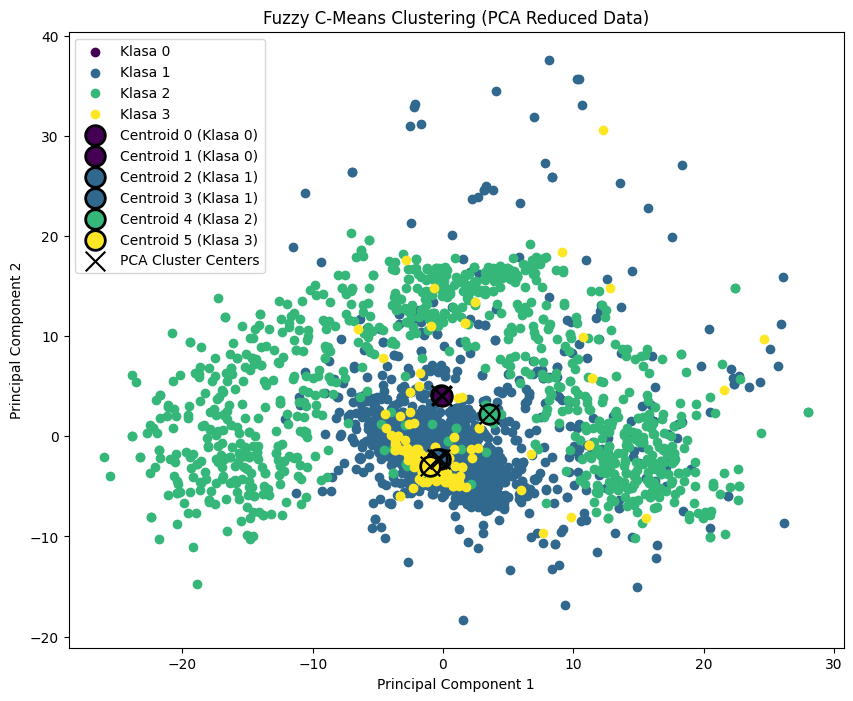

--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  62.043932082867656
local_errors[current_class]:  inf
Rozważamy obecnie chunk numer:  1


Processing:  10%|███████▉                                                                       | 2/20 [00:00<?, ?it/s]

data length:  69
aktualna klasa 1
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 5), 3: range(5, 6)}
Aktualna iteracja dla tej kalsy:  1
Wykonałem tyle iteracji:  2



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.3648713536581272
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
6


--------------Accuracy for dynamic algorithm-----------------: 0.7055
V_max_all:  11.010213225253032
local_errors[current_class]:  inf
Rozważamy obecnie chunk numer:  2


Processing:  15%|███████████▊                                                                   | 3/20 [00:00<?, ?it/s]

data length:  332
aktualna klasa 2
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 5), 3: range(5, 6)}
Aktualna iteracja dla tej kalsy:  2
Wykonałem tyle iteracji:  2



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.3648713536581272
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
6


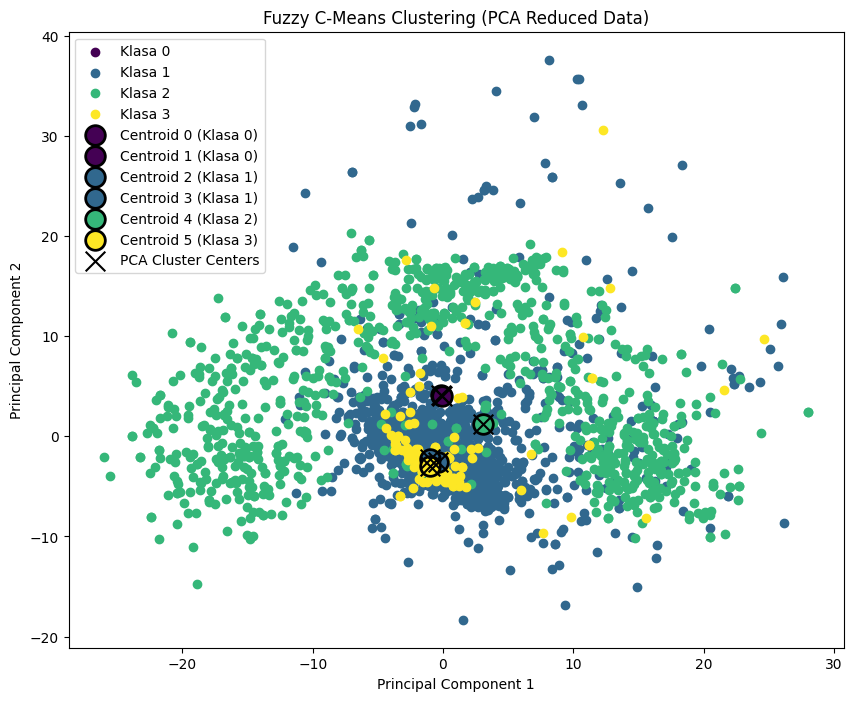

--------------Accuracy for dynamic algorithm-----------------: 0.75225
V_max_all:  125.39309590539081
local_errors[current_class]:  62.043932082867656


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.35632178993262664
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
--------------Accuracy for dynamic algorithm-----------------: 0.53225
V_max_all:  106.36220245151156
local_errors[current_class]:  62.043932082867656


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.35632178993262664
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
--------------Accuracy for dynamic algorithm-----------------: 0.51725
V_max_all:  79.13869398014495
local_errors[current_class]:  62.043932082867656


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.35632178993262664
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
--------------Accuracy for dynamic algorithm-----------------: 0.51725
V_max_all:  80.4614317793996
local_errors[current_class]:  62.043932082867656


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.33900388905261525
--------------Accuracy-Presidential------: 0.5
--------------Recall-Presidential------: 0.5
--------------Accuracy for dynamic algorithm-----------------: 0.53225
V_max_all:  81.56840176993622
local_errors[current_class]:  62.043932082867656


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.437290105981203
--------------Accuracy-Presidential------: 0.583
--------------Recall-Presidential------: 0.583
--------------Accuracy for dynamic algorithm-----------------: 0.53225
V_max_all:  82.2302945464616
local_errors[current_class]:  62.043932082867656


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.437290105981203
--------------Accuracy-Presidential------: 0.583
--------------Recall-Presidential------: 0.583
--------------Accuracy for dynamic algorithm-----------------: 0.51725
V_max_all:  53.503693172055165
local_errors[current_class]:  62.043932082867656
Rozważamy obecnie chunk numer:  3


Processing:  20%|███████████████▊                                                               | 4/20 [00:00<?, ?it/s]


data length:  694
aktualna klasa 2
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 11), 3: range(11, 12)}
Aktualna iteracja dla tej kalsy:  3
Wykonałem tyle iteracji:  12


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.625
--------------Accuracy-Presidential------: 0.75
--------------Recall-Presidential------: 0.75
12


--------------Accuracy for dynamic algorithm-----------------: 0.75225
V_max_all:  89.84126203537728
local_errors[current_class]:  53.503693172055165


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------Precision-Presidential------: 0.625
--------------Accuracy-Presidential------: 0.75
--------------Recall-Presidential------: 0.75
--------------Accuracy for dynamic algorithm-----------------: 0.7055
V_max_all:  54.45253709506293
local_errors[current_class]:  53.503693172055165
Rozważamy obecnie chunk numer:  4


Processing:  25%|███████████████████▊                                                           | 5/20 [00:00<?, ?it/s]


data length:  198
aktualna klasa 1
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 12), 3: range(12, 13)}
Aktualna iteracja dla tej kalsy:  2
Wykonałem tyle iteracji:  6


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.625
--------------Accuracy-Presidential------: 0.75
--------------Recall-Presidential------: 0.75
13


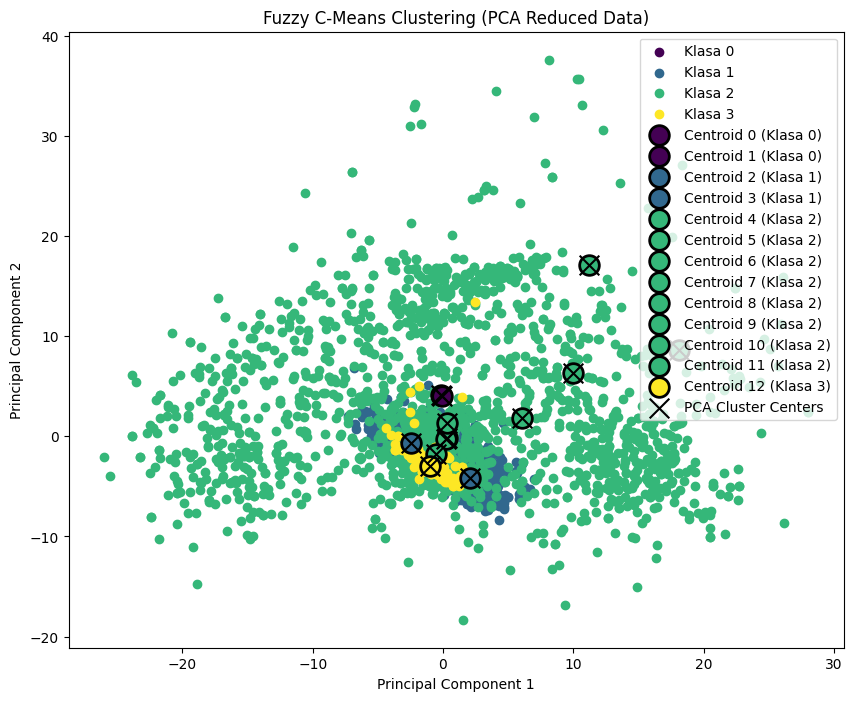

--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  11.285629746260645
local_errors[current_class]:  11.010213225253032
Rozważamy obecnie chunk numer:  5


Processing:  30%|███████████████████████▋                                                       | 6/20 [00:00<?, ?it/s]

data length:  477
aktualna klasa 3
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 12), 3: range(12, 13)}
Aktualna iteracja dla tej kalsy:  2
Wykonałem tyle iteracji:  2



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.625
--------------Accuracy-Presidential------: 0.75
--------------Recall-Presidential------: 0.75
13


--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  8.042267226401142
local_errors[current_class]:  8.944611369438732
Rozważamy obecnie chunk numer:  6


Processing:  35%|███████████████████████████▋                                                   | 7/20 [00:00<?, ?it/s]

data length:  349
aktualna klasa 0
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 12), 3: range(12, 13)}
Aktualna iteracja dla tej kalsy:  1
Wykonałem tyle iteracji:  2



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.625
--------------Accuracy-Presidential------: 0.75
--------------Recall-Presidential------: 0.75
13


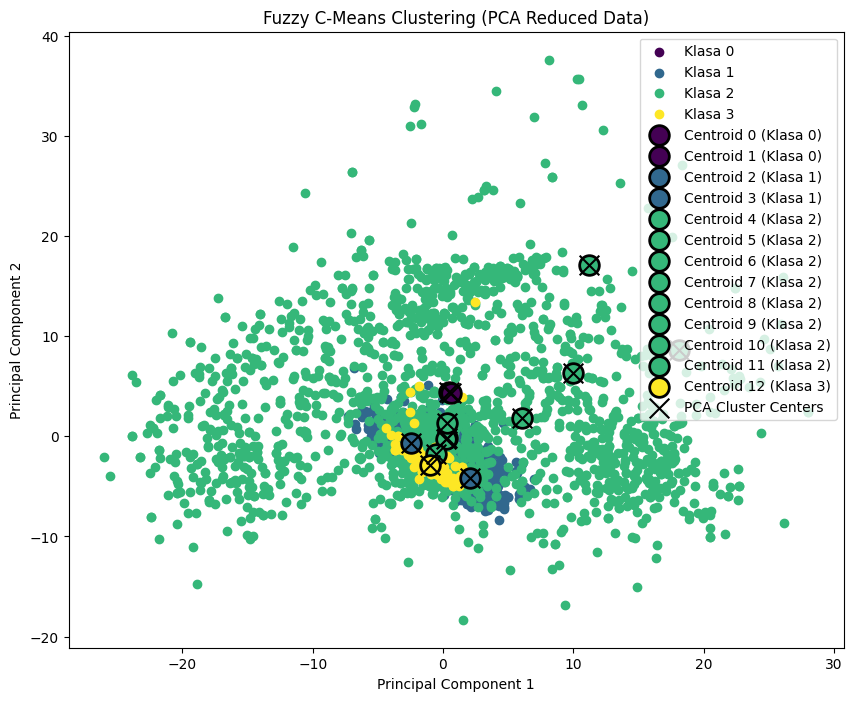

--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  54.29551347554351
local_errors[current_class]:  inf
Rozważamy obecnie chunk numer:  7


Processing:  40%|███████████████████████████████▌                                               | 8/20 [00:00<?, ?it/s]

data length:  448
aktualna klasa 0
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 12), 3: range(12, 13)}
Aktualna iteracja dla tej kalsy:  2
Wykonałem tyle iteracji:  2



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Precision-Presidential------: 0.625
--------------Accuracy-Presidential------: 0.75
--------------Recall-Presidential------: 0.75
13


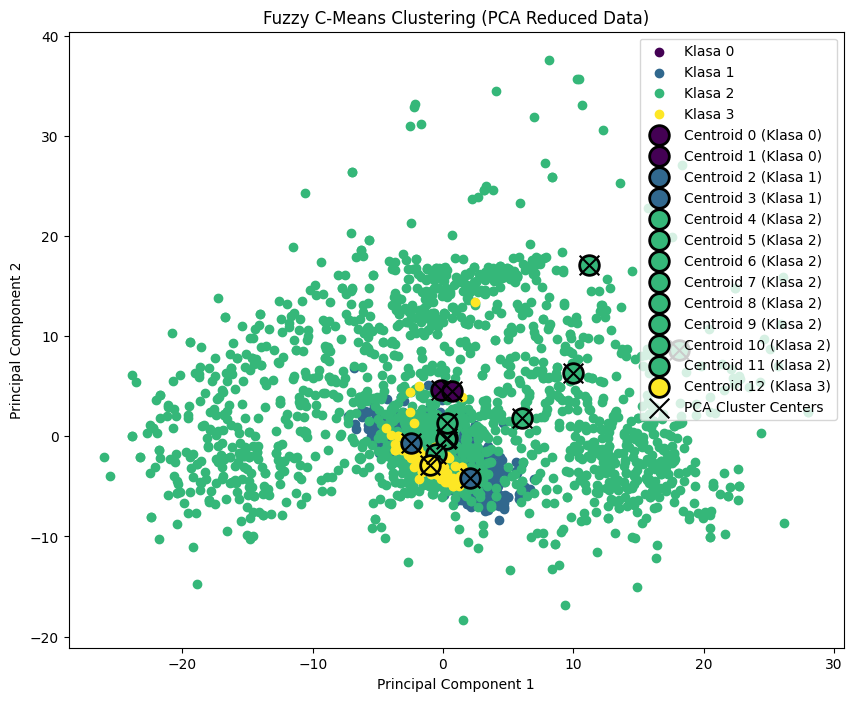

--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  42.84892559054153
local_errors[current_class]:  54.29551347554351
Rozważamy obecnie chunk numer:  8


Processing:  45%|███████████████████████████████████▌                                           | 9/20 [00:00<?, ?it/s]

data length:  606
aktualna klasa 0
clusters:  {0: range(0, 2), 1: range(2, 4), 2: range(4, 12), 3: range(12, 13)}
Aktualna iteracja dla tej kalsy:  3
Wykonałem tyle iteracji:  8


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
13


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


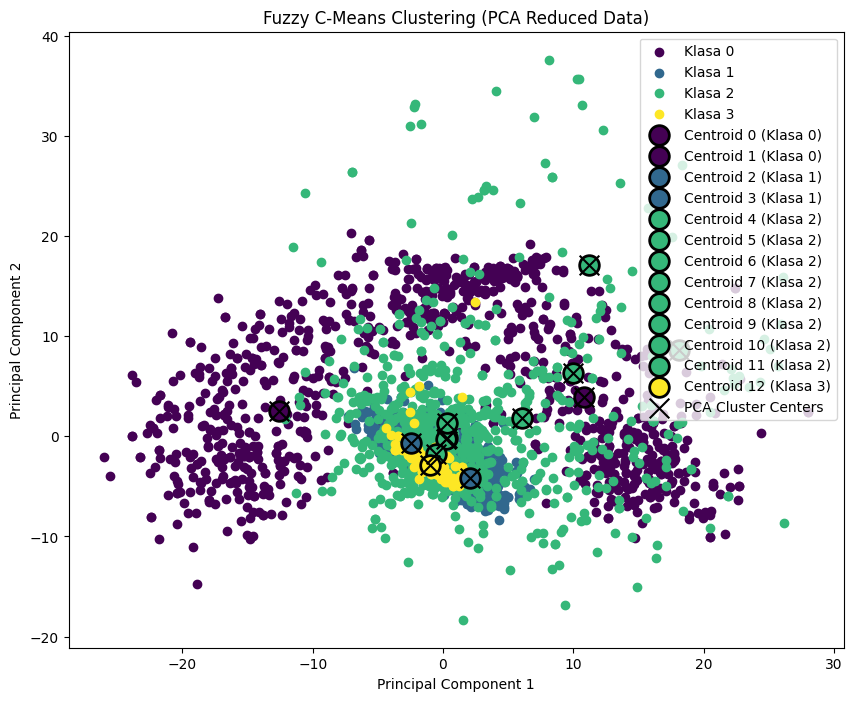

--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  75.72886232327404
local_errors[current_class]:  42.84892559054153
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  74.2490428000974
local_errors[current_class]:  42.84892559054153
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  73.94473253637517
local_errors[current_class]:  42.84892559054153
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.93825
V_max_all:  18.563450556431793
local_errors[current_class]:  42

Processing:  50%|███████████████████████████████████████                                       | 10/20 [00:00<?, ?it/s]

data length:  881
aktualna klasa 2
clusters:  {0: range(0, 5), 1: range(5, 7), 2: range(7, 15), 3: range(15, 16)}
Aktualna iteracja dla tej kalsy:  4
Wykonałem tyle iteracji:  14


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
16


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


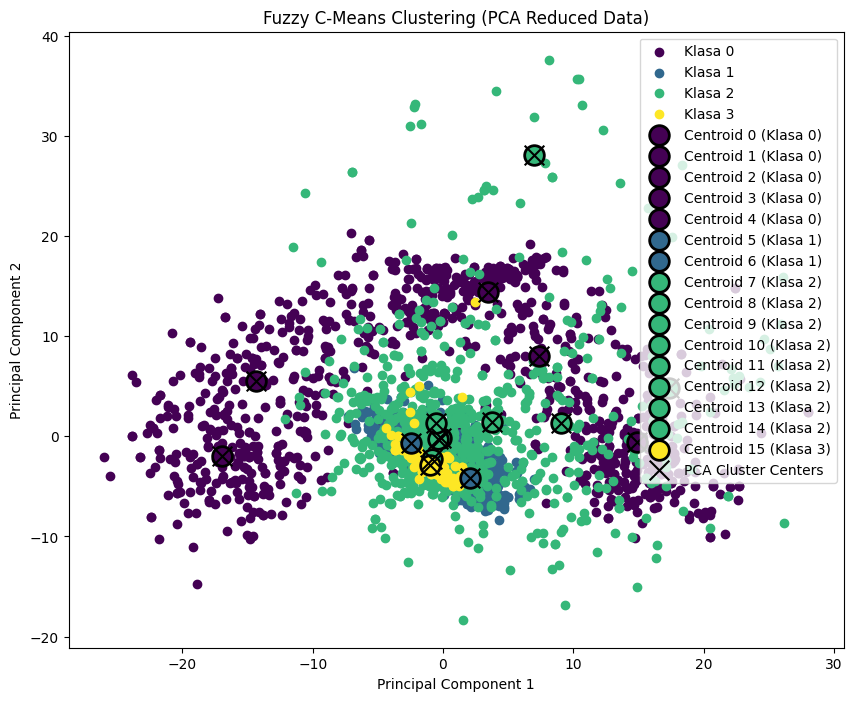

--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  48.545850357168725
local_errors[current_class]:  54.45253709506293
Rozważamy obecnie chunk numer:  10


Processing:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:00<?, ?it/s]

data length:  940
aktualna klasa 2
clusters:  {0: range(0, 5), 1: range(5, 7), 2: range(7, 15), 3: range(15, 16)}
Aktualna iteracja dla tej kalsy:  5
Wykonałem tyle iteracji:  3


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
16


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


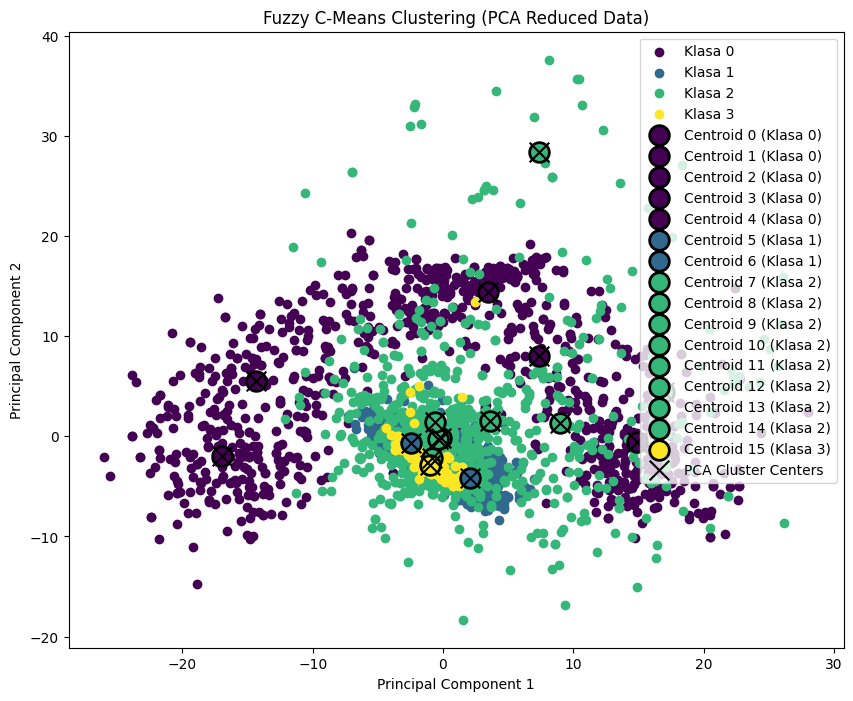

--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  50.29121704514976
local_errors[current_class]:  48.545850357168725
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  33.373408562778685
local_errors[current_class]:  48.545850357168725
Rozważamy obecnie chunk numer:  11


Processing:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:00<?, ?it/s]


data length:  508
aktualna klasa 3
clusters:  {0: range(0, 5), 1: range(5, 7), 2: range(7, 16), 3: range(16, 17)}
Aktualna iteracja dla tej kalsy:  3
Wykonałem tyle iteracji:  2
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
17


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  7.694605399769028
local_errors[current_class]:  8.042267226401142
Rozważamy obecnie chunk numer:  12


Processing:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:00<?, ?it/s]

data length:  871
aktualna klasa 1
clusters:  {0: range(0, 5), 1: range(5, 7), 2: range(7, 16), 3: range(16, 17)}
Aktualna iteracja dla tej kalsy:  3
Wykonałem tyle iteracji:  2


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
17


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  21.48864309295514
local_errors[current_class]:  11.285629746260645
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.7845
V_max_all:  15.455093616239687
local_errors[current_class]:  11.285629746260645
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.95275
V_max_all:  10.219156153758872
local_errors[current_class]:  11.285629746260645
Rozważamy obecnie chunk numer:  13


Processing:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:00<?, ?it/s]

data length:  611
aktualna klasa 3
clusters:  {0: range(0, 5), 1: range(5, 9), 2: range(9, 18), 3: range(18, 19)}
Aktualna iteracja dla tej kalsy:  4
Wykonałem tyle iteracji:  2


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
19


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


--------------Accuracy for dynamic algorithm-----------------: 0.95275
V_max_all:  7.788192660119782
local_errors[current_class]:  7.694605399769028
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.95275
V_max_all:  4.961893557809871
local_errors[current_class]:  7.694605399769028
Rozważamy obecnie chunk numer:  14


Processing:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:00<?, ?it/s]

data length:  1000
aktualna klasa 1
clusters:  {0: range(0, 5), 1: range(5, 9), 2: range(9, 18), 3: range(18, 20)}
Aktualna iteracja dla tej kalsy:  4
Wykonałem tyle iteracji:  27


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
20


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


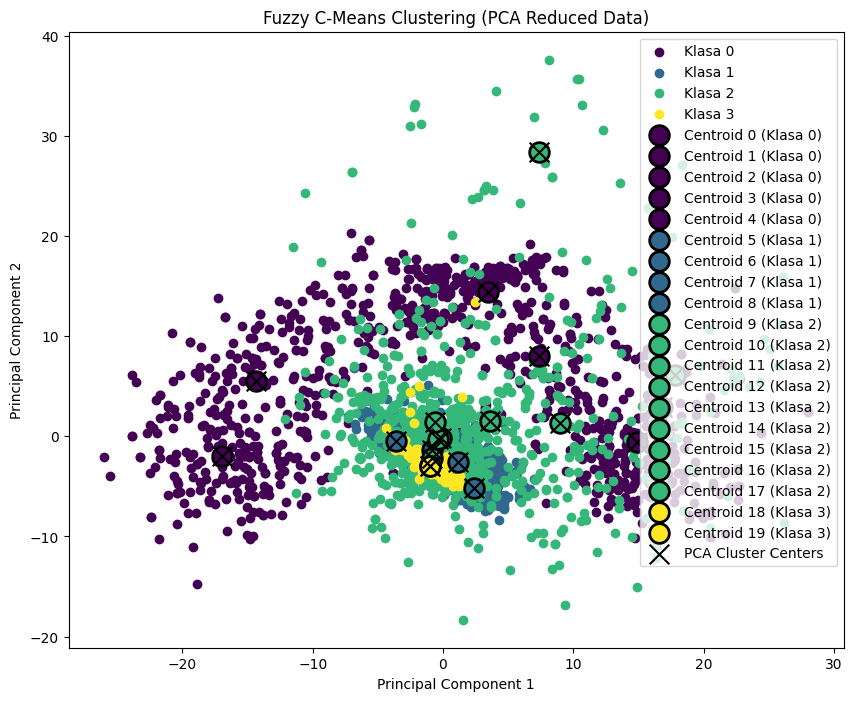

--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  13.827793304659368
local_errors[current_class]:  10.219156153758872
Rozważamy obecnie chunk numer:  15


Processing:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:00<?, ?it/s]

data length:  1000
aktualna klasa 0
clusters:  {0: range(0, 5), 1: range(5, 9), 2: range(9, 18), 3: range(18, 20)}
Aktualna iteracja dla tej kalsy:  4
Wykonałem tyle iteracji:  20


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
20


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


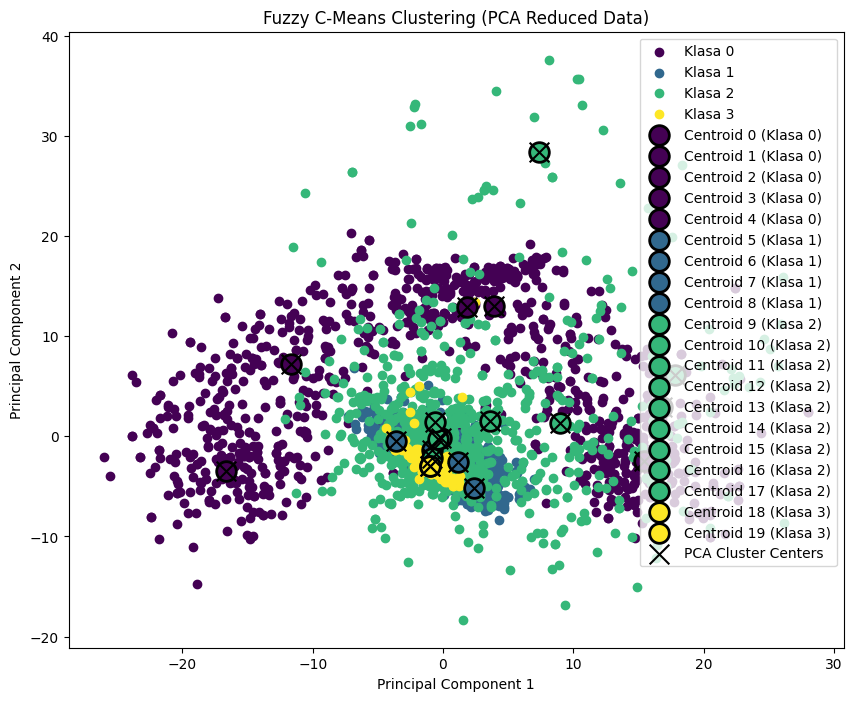

--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  19.780457641482418
local_errors[current_class]:  18.563450556431793
Rozważamy obecnie chunk numer:  16


Processing:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:00<?, ?it/s]

data length:  1000
aktualna klasa 2
clusters:  {0: range(0, 5), 1: range(5, 9), 2: range(9, 18), 3: range(18, 20)}
Aktualna iteracja dla tej kalsy:  6
Wykonałem tyle iteracji:  13


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
20


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


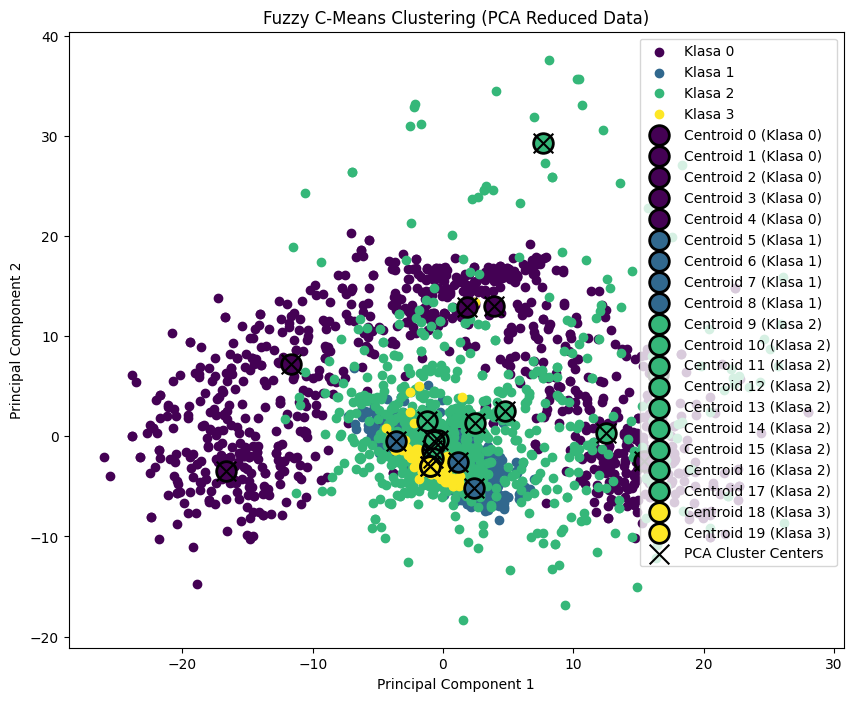

--------------Accuracy for dynamic algorithm-----------------: 0.985
V_max_all:  47.75919854166348
local_errors[current_class]:  33.373408562778685
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.97
V_max_all:  32.67344048562182
local_errors[current_class]:  33.373408562778685
Rozważamy obecnie chunk numer:  17


Processing:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:00<?, ?it/s]

data length:  683
aktualna klasa 3
clusters:  {0: range(0, 5), 1: range(5, 9), 2: range(9, 19), 3: range(19, 21)}
Aktualna iteracja dla tej kalsy:  5
Wykonałem tyle iteracji:  2


--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
21


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


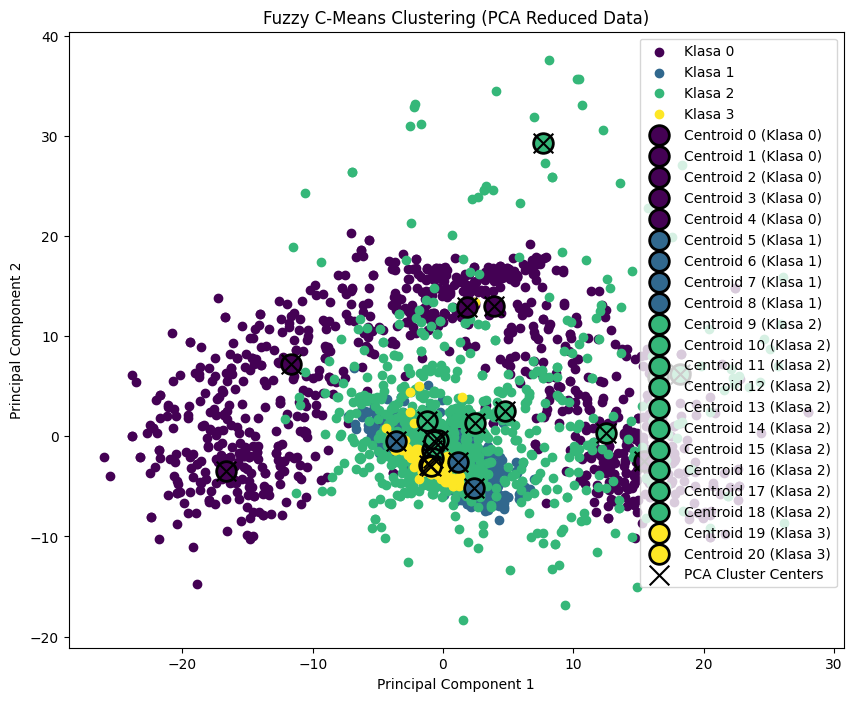

--------------Accuracy for dynamic algorithm-----------------: 0.97
V_max_all:  6.751041523230625
local_errors[current_class]:  4.961893557809871
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.97
V_max_all:  6.800664938256243
local_errors[current_class]:  4.961893557809871
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.97
V_max_all:  5.573496152509408
local_errors[current_class]:  4.961893557809871
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
--------------Accuracy for dynamic algorithm-----------------: 0.97
V_max_all:  5.801024421548486
local_errors[current_class]:  4.961893557809

Processing:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:00<?, ?it/s]


data length:  1000
aktualna klasa 3
clusters:  {0: range(0, 5), 1: range(5, 9), 2: range(9, 19), 3: range(19, 31)}
Aktualna iteracja dla tej kalsy:  6
Wykonałem tyle iteracji:  21
--------------Precision-Presidential------: 1.0
--------------Accuracy-Presidential------: 1.0
--------------Recall-Presidential------: 1.0
31


C:\Users\Damian\AppData\Local\Temp\ipykernel_9532\2243369440.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 4)


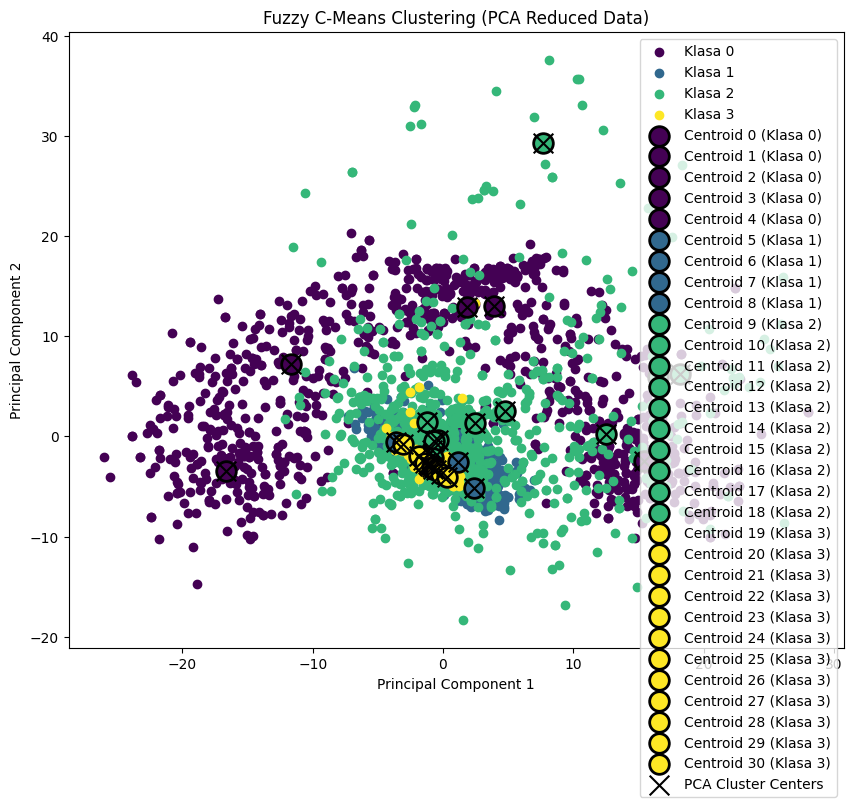

--------------Accuracy for dynamic algorithm-----------------: 0.97
V_max_all:  1.0966522397041485
local_errors[current_class]:  6.837750183302189
Rozważamy obecnie chunk numer:  19


Processing: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


In [60]:
diagnosis_chunk, diagnosis_iterations = dynamic_local_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_matrix, chunks_y, chunks_test, chunks_test_y, clusters_for_each_class.copy(), visualise_data=True, init_centroids=init_centroids.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

# Testowanie algorytmu IFCM

### Implementacja algorytmów

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics
from libraries.IFCM import incremental_fuzzy_cmeans

In [ ]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Ćwiczone są w danej iteracji tylko centroidy danej klasy. Konkretnie klasy obecnie rozpatrywanego chunka.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_chunks - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_local_fuzzy_cmeans(n_clusters, chunks, chunks_y, validation_chunks, validation_chunks_y, clusters_for_each_class, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    # Inicjalizacja centroidów
    centroids = init_centroids

    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):

        current_class = np.bincount(chunks_y[count]).argmax()

        # Wybieramy tylko centroidy do treningu, które łączą się z daną klasą.
        clusters = list(clusters_for_each_class[current_class])
        centroids_local = centroids[clusters]
    
        centroids_local, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids_local)

        # Łączenie wyćwiczone centroidy z starymi
        centroids[clusters] = centroids_local

        # Predykcja algorytmu ifcm
        cluster_membership, fuzzy_labels = predict_data_ifcm(data, centroids)

        # if(visualise_data, and count > 2):
        #     plot_func(data, centroids, fuzzy_labels)
            
        if(visualise_data and count > 3):
            fuzzy_labels_all = create_labels(np.concatenate(chunks[:count]), y=(np.concatenate(chunks_y[:count])).T, centroids = centroids, metric = metric, m = m)
            plot_func(np.concatenate(chunks[:count]), centroids, fuzzy_labels_all)
        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_ifcm(validation_chunks, centroids, validation_chunks_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)

    # Wyswielenie wyników
    _, fuzzy_labels = predict_data_dissfcm(X_test, centroids)
    plot_func(X_test, centroids, fuzzy_labels)
    popularity_of_clusters(fuzzy_labels, n_clusters)
    
    return diagnosis_tools, diagnosis_iterations

In [ ]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_chunks - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans(n_clusters, chunks, validation_chunks, validation_chunks_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):

        # Dla pierwszej iteracji (pierwszego chunk'a) inicjalizujemy centroidami startowymi.
        if(count == 0):
            centroids = init_centroids
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_ifcm(validation_chunks, centroids, validation_chunks_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [ ]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych). 
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_chunks - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, validation_chunks, y_valid_extended, visualise_data=False, plot_func=plot_pca, metric = 'euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)
    diagnosis_iterations.append(diagnosis_iteration)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_ifcm(validation_chunks, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
    diagnosis_tools.add_centroids(centroids)

    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data = np.vstack((data, chunk))
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_ifcm(validation_chunks, centroids, y_valid_extended, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)

        if(visualise_data == False):
            # Czyszczenie poprzedniego outputu
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [ ]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych) do pewnej określonej wielkości, po przekroczeniu tej wielkości dane są aktualizowane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_chunks - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, validation_chunks, y_valid_extended, visualise_data=False, plot_func=plot_pca, window_size=5, metric = 'euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_ifcm(validation_chunks, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(diagnosis_iteration)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)

    data = [data]
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data.append(chunk)

        if len(data) > window_size:
            del data[0]
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(np.concatenate(data), c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_ifcm(validation_chunks, centroids, y_valid_extended, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        if(visualise_data == False):
            # Czyszczenie poprzedniego outputu
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

### Trenowanie przy pomocy iterowani się po chunkach, dodatkowo w danej iteracji liczone są tylko clustry z klasy danych ćwiczonych

In [ ]:
diagnosis_chunk, diagnosis_iterations = train_incremental_local_fuzzy_cmeans(n_clusters, chunks, chunks_y, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne, clusters_for_each_class=clusters_for_each_class.copy(), init_centroids=init_centroids.copy())

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach

In [55]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans(n_clusters, chunks, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne)

NameError: name 'train_incremental_fuzzy_cmeans' is not defined

In [56]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

NameError: name 'diagnosis_chunk' is not defined

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi

In [57]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, chunks_test, chunks_test_y, visualise_data=True)

NameError: name 'train_incremental_fuzzy_cmeans_extending_data' is not defined

In [ ]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi, przesuwającym się oknem

In [58]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, chunks_test, chunks_test_y)

NameError: name 'train_incremental_fuzzy_cmeans_extending_window_data' is not defined

In [59]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

NameError: name 'diagnosis_chunk' is not defined

### Badania zachowania się metody ze względu na liczbę clustrów



In [60]:
def find_optimal_number_of_clusters_ifcm(range_ = range(2,10)):
    output_data_chunk = []
    output_data_iter = []
    for n in range_:
        print('Rozważam: ', n)
        diagnosis_tools, diagnosis_iterations = train_incremental_fuzzy_cmeans(n, chunks, chunks_test, chunks_test_y)
        output_data_chunk.append(diagnosis_tools)
        output_data_iter.append(diagnosis_iterations)
    plot_statistic = DiagnosisTools()

    for n in range_:
        sil, dave, fpc, rand = output_data_chunk[n-2].get_avg()
        plot_statistic.add_elements(sil, dave, fpc, rand)

    plot_statistic.plot_lists()

    return plot_statistic, output_data_chunk, output_data_iter

#find_optimal_number_of_clusters_ifcm()

# Testowanie algorytmu ISSFCM

In [71]:
from libraries.ISSFCM import incremental_semi_supervised_fuzzy_cmeans

In [123]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       chunks_y - lista chunków labeli odpowiadających chunks. Labele nie są postaci listy tylko macierzy rozmytych przynależności do danej klasy.
#       validation_chunks - dane validacyjne
#       validation_chunks_y - labele dla danych validacyjnych
def train_local_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_supervised, chunks_y, validation_chunks, validation_chunks_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids.copy()):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    centroids = init_centroids
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
            
        chunk_y_supervised = chunks_y_supervised[count]
        
        # Segment jest klasy current_class
        current_class = chunks_y[count][0]
        
        # Wybieramy tylko centroidy do treningu, które łączą się z daną klasą.
        clusters = list(clusters_for_each_class[current_class])

        # Wybieramy centroidy które chcemy uczyć
        centroids_local = centroids[clusters]
        chunk_y_supervised_local = chunk_y_supervised[:,clusters]
        
        # Algorytm (di)ssfcm dla jednej iteracji, dla jednego chunk'a
        centroids_local, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(data, chunk_y_supervised_local, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids_local)

        # Łączenie wyćwiczone centroidy z starymi
        centroids[clusters] = centroids_local
        chunk_y_supervised[:,clusters] = chunk_y_supervised_local

        # Obliczam fuzzy_labels dla przy pomocy wszystkich centroidów
        _, fuzzy_labels = predict_data_issfcm(data, centroids)
        
        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)
        
        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_issfcm(validation_chunks, centroids, validation_chunks_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
    # Wyswielenie wyników
    _, fuzzy_labels = predict_data_dissfcm(X_test, centroids)
    plot_func(X_test, centroids, fuzzy_labels)
    popularity_of_clusters(fuzzy_labels, n_clusters)   
    return diagnosis_tools, diagnosis_iterations

In [124]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       chunks_y - lista chunków labeli odpowiadających chunks. Labele nie są postaci listy tylko macierzy rozmytych przynależności do danej klasy.
#       validation_chunks - dane validacyjne
#       validation_chunks_y - labele dla danych validacyjnych
def train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, validation_chunks, validation_chunks_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids.copy()):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    centroids = init_centroids
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
  
        chunk_y_supervised = chunks_y[count]

        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(data, chunk_y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test, statistics = valid_data_issfcm(validation_chunks, centroids, validation_chunks_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand, statistics)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

### Trenowanie ISSFCM

8


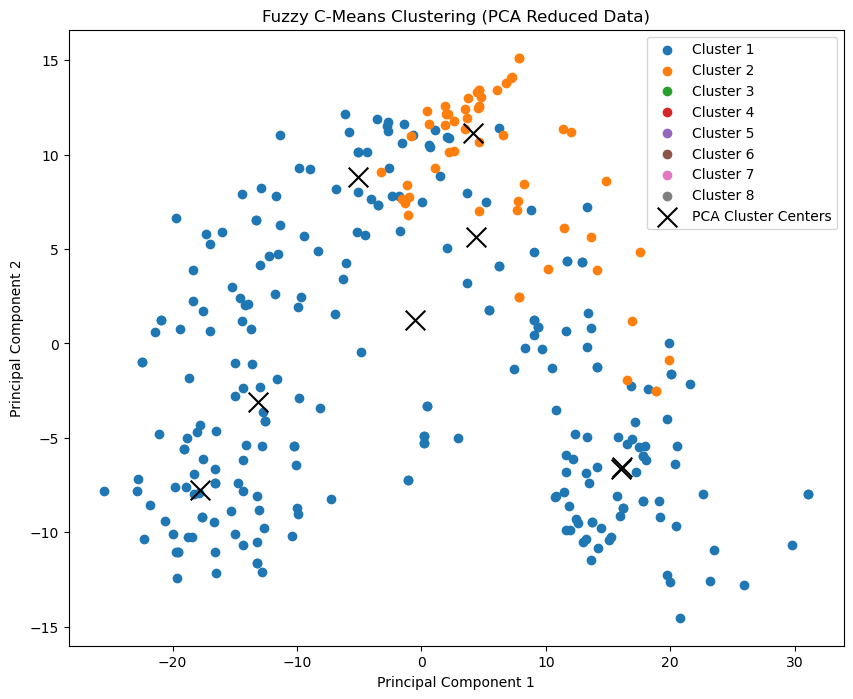

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 0 0 0 0 0 0 0]
Silhouette Score: 0.48102301048001334
Davies-Bouldin Score: 1.45003216206026
Rand Score: 0.5817745686421606
Tested fpc: 0.43071733239368315
Accuracy: 0.46511627906976744
Precision:  0.31532147742818056
Recall:  0.46511627906976744
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:   6%|██▍                                    | 1/16 [00:00<?, ?it/s]

8


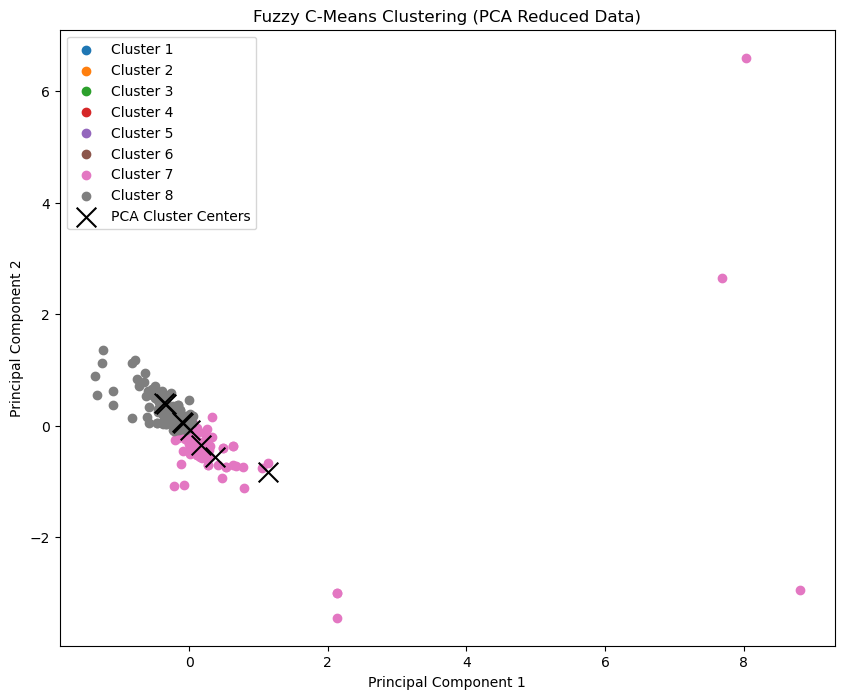

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 3 0 3 3 1 3 3]
Silhouette Score: -0.31438535453117544
Davies-Bouldin Score: 3.6612241543415243
Rand Score: 0.6505388847211803
Tested fpc: 0.43071733239368315
Accuracy: 0.3953488372093023
Precision:  0.4127506014434643
Recall:  0.3953488372093023
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  12%|████▉                                  | 2/16 [00:00<?, ?it/s]

8


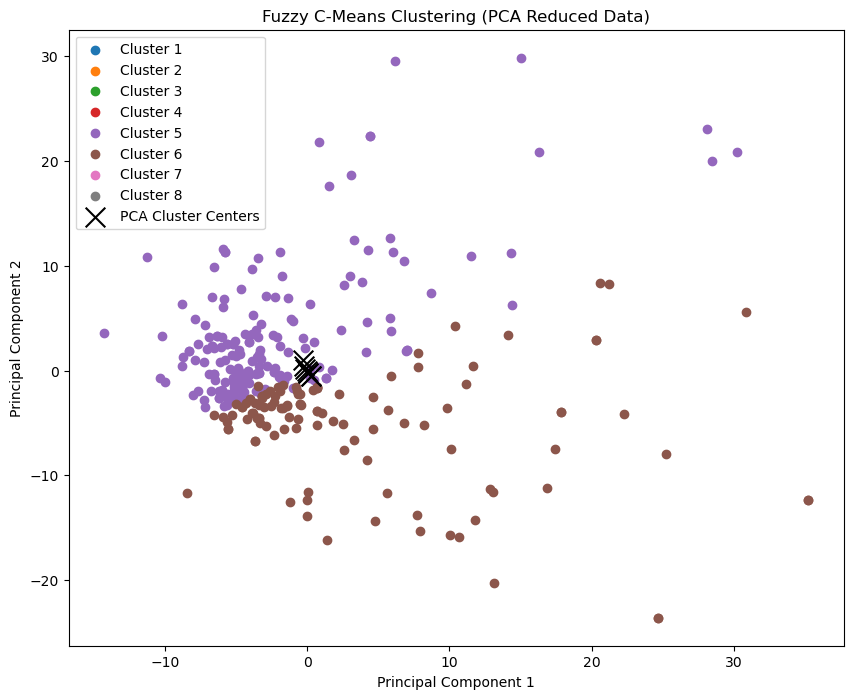

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 3 0 1 2 1 2 0]
Silhouette Score: -0.08347396078723006
Davies-Bouldin Score: 2.7491803259222727
Rand Score: 0.7011336584146036
Tested fpc: 0.43071733239368315
Accuracy: 0.6976744186046512
Precision:  0.5553149420958478
Recall:  0.6976744186046512
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  19%|███████▎                               | 3/16 [00:00<?, ?it/s]

8


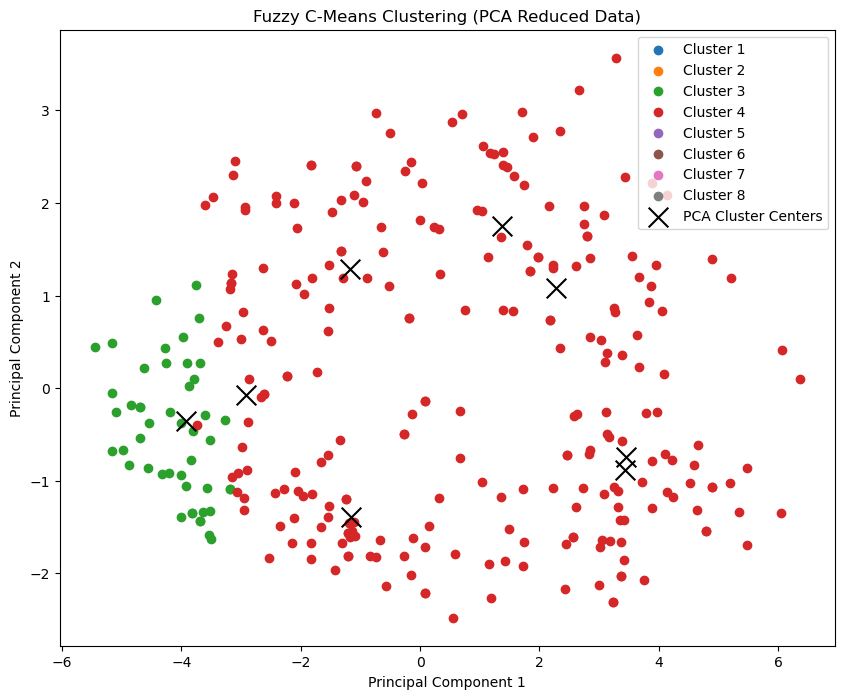

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 3 0 1 1 0 3 2]
Silhouette Score: -0.12981879944502991
Davies-Bouldin Score: 2.4881651136965317
Rand Score: 0.7072839459864966
Tested fpc: 0.43071733239368315
Accuracy: 0.5116279069767442
Precision:  0.5005587781384705
Recall:  0.5116279069767442
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 4/16 [00:00<?, ?it/s]

8


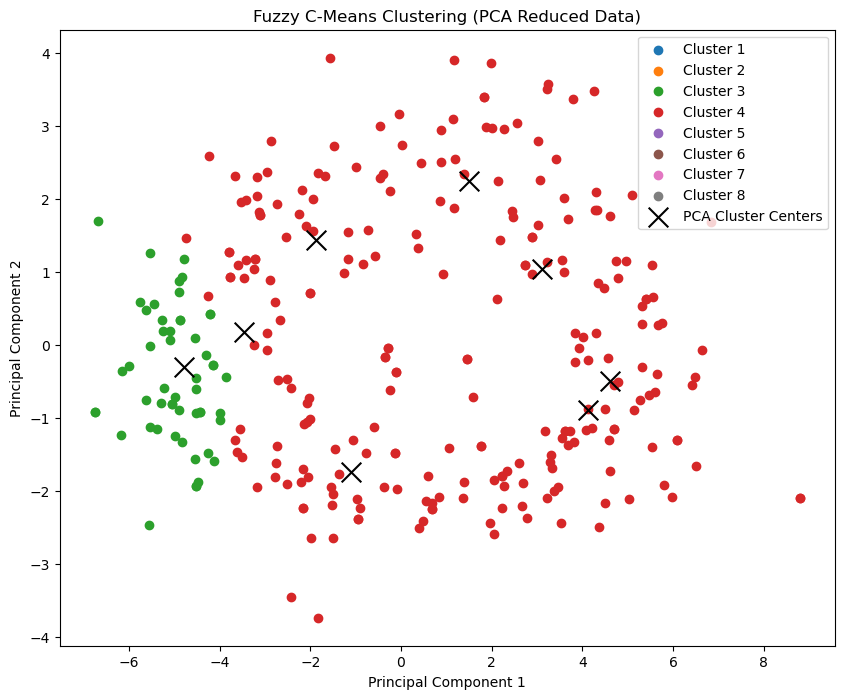

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 1 0 1 0 1 3 0]
Silhouette Score: -0.06973387594381326
Davies-Bouldin Score: 2.211403340273477
Rand Score: 0.7084189797449363
Tested fpc: 0.43071733239368315
Accuracy: 0.6046511627906976
Precision:  0.5266106442577031
Recall:  0.6046511627906976
Rozważamy obecnie chunk numer:  4
Liczba klastrów:  8


Processing:  31%|████████████▏                          | 5/16 [00:00<?, ?it/s]

8


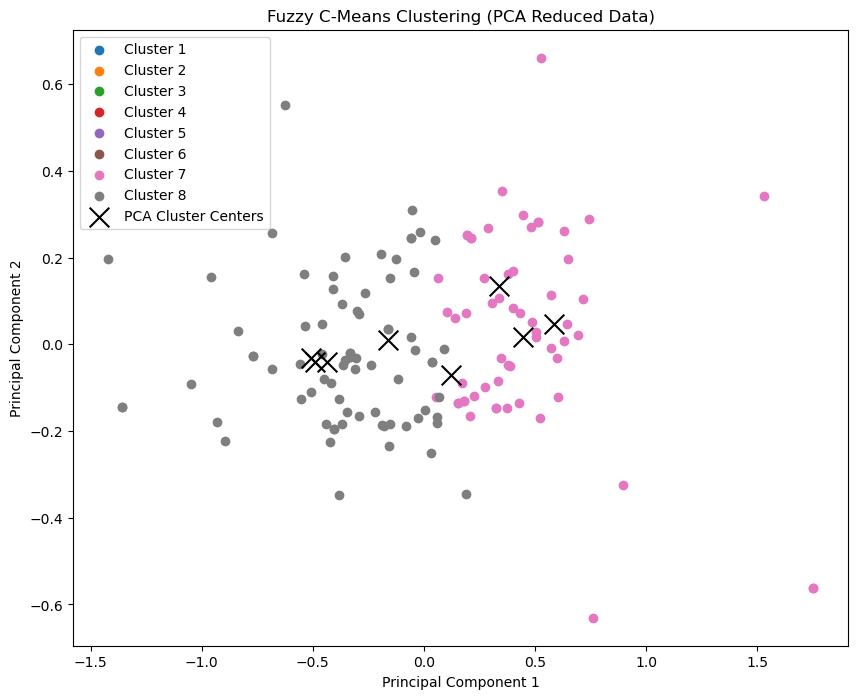

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 1 3 0 3 3 3 3]
Silhouette Score: -0.281520035176175
Davies-Bouldin Score: 4.328922750986914
Rand Score: 0.628262815703926
Tested fpc: 0.43071733239368315
Accuracy: 0.46511627906976744
Precision:  0.4442721791559001
Recall:  0.46511627906976744
Rozważamy obecnie chunk numer:  5
Liczba klastrów:  8


Processing:  38%|██████████████▋                        | 6/16 [00:00<?, ?it/s]

8


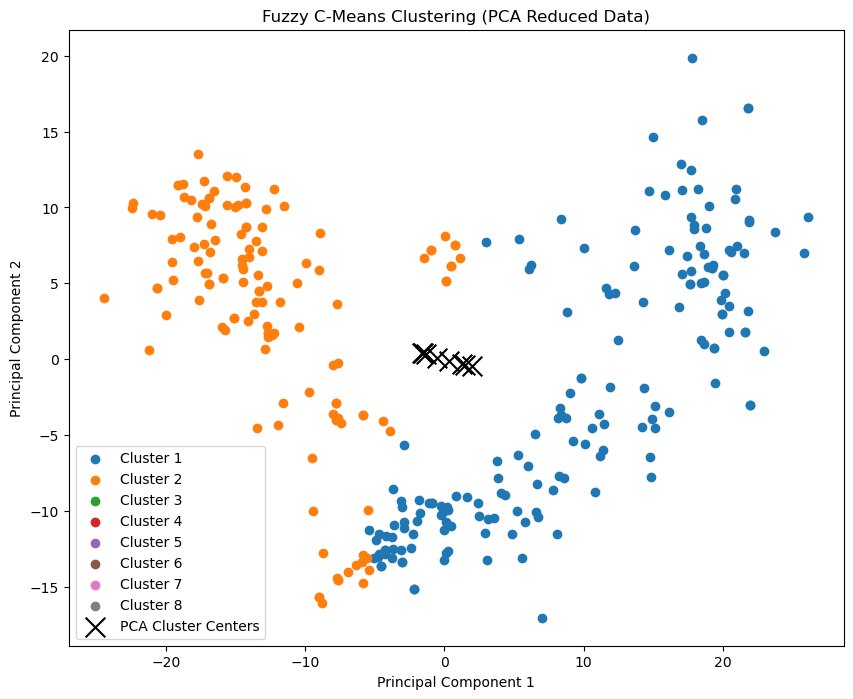

przynalznosc clustra do klasy [3 1 0 0 3 2 2 3]
Silhouette Score: -0.15799622661120677
Davies-Bouldin Score: 3.599220987884155
Rand Score: 0.6927863215803951
Tested fpc: 0.43071733239368315
Accuracy: 0.6976744186046512
Precision:  0.7386248736097067
Recall:  0.6976744186046512
Rozważamy obecnie chunk numer:  6
Liczba klastrów:  8


Processing:  44%|█████████████████                      | 7/16 [00:00<?, ?it/s]

8


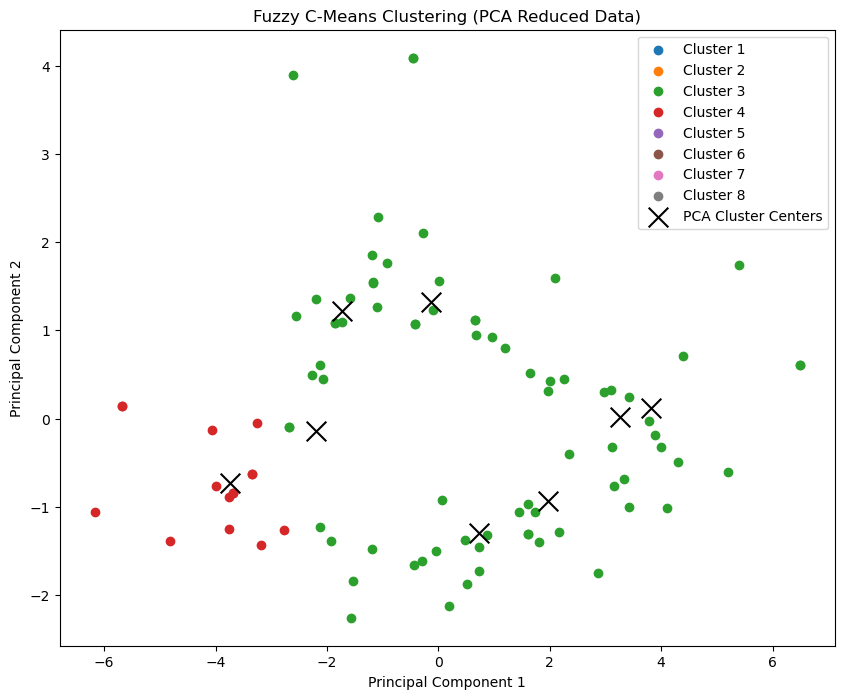

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 0 3 0 1 1 2 2]
Silhouette Score: -0.10230653640930362
Davies-Bouldin Score: 2.0967566704721916
Rand Score: 0.7148332083020755
Tested fpc: 0.43071733239368315
Accuracy: 0.627906976744186
Precision:  0.55792286580962
Recall:  0.627906976744186
Rozważamy obecnie chunk numer:  7
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 8/16 [00:00<?, ?it/s]

8


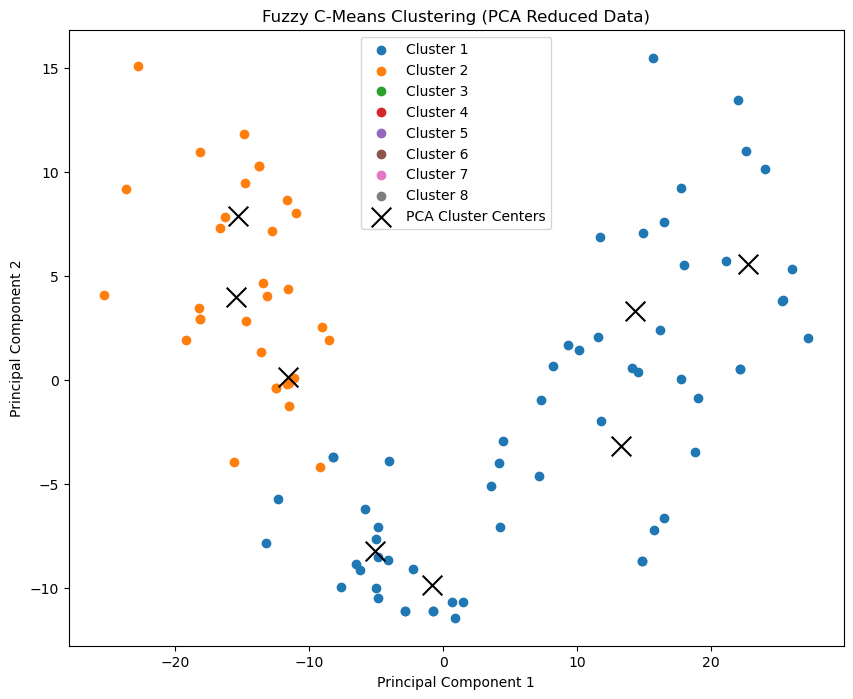

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 1 3 0 2 0 0 0]
Silhouette Score: 0.2957964914564417
Davies-Bouldin Score: 1.3329176400718263
Rand Score: 0.6364626156539135
Tested fpc: 0.43071733239368315
Accuracy: 0.3488372093023256
Precision:  0.39309827456864216
Recall:  0.3488372093023256
Rozważamy obecnie chunk numer:  8
Liczba klastrów:  8


Processing:  56%|█████████████████████▉                 | 9/16 [00:00<?, ?it/s]

8


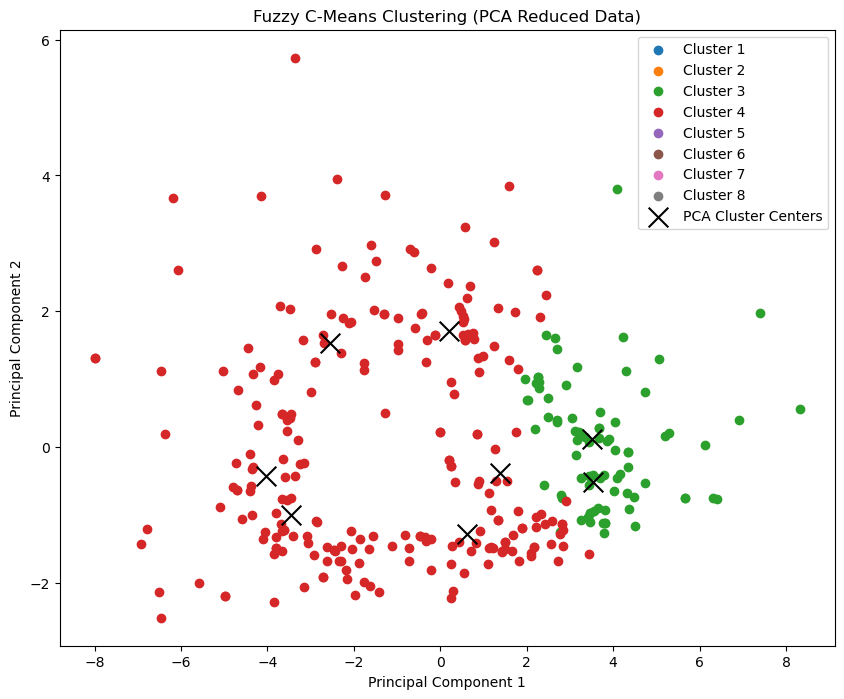

przynalznosc clustra do klasy [1 0 0 3 1 1 0 2]
Silhouette Score: 0.07978762932188539
Davies-Bouldin Score: 1.9576886499873174
Rand Score: 0.7423855963990997
Tested fpc: 0.43071733239368315
Accuracy: 0.6046511627906976
Precision:  0.620483836129311
Recall:  0.6046511627906976
Rozważamy obecnie chunk numer:  9
Liczba klastrów:  8


Processing:  62%|███████████████████████▊              | 10/16 [00:00<?, ?it/s]


8


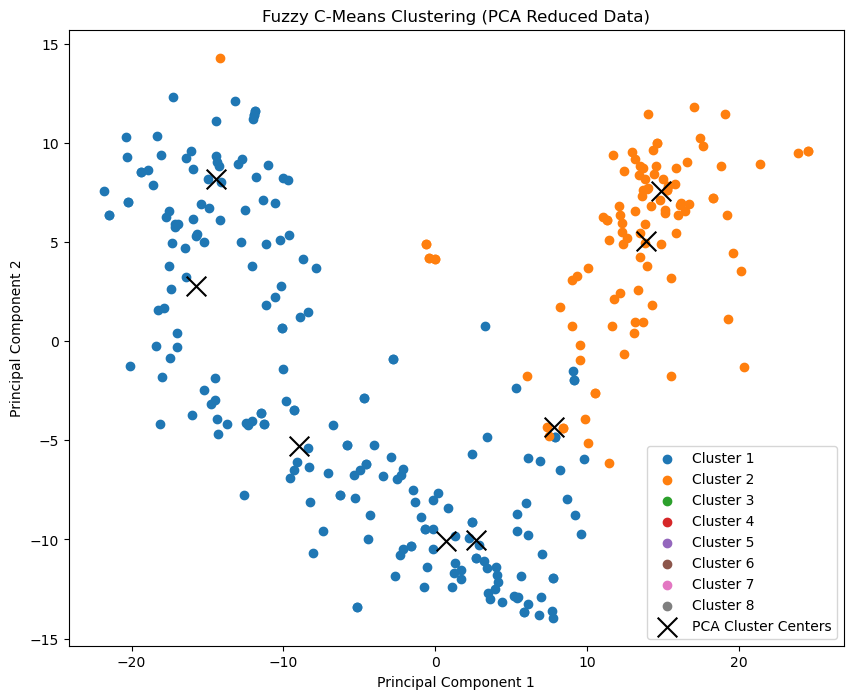

przynalznosc clustra do klasy [0 0 3 1 2 1 0 0]
Silhouette Score: 0.08176914066490995
Davies-Bouldin Score: 1.583725333113335
Rand Score: 0.7047421855463866
Tested fpc: 0.43071733239368315
Accuracy: 0.8372093023255814
Precision:  0.8774224806201552
Recall:  0.8372093023255814
Rozważamy obecnie chunk numer:  10
Liczba klastrów:  8


Processing:  69%|██████████████████████████▏           | 11/16 [00:00<?, ?it/s]

8


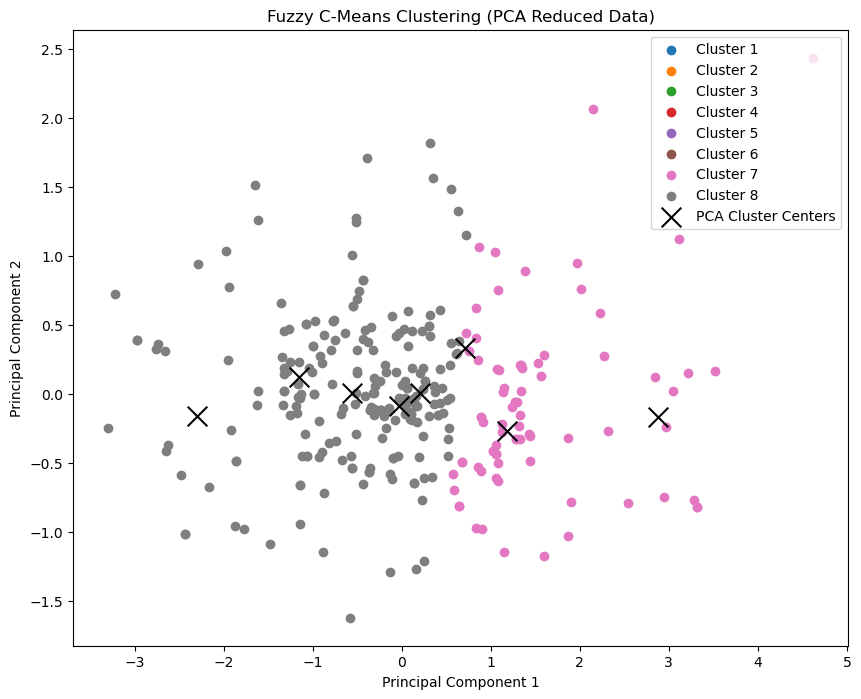

przynalznosc clustra do klasy [1 1 3 0 3 3 2 3]
Silhouette Score: -0.22064783348194236
Davies-Bouldin Score: 2.5295376081519594
Rand Score: 0.699925856464116
Tested fpc: 0.43071733239368315
Accuracy: 0.7209302325581395
Precision:  0.6996124031007752
Recall:  0.7209302325581395
Rozważamy obecnie chunk numer:  11
Liczba klastrów:  8


Processing:  75%|████████████████████████████▌         | 12/16 [00:00<?, ?it/s]

8


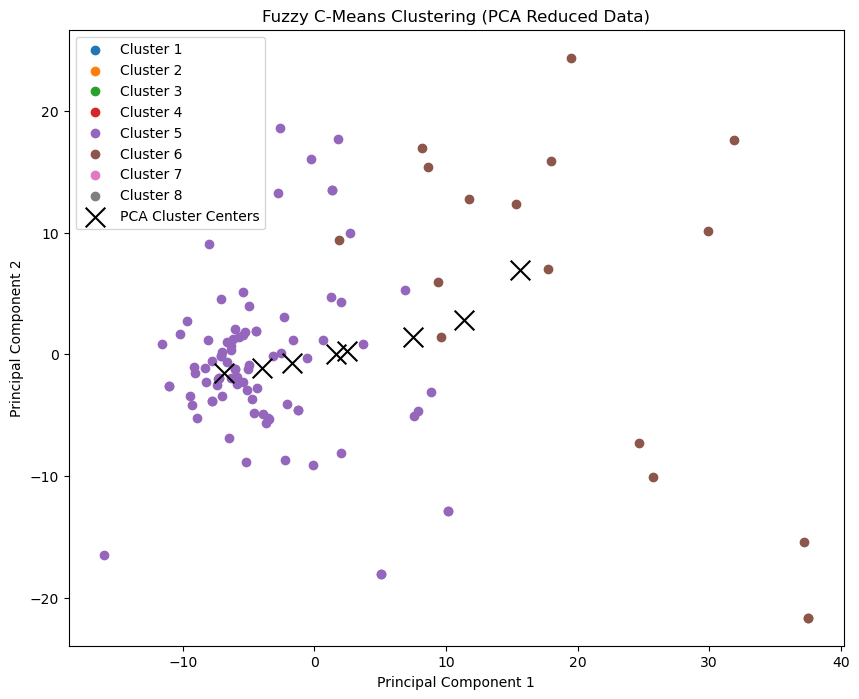

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [2 2 0 3 0 0 1 0]
Silhouette Score: 0.12027935059947104
Davies-Bouldin Score: 3.5403531585839714
Rand Score: 0.5899693673418355
Tested fpc: 0.43071733239368315
Accuracy: 0.2558139534883721
Precision:  0.06699889258028793
Recall:  0.2558139534883721
Rozważamy obecnie chunk numer:  12
Liczba klastrów:  8


Processing:  81%|██████████████████████████████▉       | 13/16 [00:00<?, ?it/s]

8


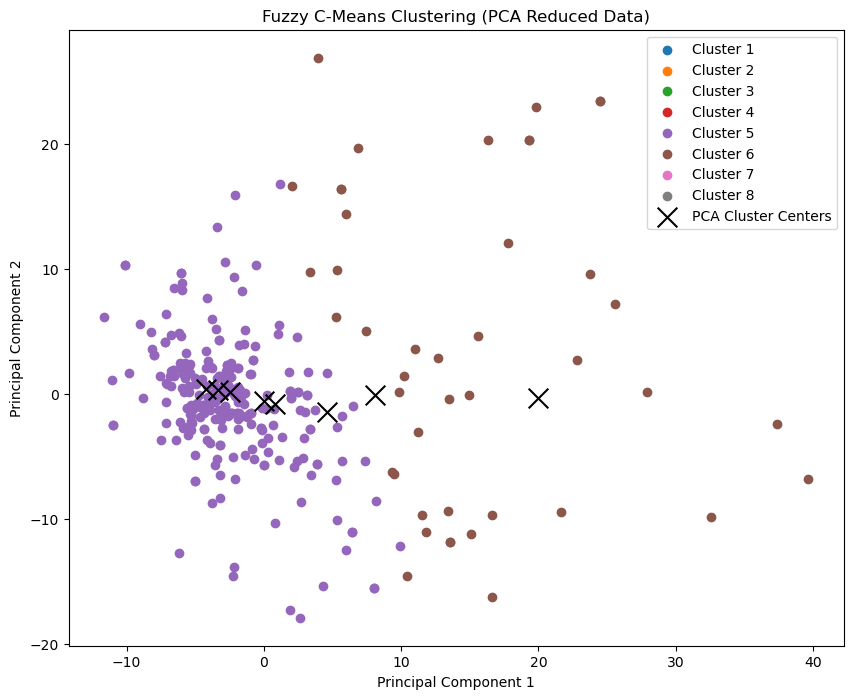

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [1 2 2 3 0 0 1 2]
Silhouette Score: 0.039872307517235216
Davies-Bouldin Score: 3.261806939919837
Rand Score: 0.6346376594148537
Tested fpc: 0.43071733239368315
Accuracy: 0.32558139534883723
Precision:  0.5587209302325581
Recall:  0.32558139534883723
Rozważamy obecnie chunk numer:  13
Liczba klastrów:  8


Processing:  88%|█████████████████████████████████▎    | 14/16 [00:00<?, ?it/s]

8


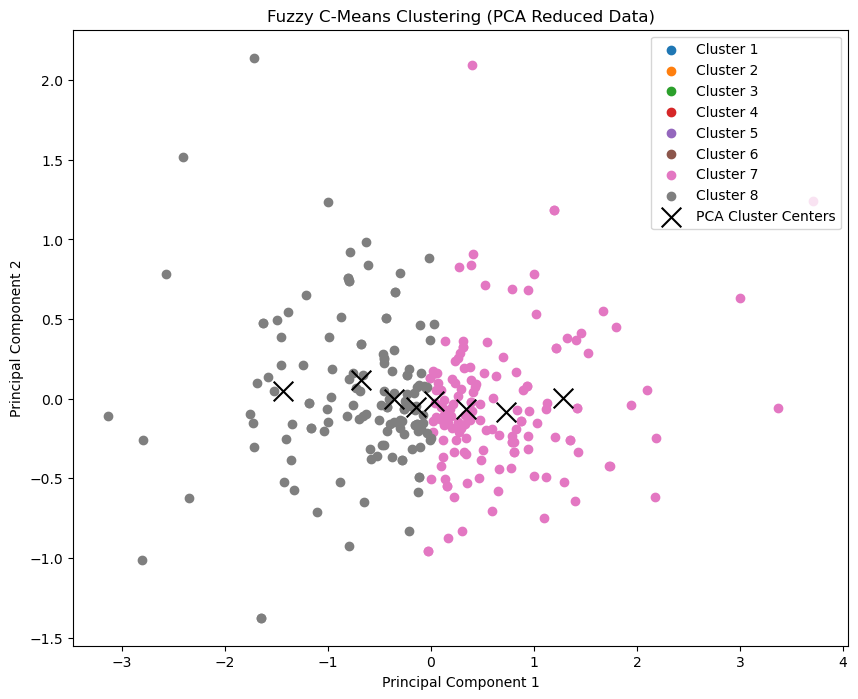

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [3 3 3 0 1 3 3 3]
Silhouette Score: -0.2624038809419884
Davies-Bouldin Score: 2.942077977830552
Rand Score: 0.6618574643660915
Tested fpc: 0.43071733239368315
Accuracy: 0.5116279069767442
Precision:  0.503875968992248
Recall:  0.5116279069767442
Rozważamy obecnie chunk numer:  14
Liczba klastrów:  8


Processing:  94%|███████████████████████████████████▋  | 15/16 [00:00<?, ?it/s]

8


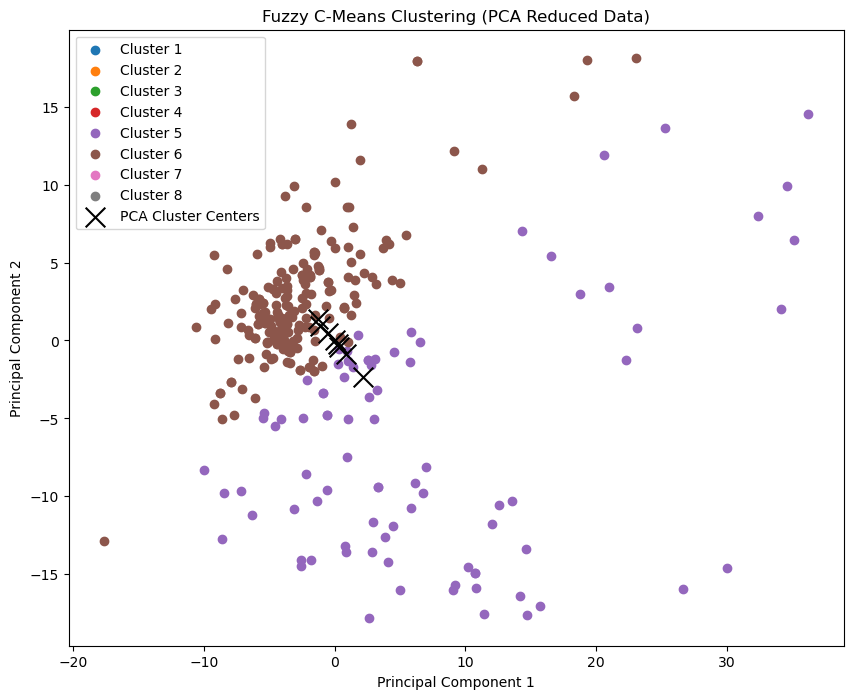

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [1 0 0 3 0 1 1 2]
Silhouette Score: -0.09301369201334508
Davies-Bouldin Score: 3.716017323100128
Rand Score: 0.6044846211552888
Tested fpc: 0.43071733239368315
Accuracy: 0.4418604651162791
Precision:  0.31295681063122927
Recall:  0.4418604651162791
Rozważamy obecnie chunk numer:  15
Liczba klastrów:  8


Processing: 100%|██████████████████████████████████████| 16/16 [00:00<?, ?it/s]


In [74]:
diagnosis_chunk, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_matrix, chunks_test, chunks_test_y, visualise_data=True)

Historia danych ze względu na kolejne chunki


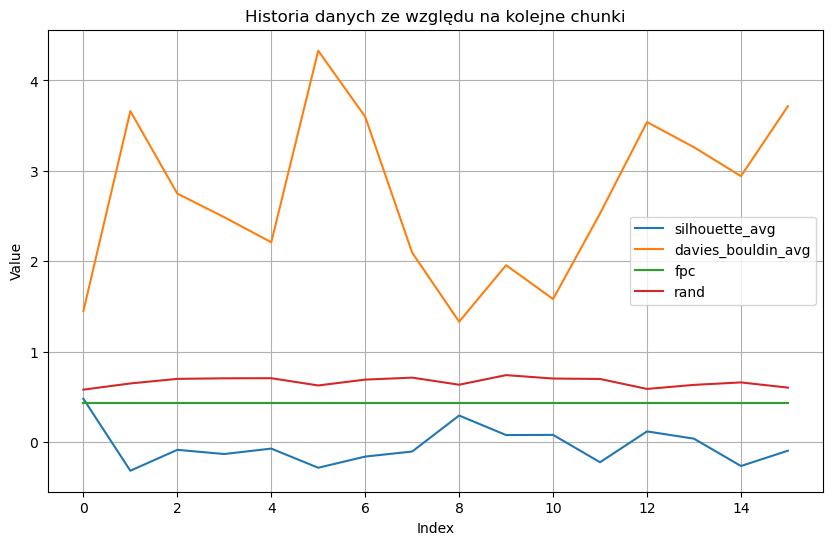

Historia statystyk ze względu na kolejne chunki


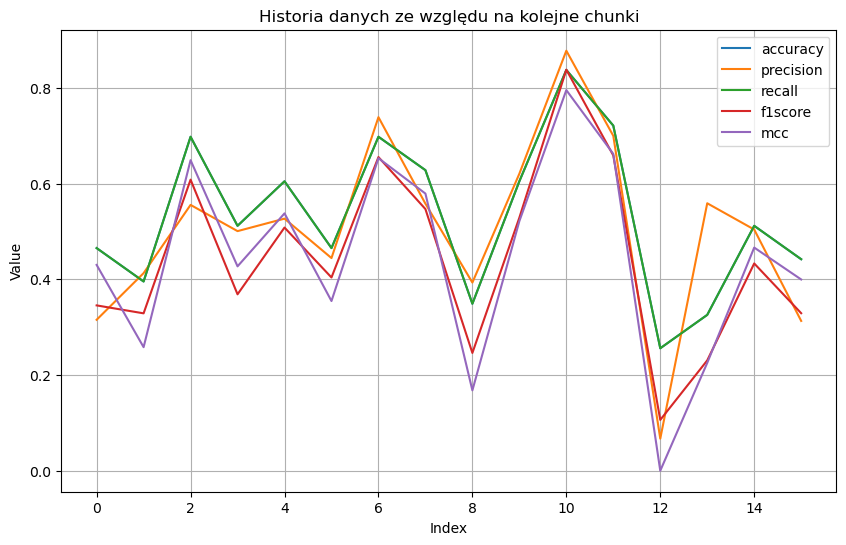

Historia danych wewnatrz iteracji dla pierwszego chunka


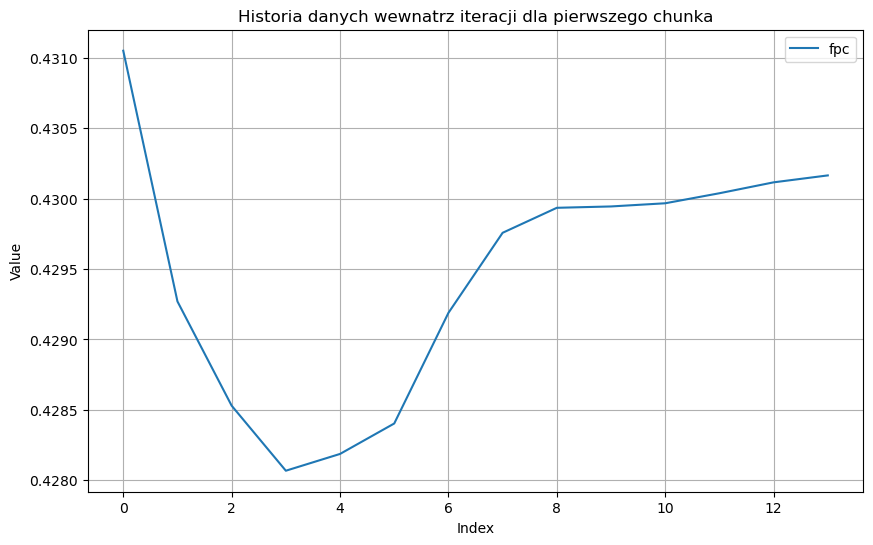

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


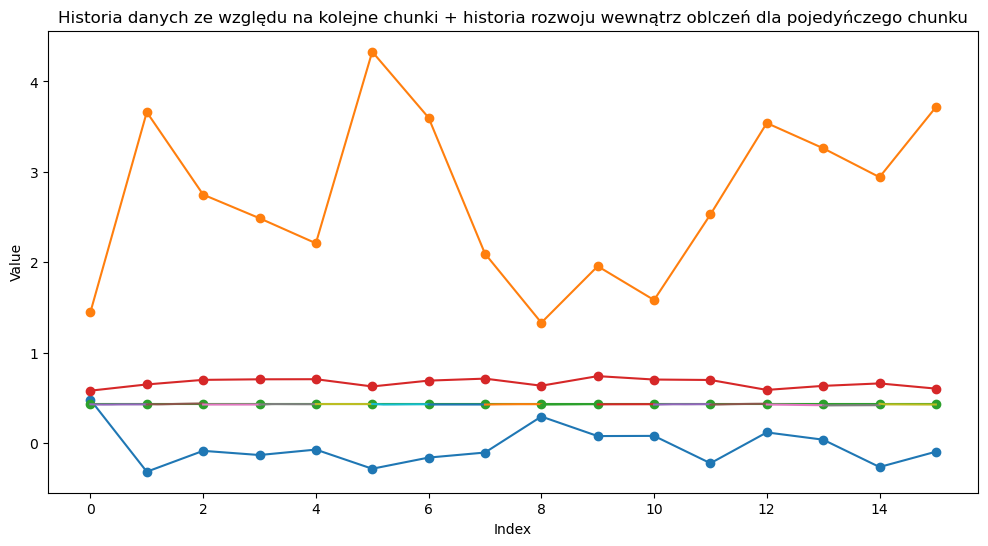

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


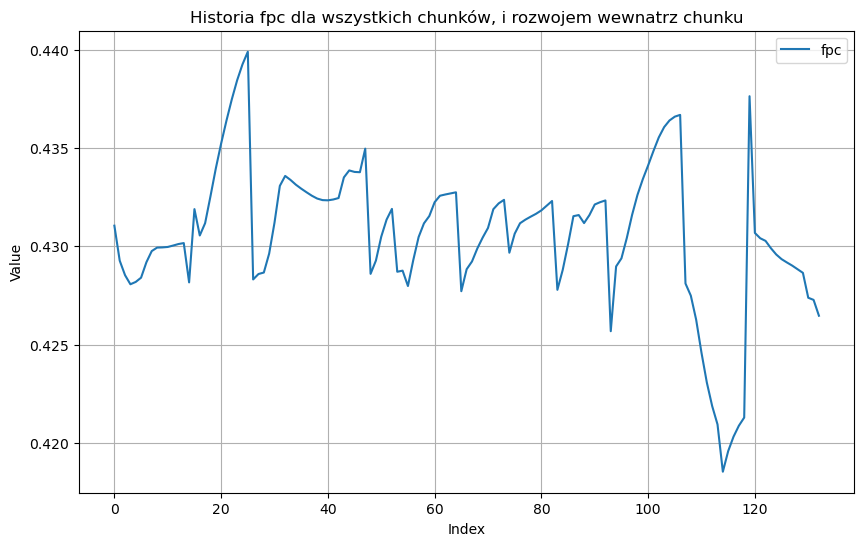

Historia centroidów ze względu na chunki


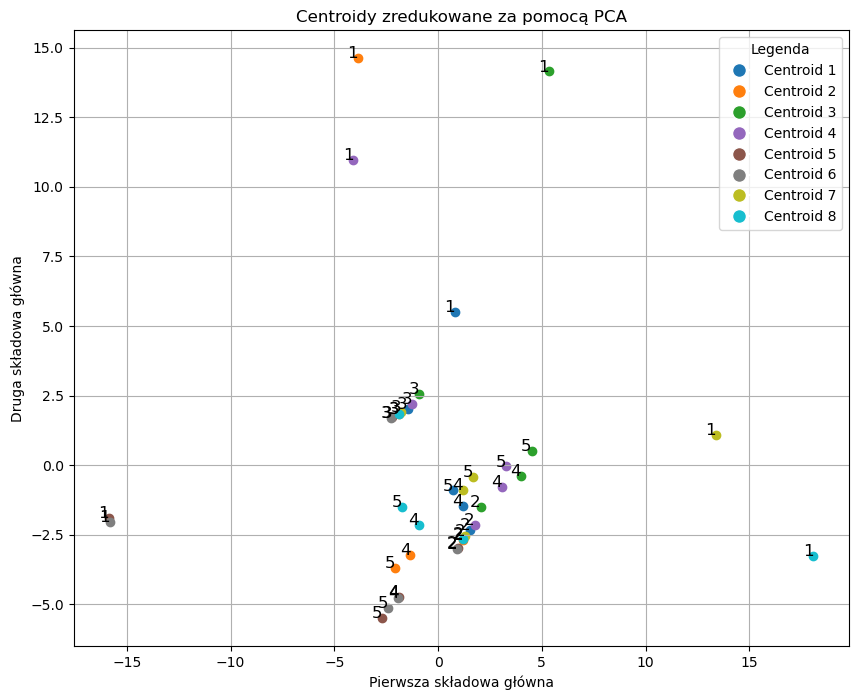

fpc last 0.43071733239368315
rand last 0.6044846211552888
chunk_length_train 300
chunk_length_test 100
n_clusters 8
m 2


In [75]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie ISSFCM tylko wybranych centroidów

8


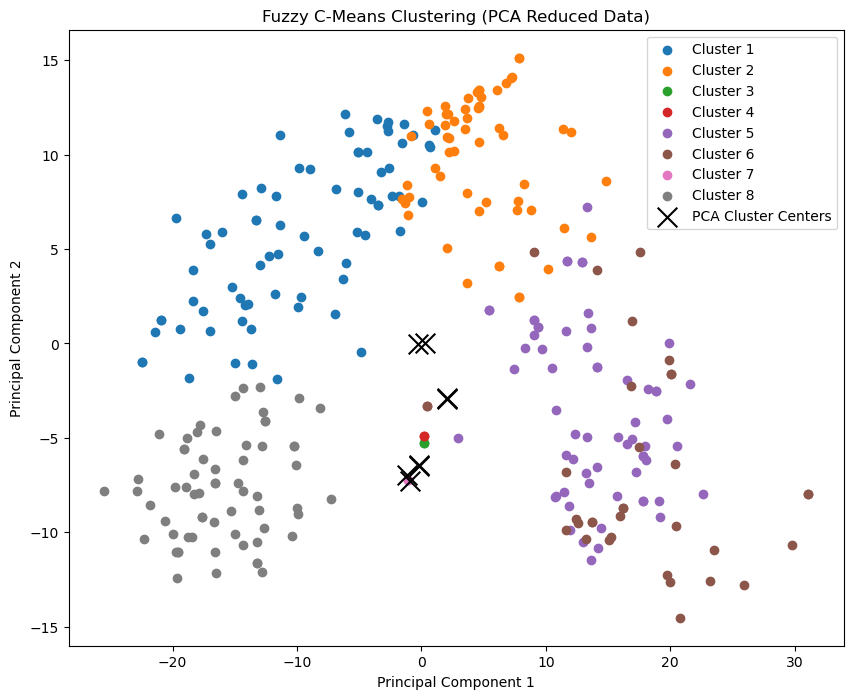

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 0 3 3]
Silhouette Score: 0.012763382375903383
Davies-Bouldin Score: 2.349785743392664
Rand Score: 0.7093150787696925
Tested fpc: 0.43071733239368315
Accuracy: 0.4883720930232558
Precision:  0.5138486213065203
Recall:  0.4883720930232558
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:   6%|██▍                                    | 1/16 [00:00<?, ?it/s]

8


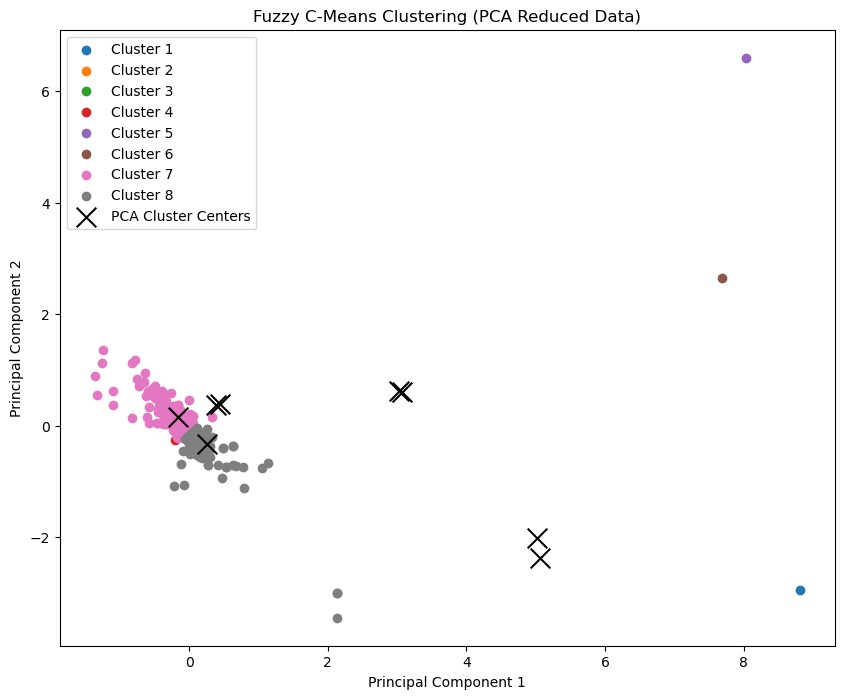

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 0 3 1]
Silhouette Score: 0.03878968284288587
Davies-Bouldin Score: 2.3123570921060583
Rand Score: 0.7139801200300075
Tested fpc: 0.43071733239368315
Accuracy: 0.6976744186046512
Precision:  0.5443269908386188
Recall:  0.6976744186046512
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  12%|████▉                                  | 2/16 [00:00<?, ?it/s]

8


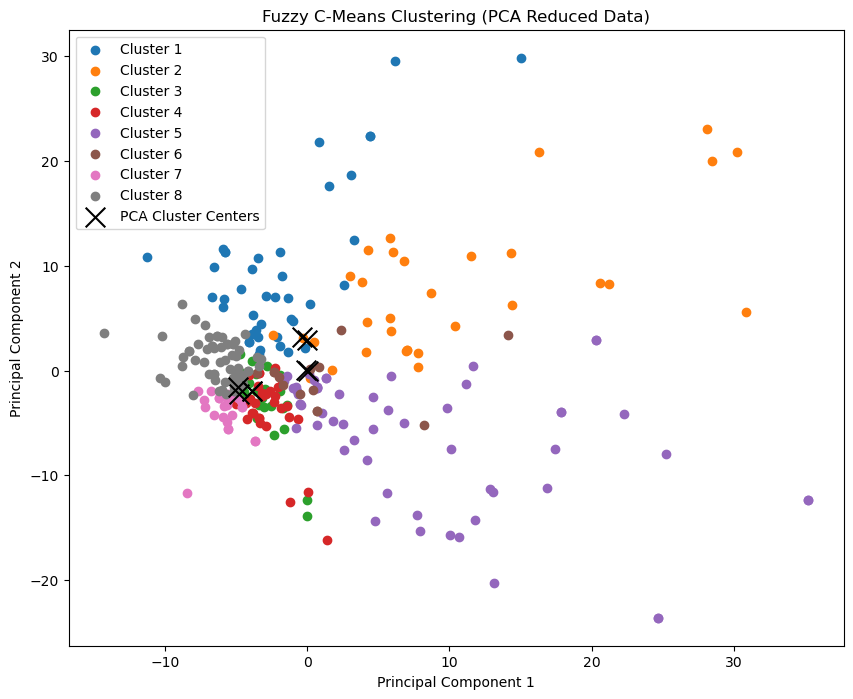

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 1]
Silhouette Score: 0.06018530509266891
Davies-Bouldin Score: 1.7788599852765783
Rand Score: 0.716057264316079
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5661357566282327
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  19%|███████▎                               | 3/16 [00:00<?, ?it/s]

8


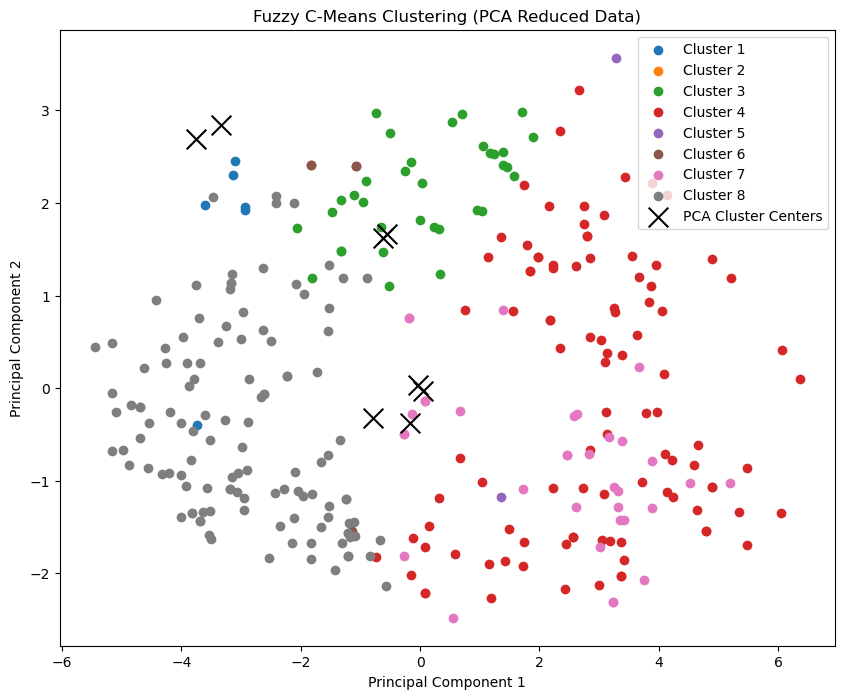

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 1]
Silhouette Score: 0.02623060615185973
Davies-Bouldin Score: 1.5290939538539554
Rand Score: 0.7220172543135784
Tested fpc: 0.43071733239368315
Accuracy: 0.7209302325581395
Precision:  0.5595518312776575
Recall:  0.7209302325581395
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 4/16 [00:00<?, ?it/s]

8


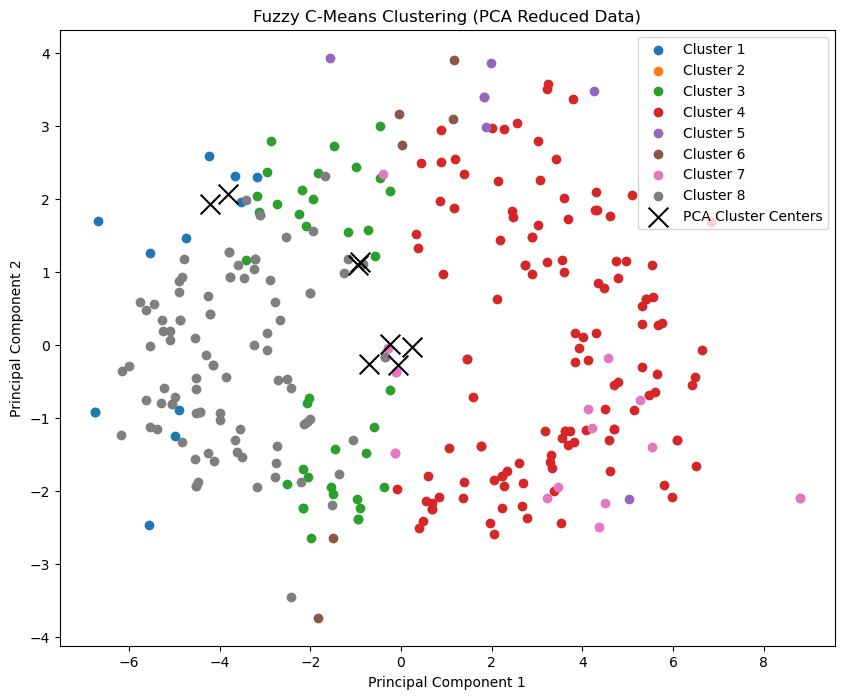

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 1]
Silhouette Score: 0.018017545157305467
Davies-Bouldin Score: 1.5595908247662233
Rand Score: 0.7281056514128532
Tested fpc: 0.43071733239368315
Accuracy: 0.7209302325581395
Precision:  0.5654686398872445
Recall:  0.7209302325581395
Rozważamy obecnie chunk numer:  4
Liczba klastrów:  8


Processing:  31%|████████████▏                          | 5/16 [00:00<?, ?it/s]


8


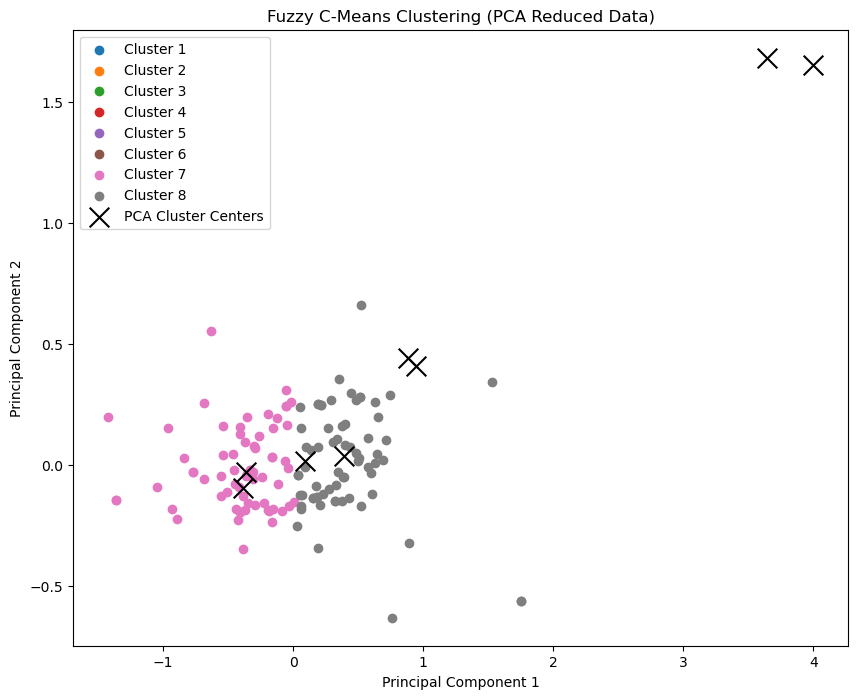

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: -0.0030228409670584318
Davies-Bouldin Score: 1.6564600372414406
Rand Score: 0.710122655663916
Tested fpc: 0.43071733239368315
Accuracy: 0.5813953488372093
Precision:  0.4914281454979129
Recall:  0.5813953488372093
Rozważamy obecnie chunk numer:  5
Liczba klastrów:  8


Processing:  38%|██████████████▋                        | 6/16 [00:00<?, ?it/s]

8


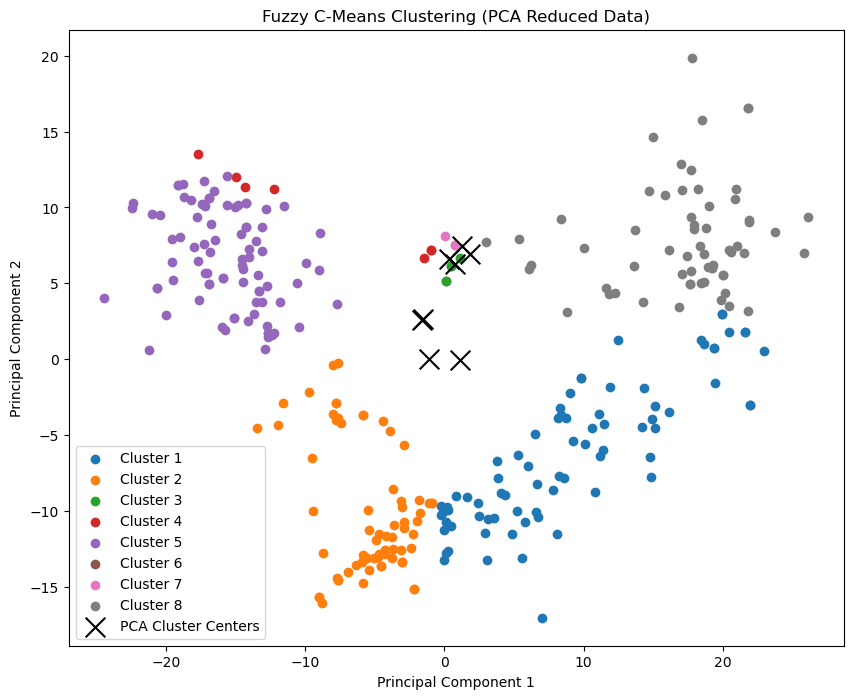

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: -0.0016966801225417507
Davies-Bouldin Score: 1.6601473179326351
Rand Score: 0.7118417104276069
Tested fpc: 0.43071733239368315
Accuracy: 0.6046511627906976
Precision:  0.5016370552265396
Recall:  0.6046511627906976
Rozważamy obecnie chunk numer:  6
Liczba klastrów:  8


Processing:  44%|█████████████████                      | 7/16 [00:00<?, ?it/s]

8


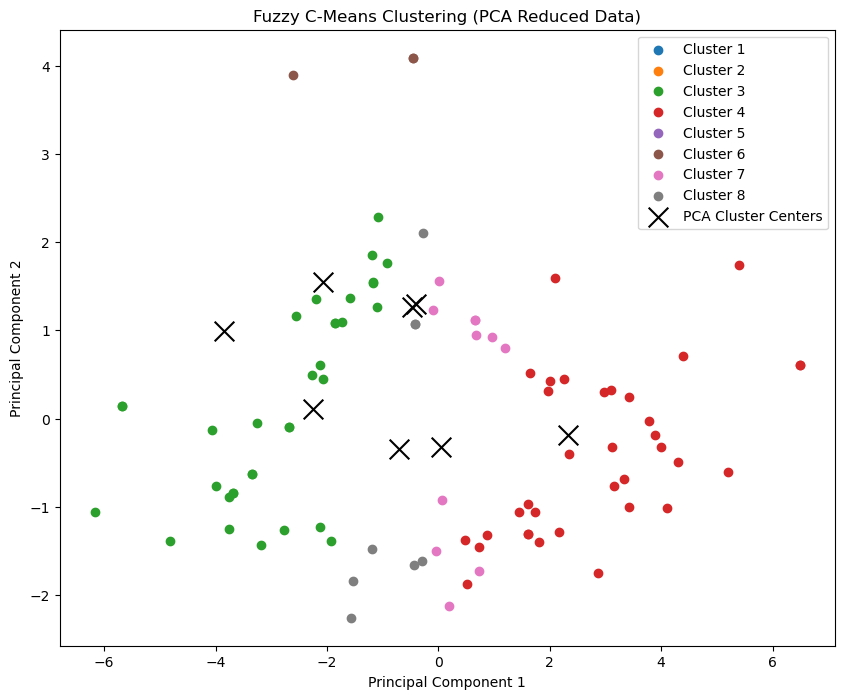

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: -0.05769222890907319
Davies-Bouldin Score: 1.8221884957775818
Rand Score: 0.7288289572393098
Tested fpc: 0.43071733239368315
Accuracy: 0.6976744186046512
Precision:  0.5769230769230769
Recall:  0.6976744186046512
Rozważamy obecnie chunk numer:  7
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 8/16 [00:00<?, ?it/s]

8


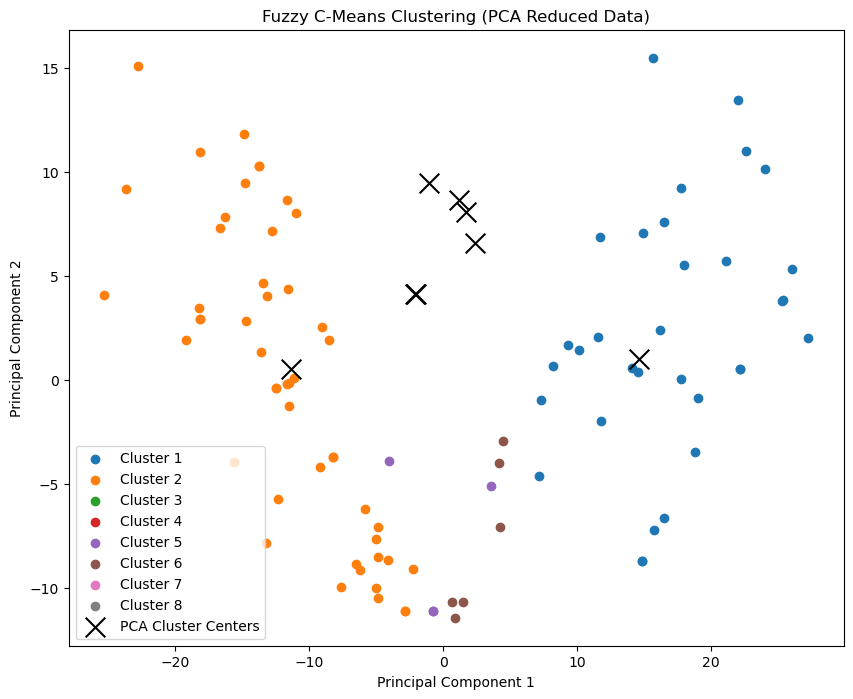

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 2 2 3 3]
Silhouette Score: 0.007584587017481571
Davies-Bouldin Score: 2.0957673122092513
Rand Score: 0.7604414853713428
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5897137745974956
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  8
Liczba klastrów:  8


Processing:  56%|█████████████████████▉                 | 9/16 [00:00<?, ?it/s]

8


C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 2 2 3 3]
Silhouette Score: 0.010266437522219207
Davies-Bouldin Score: 2.119469494624964
Rand Score: 0.7586146536634158
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5897137745974956
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  9
Liczba klastrów:  8


Processing:  62%|███████████████████████▊              | 10/16 [00:00<?, ?it/s]

8


C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: 0.029457512128836405
Davies-Bouldin Score: 2.0812918053353053
Rand Score: 0.7619839959989998
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5816576324532261
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  10
Liczba klastrów:  8


Processing:  69%|██████████████████████████▏           | 11/16 [00:00<?, ?it/s]

8


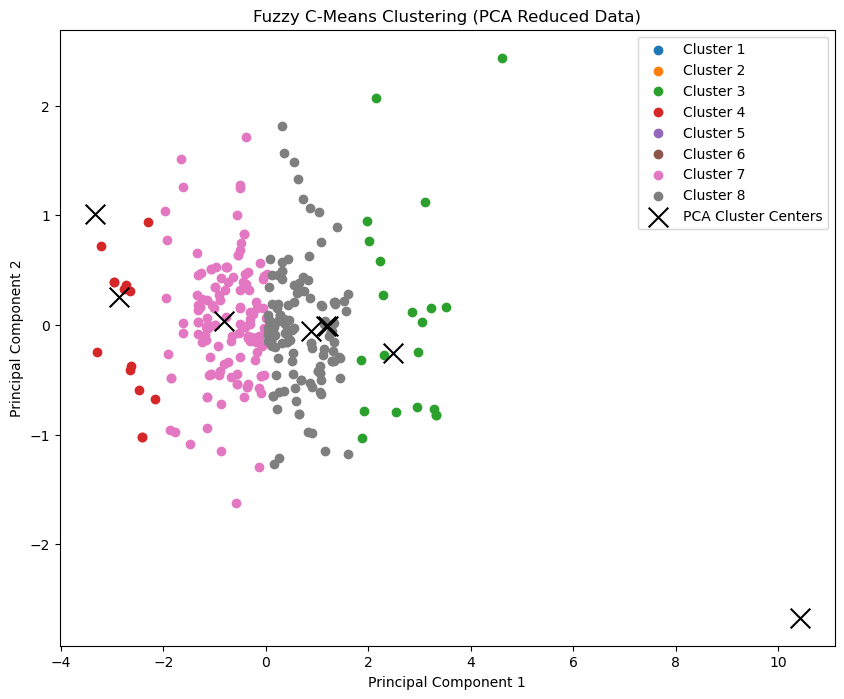

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: 0.04143082539473838
Davies-Bouldin Score: 2.0593521729856126
Rand Score: 0.7587980745186297
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5687439175811269
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  11
Liczba klastrów:  8


Processing:  75%|████████████████████████████▌         | 12/16 [00:00<?, ?it/s]

8


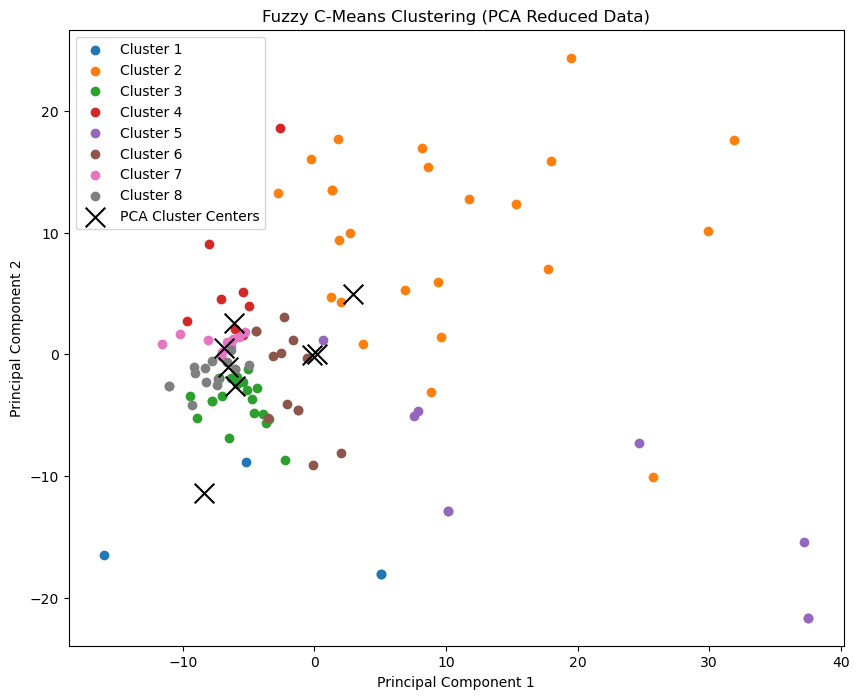

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: 0.058720423387894786
Davies-Bouldin Score: 1.7288202207675318
Rand Score: 0.7587939484871218
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5816576324532261
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  12
Liczba klastrów:  8


Processing:  81%|██████████████████████████████▉       | 13/16 [00:00<?, ?it/s]

8


C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: 0.04636518556989545
Davies-Bouldin Score: 1.7366784783126565
Rand Score: 0.7608374593648413
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5687439175811269
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  13
Liczba klastrów:  8


Processing:  88%|█████████████████████████████████▎    | 14/16 [00:00<?, ?it/s]

8


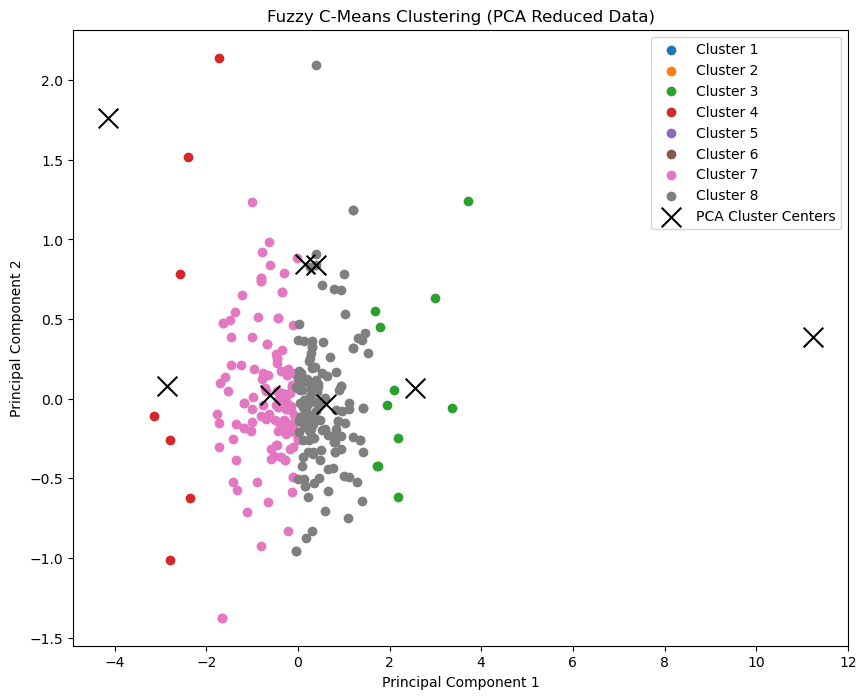

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: 0.04735523623591591
Davies-Bouldin Score: 1.7543874323016524
Rand Score: 0.7615305076269068
Tested fpc: 0.43071733239368315
Accuracy: 0.7441860465116279
Precision:  0.5897137745974956
Recall:  0.7441860465116279
Rozważamy obecnie chunk numer:  14
Liczba klastrów:  8


Processing:  94%|███████████████████████████████████▋  | 15/16 [00:00<?, ?it/s]

8


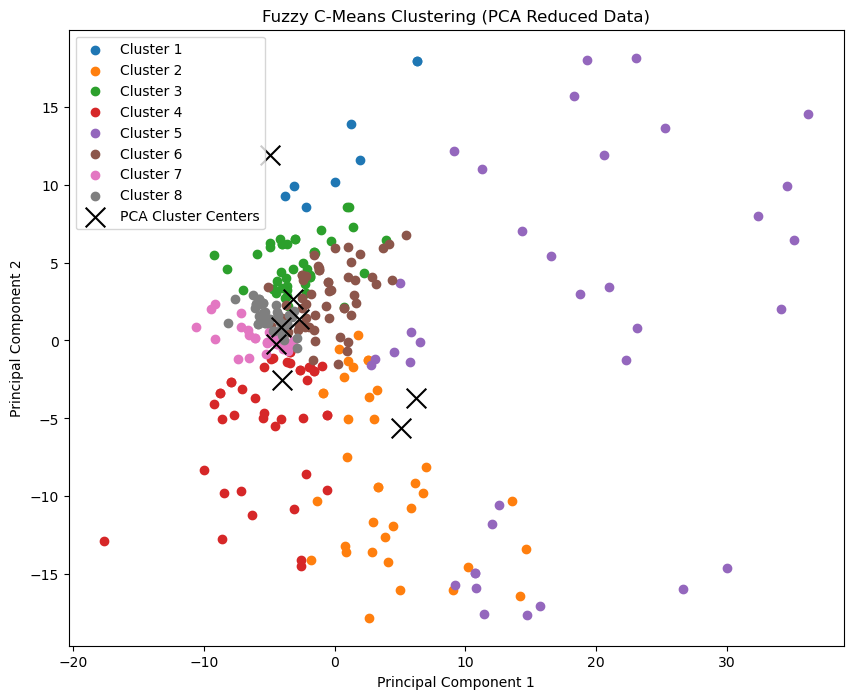

przynalznosc clustra do klasy [0 0 1 1 0 2 3 3]
Silhouette Score: 0.054405402265453366
Davies-Bouldin Score: 1.6313297899232546
Rand Score: 0.7640146286571643
Tested fpc: 0.43071733239368315
Accuracy: 0.8604651162790697
Precision:  0.8924269528920692
Recall:  0.8604651162790697
Rozważamy obecnie chunk numer:  15
Liczba klastrów:  8


Processing: 100%|██████████████████████████████████████| 16/16 [00:00<?, ?it/s]

8


Cluster 0: counts = 412, summed_labels = 251.5945532810897
Cluster 1: counts = 416, summed_labels = 254.99461362614247
Cluster 2: counts = 548, summed_labels = 542.5734198972132
Cluster 3: counts = 528, summed_labels = 480.02054439544406
Cluster 4: counts = 349, summed_labels = 241.5650202184611
Cluster 5: counts = 402, summed_labels = 505.79160743381317
Cluster 6: counts = 627, summed_labels = 825.1751971291711
Cluster 7: counts = 718, summed_labels = 898.28504401866


In [76]:
diagnosis_chunk, diagnosis_iterations = train_local_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_matrix, chunks_y, chunks_test, chunks_test_y, visualise_data=True)

Historia danych ze względu na kolejne chunki


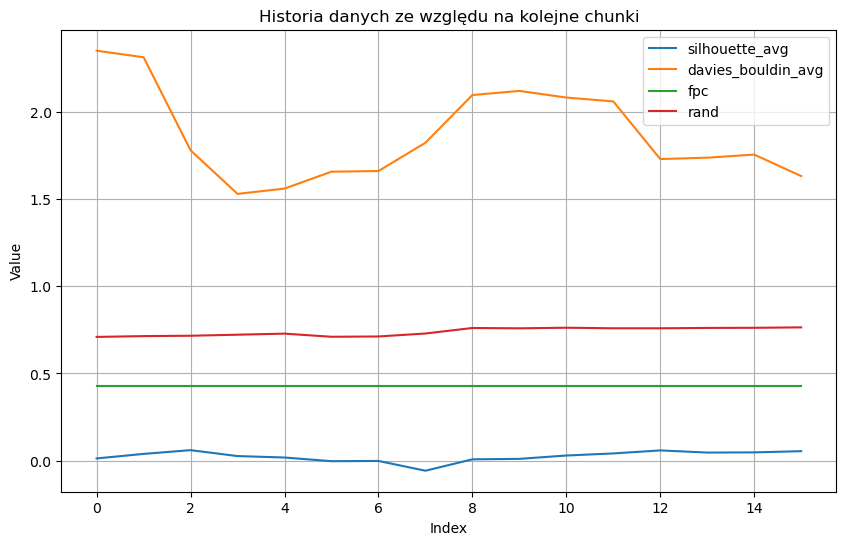

Historia statystyk ze względu na kolejne chunki


Historia danych wewnatrz iteracji dla pierwszego chunka


Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


Historia centroidów ze względu na chunki


fpc last 0.43071733239368315
rand last 0.7640146286571643
chunk_length_train 300
chunk_length_test 100
n_clusters 8
m 2


In [77]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

In [78]:
def find_optimal_number_of_clusters_issfcm(range_ = range(n_clusters,16)):
    output_data_chunk = []
    output_data_iter = []
    
    for n in range_:
        print('Rozważam: ', n)
        y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n)
        _, _, chunks_y_matrix = create_dataset_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
        diagnosis_tools, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n, chunks, chunks_y_matrix, chunks_test, chunks_test_y, init_centroids=init_centroids)
        output_data_chunk.append(diagnosis_tools)
        output_data_iter.append(diagnosis_iterations)
    
    plot_statistic = DiagnosisTools()
    
    for n in range_:
        sil, dave, fpc, rand = output_data_chunk[n-n_clusters].get_avg()
        plot_statistic.add_elements(sil, dave, fpc, rand)
        
    plot_statistic.plot_lists()

    return plot_statistics

In [79]:
#find_optimal_number_of_clusters_issfcm()

# Klasyfikacja

In [51]:
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial.distance import cdist

from collections import Counter
import numpy as np

from libraries.IFCM import create_labels as create_labels_simple
from scipy import stats

def assign_clusters_to_classes(fuzzy_labels, centroids, y, n_classes):
    # Zliczam pierwsze punkty do jakich klas należą, następnie dopiero patrzę na segmenty.
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    count_points = np.zeros((centroids.shape[0], n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


def assign_class_to_points(fuzzy_labels, cluster_to_class):
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    result = np.zeros(len(cluster_membership), dtype=fuzzy_labels.dtype)

    result[:] = cluster_to_class[cluster_membership]
    return result


def classify_points(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    fuzzy_labels_trained = create_labels(trained_x, centroids, metric, m)
    
    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)
    
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    fuzzy_labels_val = create_labels(validation_x, validation_y.T ,centroids, metric, m)

    validation_classified = None
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    if classify_whole_segment:
        validation_classified = []

        for chunk in validation_x_chunked:
            fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
            chunk_classified = assign_class_to_points(fuzzy_labels_chunk, cluster_to_class)
            mode_value, count = stats.mode(chunk_classified)
            
            validation_classified.append(np.full(chunk_classified.shape, mode_value))
        validation_classified = np.concatenate(validation_classified)  
    else:
        validation_classified = assign_class_to_points(fuzzy_labels_val, cluster_to_class)
    
    return validation_classified
    

def majority_vote_with_elimination(class_vectors, n_classes):
    """
    Przeprowadza głosowanie większościowe z eliminacją najmniej popularnych klas.
    
    Args:
    class_vectors (list of list): Lista wektorów indeksów klas uporządkowanych według przynależności
                                  dla każdego punktu walidacyjnego.
    
    Returns:
    int: Ostateczna wybrana klasa po głosowaniu.
    """
    counter = 0
    #print(class_vectors)
    mark_deletion = np.zeros(n_classes)
    while True:
        # Zliczanie pierwszych klas (najbardziej przynależnych) dla wszystkich punktów
        first_choices = [classes[0] for classes in class_vectors if classes.size > 0]
        class_counter = Counter(first_choices)
        #print("class_vectors", class_vectors)
        #print("first_choices", first_choices)
        #return first_choices

        #print("tura: ", counter)    
        #print("first_choices: ", first_choices)
        #print("class_counter: ", class_counter)
        #return first_choices
        # Sprawdzenie, czy mamy jedną dominującą klasę
        if len(class_counter) == 1:
            return first_choices  # Zwróć dominującą klasę
        
        # Znajdź najmniej popularną klasę (lub klasy, jeśli są remisowe)
        min_count = min(class_counter.values())
        least_common_classes = [cls for cls, count in class_counter.items() if count == min_count]

        # Dla każdej klasy do usunięcia
        for cls_to_remove in least_common_classes:
            mark_deletion[cls_to_remove] = 1
            #print("Klasa do usuniecia: ", cls_to_remove)
            # Przejdź przez każdy punkt walidacyjny
            for i, classes in enumerate(class_vectors):
                # Jeśli pierwsza klasa jest tą do usunięcia, usuń ją
                if classes.size > 0 and mark_deletion[classes[0]] == 1:
                    #print("Usuwam: ", classes[0])
                    class_vectors[i] = np.delete(classes, 0)

        # Sprawdź, czy wszystkie wektory klas zostały wyeliminowane
        if all(classes.size == 1 for classes in class_vectors):
            return first_choices  # Zwróć None, jeśli wszystkie klasy zostały wyeliminowane

        if counter >= 3:
            # Zwróć pierwszą klasę, która pozostała na końcu eliminacji
            return first_choices
        
        counter += 1
def classify_with_knn_eliminate_minor(train_matrix, val_matrix, k, prototype_to_class ,n_classes, centroids):
    """
    Klasyfikuje dane walidacyjne na podstawie k najbliższych sąsiadów z użyciem macierzy przynależności.
    
    Args:
    val_matrix (numpy.ndarray): Macierz przynależności danych walidacyjnych, rozmiar [n_val x K].
    train_matrix (numpy.ndarray): Macierz przynależności danych treningowych, rozmiar [n_train x K].
    k (int): Liczba najbliższych sąsiadów do znalezienia.
    prototype_to_class (list): Lista mapująca każdy prototyp na odpowiednią klasę.
    
    Returns:
    list: Lista sklasyfikowanych klas dla każdej serii czasowej z walidacji.
    """

    n_val = val_matrix.shape[1]
    n_train = train_matrix.shape[1]
    
    classified_labels = []
    
    for i in range(n_val):
        val_series = val_matrix[:, i]
        #print("val_series ", val_series)
        # Oblicz odległość euklidesową między i-tym rzędem w val_matrix a każdym rzędem w train_matrix
        v_expanded = val_series[:, np.newaxis]  # Kształt: (8, 1)

        # Oblicz różnicę pomiędzy punktami a wektorem
        diff = train_matrix - v_expanded
        
        # Oblicz dystans Euklidesowy
        distances = np.sqrt(np.sum(diff**2, axis=0))
        
        # Znajdź indeksy k najmniejszych wartości (najbliższych sąsiadów)
        k_nearest_indices = np.argsort(distances)[:k]
        
        class_to_max_prototype = np.zeros(n_classes)
        
        distances = np.linalg.norm(centroids - v_expanded, axis=1)
        # for idx in k_nearest_indices:
        #     # Sortuj prototypy według wartości przynależności malejąco dla danego sąsiada
        #     sorted_prototypes = np.argsort(train_matrix[:, idx])[::-1]
        sorted_prototypes = np.argsort(val_series)[::-1]
    
        for prototype_idx in sorted_prototypes:
                # Mapuj prototyp na odpowiednią klasę
                mapped_class = prototype_to_class[prototype_idx]
                
                # Jeśli klasa nie była jeszcze dodana lub obecny prototyp ma większą przynależność, zaktualizuj
                if class_to_max_prototype[mapped_class] == 0 or class_to_max_prototype[mapped_class] < val_series[prototype_idx]:
                    class_to_max_prototype[mapped_class] = val_series[prototype_idx]
                else:
                    break  # Ponieważ sortowanie jest malejące, dalsze prototypy będą miały mniejszą przynależność
        
        sorted_class_indices = np.argsort(class_to_max_prototype)[::-1]  
        # Uzyskaj indeksy centroidów posortowane według odległości
        #print("val_series ", sorted_class_indices)

        # sorted_indices = np.argsort(val_series)
        # # for idx in k_nearest_indices:
        # #     # Sortuj prototypy według wartości przynależności malejąco dla danego sąsiada
        # #     sorted_prototypes = np.argsort(train_matrix[:, idx])[::-1]
            
        # for prototype_idx in sorted_indices:
        #         # Mapuj prototyp na odpowiednią klasę
        #         mapped_class = prototype_to_class[prototype_idx]
                
        #         # Jeśli klasa nie była jeszcze dodana lub obecny prototyp ma większą przynależność, zaktualizuj
        #         if class_to_max_prototype[mapped_class] == 0 or class_to_max_prototype[mapped_class] < val_series[prototype_idx]:
        #             class_to_max_prototype[mapped_class] = val_series[prototype_idx]
        #         else:
        #             break  # Ponieważ sortowanie jest malejące, dalsze prototypy będą miały mniejszą przynależność
        
        #sorted_class_indices = np.argsort(class_to_max_prototype)[::-1]       
        # Zlicz klasy k najbliższych sąsiadów
        #class_counter = Counter(k_nearest_classes)
        
        # # Zwróć klasy uporządkowane od najczęstszej do najmniej częstej
        # sorted_classes = [cls for cls, count in class_counter.most_common()]
        #print("sorted_class_indices")
        #print(sorted_class_indices)
        classified_labels.append(sorted_class_indices)
    
    # Przeprowadź głosowanie większościowe z eliminacją
    final_class = majority_vote_with_elimination(classified_labels, n_classes)
    
    return final_class


def classify_points_knn_eliminate_minor_class(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None, validation_y_chunked = None, clusters_for_each_class = None, f_t = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    
    #fuzzy_labels_trained = create_labels(trained_x, trained_y.T, centroids, metric, m)
    _, fuzzy_labels_trained = predict_data_dissfcm(trained_x, centroids)
    if f_t is not None:
        fuzzy_labels_trained = f_t
    # przynależność klastrów do klas
    #cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)
    max_cluster = len(centroids)
    
    # # Inicjalizacja tablicy, gdzie pod indeksem klastra będzie klasa
    cluster_to_class = np.full(max_cluster, -1)  # Inicjalizujemy wartości np. -1 dla niezdefiniowanych
    
    for class_idx, cluster_range in clusters_for_each_class.items():
        for cluster in cluster_range:
            cluster_to_class[cluster] = class_idx
    k = 7
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    #fuzzy_labels_val = create_labels_simple(validation_x ,centroids, metric, m)
    _, fuzzy_labels_val = predict_data_dissfcm(validation_x, centroids)


    validation_classified = None
    validation_classified_chunks_before_voting = []
    validation_classified_chunks_majority = []
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    #if classify_whole_segment:
    validation_classified_chunks_majority = []

    itr = 0
    #print("fuzzy_labels_val: ", fuzzy_labels_val)
    for chunk in validation_x_chunked:
        _, fuzzy_labels_chunk = predict_data_dissfcm(chunk, centroids)
        #print("fuzzy_labels_chunk: ", fuzzy_labels_chunk)

        chunk_classified = classify_with_knn_eliminate_minor(fuzzy_labels_trained, fuzzy_labels_chunk, k, cluster_to_class, n_classes, centroids)  
        #print("wynik glosowania")
        #print(chunk_classified)
        if chunk_classified is not None:
            mode_value, count = stats.mode(chunk_classified)
            
            #print("chunk_classified: ",chunk_classified)  
            majority = np.full(len(chunk_classified), mode_value)
                
            validation_classified_chunks_majority.append(majority)
            validation_classified_chunks_before_voting.append(chunk_classified)
            
    validation_classified = np.concatenate(validation_classified_chunks_majority)  
    #validation_classified_chunks_before_voting = np.concatenate(validation_classified_chunks_before_voting)  
    #else:
    #    validation_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_val, k ,cluster_to_class, n_classes)
    return validation_classified, validation_classified_chunks_before_voting, validation_classified_chunks_majority, cluster_to_class ,fuzzy_labels_val
    


# GUI

In [51]:
import tkinter as tk
from tkinter import ttk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# from tkinterweb import HtmlFrame
import plotly.graph_objects as go
from libraries.IFCM import create_labels
import mplcursors

class Controller(object):
    pass

ifcm_caller = Controller()
ifcm_caller.centroids = None
ifcm_caller.itr = 0
ifcm_caller.diagnosis_tools = DiagnosisTools()
ifcm_caller.diagnosis_iterations = []
ifcm_caller.dimensions = chunks[0].shape[1]
ifcm_caller.picked_dim = 0
ifcm_caller.validation_x = np.concatenate(chunks_test) 
ifcm_caller.validation_y = np.concatenate(chunks_test_y) 
ifcm_caller.current_plot = 1 
ifcm_caller.classify_chunks = False 
ifcm_caller.val_y_predicted = None 
ifcm_caller.val_y_predicted_before_vote = None 
ifcm_caller.diffrent_indices = None 
ifcm_caller.cluster_to_class = None 
ifcm_caller.fuzzy_labels_val = None 

def plot_pca_validation(validation_x, validation_y, centroids, n_classes, color_option, fuzzy_labels_val ,whole_data=None, centroids_to_class=None):
    # Rzutowanie danych na dwuwymiarową przestrzeń za pomocą PCA
    #print("fuzzy_labels_val.shape[1]", fuzzy_labels_val.shape[1])
    #print("validation_y.len", len(validation_y))
    pca = PCA(n_components=2)
    print(fuzzy_labels_val[:,0])
    #print("dlugosc ",len(fuzzy_labels_val[:,0]))

    if whole_data is not None:
        pca.fit(whole_data)  # Dopasowanie PCA do całego zbioru danych
    else:
        pca.fit(validation_x)  # Dopasowanie PCA tylko do zbioru walidacyjnego
    
    reduced_data = pca.transform(validation_x)  # Transformacja zbioru walidacyjnego
    reduced_centroids = pca.transform(centroids)  # Transformacja centroidów
    
    for widget in plot_frame.winfo_children():
        widget.destroy()
    
    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Kolory do rysowania danych dla każdej klasy
    colors = plt.cm.get_cmap('viridis', n_classes)
    
    # Lista do przechowywania scatter plotów
    scatter_plots = []
    description = []
    # Rysowanie danych dla każdej klasy osobno
    for class_idx in range(n_classes):
        class_mask = validation_y == class_idx
        #print(fuzzy_labels_val[:, class_mask])
        for i in range(fuzzy_labels_val.shape[1]):
            if class_mask[i]:  # Sprawdzamy, czy maska dla tego indeksu jest prawdziwa
                #for value in fuzzy_labels_val[:, i]:
                description.append(fuzzy_labels_val[:, i])

        scatter = ax.scatter(reduced_data[class_mask, 0], reduced_data[class_mask, 1], 
                   color=colors(class_idx), label=f'Klasa {class_idx}')
        scatter_plots.append(scatter)
    
    # Rysowanie centroidów z kolorowaniem według przypisanej klasy i czarnym obramowaniem
    if centroids_to_class is not None:
        for idx, (centroid, class_idx) in enumerate(zip(reduced_centroids, centroids_to_class)):
            ax.scatter(centroid[0], centroid[1], 
                       color=colors(class_idx), edgecolor='black', 
                       marker='o', s=200, linewidths=2, label=f'Centroid {idx} (Klasa {class_idx})')
    
    # Dodanie legendy
    ax.legend()
    
    # Dodanie tytułu i etykiet osi
    ax.set_title(f'PCA - {color_option}')
    ax.set_xlabel('Pierwsza składowa PCA')
    ax.set_ylabel('Druga składowa PCA')
    
    # Użycie mplcursors do dodania interaktywnych etykiet
    # def hover_label(sel):
    #     sel.annotation.set_text(f'przyanleznosci: {description[sel.index]}')
    #print("--------------------aaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
    #print(description[3])    
    def hover_label(sel):
        text = ''
        #for i in description[sel.index]:
        print(description[sel.index])
        k = 0
        for i in description[sel.index]:
            text += (f"u do centorida {k} wynosi: {i:.3f}\n")
            k += 1
        sel.annotation.set_text(text)
           
    mplcursors.cursor(scatter_plots, hover=True).connect("add", hover_label)
    
    # Wyświetlanie wykresu w tkinter
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()


def update_number():
    number_label.config(text=f"Liczba iteracji: {ifcm_caller.itr} / {len(chunks)}")

def process_iteration(root, plot_frame):
    if ifcm_caller.itr < len(chunks):
        silhouette_avg, davies_bouldin_avg, fpc_test, rand, new_centroids, fuzzy_labels, statistics = run_algorithm(n_clusters, chunks, chunks_test, chunks_test_y, False, plot_tsne, 'euclidean',  ifcm_caller.centroids, ifcm_caller.itr)
        
        # ifcm_caller.diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        # ifcm_caller.diagnosis_tools.add_centroids(new_centroids)
        # ifcm_caller.diagnosis_iterations.append(statistics)

        ifcm_caller.centroids = new_centroids
        ifcm_caller.itr =  ifcm_caller.itr + 1
        
        trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
        trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
        
        n_classess =  len(np.unique(ifcm_caller.validation_y))
        #print("y: ",len(ifcm_caller.validation_y))
        #print(ifcm_caller.validation_x.shape)
       
        validation_y_predicted, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val = classify_points_knn_eliminate_minor_class(trained_x, trained_y, ifcm_caller.validation_x, ifcm_caller.validation_y, new_centroids, 'euclidean', m, n_classess, ifcm_caller.classify_chunks, chunks_test)

        confusion_matrix_val = confusion_matrix(ifcm_caller.validation_y, validation_y_predicted)
        print("macierz pomylek")
        print(confusion_matrix_val)
        
        ifcm_caller.cluster_to_class = cluster_to_class 
        ifcm_caller.cluster_to_class = cluster_to_class 
        
        ifcm_caller.fuzzy_labels_val = fuzzy_labels_val 
        #print("dlugosc predykcji",len(validation_y_predicted))
        ifcm_caller.val_y_predicted = validation_y_chunked 
        ifcm_caller.val_y_predicted_before_vote = validation_y_before_major 

        
        rozne_indeksy = [i for i in range(len(validation_y_chunked)) if not np.array_equal(validation_y_chunked[i], chunks_test_y[i])]
        ifcm_caller.diffrent_indices = rozne_indeksy
        
        if len(rozne_indeksy) > 0:
            print("Indeksy, gdzie tablice są różne:", rozne_indeksy)
            print("-----------------------------------------------------------------")
            for i in rozne_indeksy:
                pass
                #if rozne_indeksy[i] < len(chunks_test_y):
                    #print("prawidłowe", chunks_test_y[i])
                    #print("preydykcje", validation_y_chunked[i])
                    #print("preydykcje przed glosowanie", validation_y_before_major[i])
                    #print("")
        
        statistics = calculate_statistics(ifcm_caller.validation_y, validation_y_predicted)  
        print('Accuracy:' , statistics['Accuracy'])
        print('Precision: ', statistics['Precision'])
        print('Recall: ', statistics['Recall'])
        label.config(
            text=(
                f"Valdiation stats: \n"
                f"acc: {statistics['Accuracy']:.3f}\n"
                f"precision: {statistics['Precision']:.3f}\n"
                f"recall: {statistics['Recall']:.3f}"
            )
        )
        update_number()
        if ifcm_caller.current_plot == 1:
            show_pca(root, plot_frame)
        else:
            show_1_dimension()
    
def show_pca(root, plot_frame):
        data = None
        labels = None
        selected = color_points_option.get()
        n_classes = None
        option = None
        # podział na rodzaj danyh
        if switch_var.get():
            # validation
            data = ifcm_caller.validation_x
            if selected == "Original":
                labels = np.concatenate(chunks_test_y) 
                n_classes = len(np.unique(ifcm_caller.validation_y))
                option = "Orginalne Klasy"
                
            elif selected == "Classify":
                n_classes =  len(np.unique(ifcm_caller.validation_y))
                trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
                trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
                labels, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val   = classify_points_knn_eliminate_minor_class(trained_x, trained_y, ifcm_caller.validation_x, ifcm_caller.validation_y, ifcm_caller.centroids, 'euclidean', m, n_classes, ifcm_caller.classify_chunks, chunks_test)
                option = "Klasyfikacja"
                ifcm_caller.fuzzy_labels_val = fuzzy_labels_val
                #print(np.unique(labels))
            elif selected == "Cluster":
                n_classes = len(ifcm_caller.centroids)
                fuzzy_labels = create_labels(ifcm_caller.validation_x, ifcm_caller.centroids, 'euclidean', m)
                labels = np.argmax(fuzzy_labels, axis=0)
                option = "przynależność do Klastrów"


        else:
            trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
            trained_x_chunks = (chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
            trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
            data = trained_x
            
            if selected == "Original":
                labels = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
                n_classes = len(np.unique(ifcm_caller.validation_y)) 
                option = "Orginalne Klasy"
                
            elif selected == "Classify":
                n_classes =  len(np.unique(ifcm_caller.validation_y))
                labels, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val  = classify_points_knn_eliminate_minor_class(trained_x, trained_y, trained_x, trained_y, ifcm_caller.centroids, 'euclidean', m, n_classes, ifcm_caller.classify_chunks, trained_x_chunks)
                n_classes = len(np.unique(ifcm_caller.validation_y))
                option = "Klasyfikacja"
                
            elif selected == "Cluster":
                fuzzy_labels = create_labels(trained_x, ifcm_caller.centroids, 'euclidean', m)
                labels = np.argmax(fuzzy_labels, axis=0)
                n_classes = len(ifcm_caller.centroids)
                option = "przynależność do Klastrów"
                
        plot_pca_validation(data, labels, ifcm_caller.centroids, n_classes, option, ifcm_caller.fuzzy_labels_val, centroids_to_class = ifcm_caller.cluster_to_class )
        ifcm_caller.current_plot = 1

        

def run_algorithm(n_clusters, chunks, validation_data, validation_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', centroids = None, itr = 0):
    #data = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 0 else chunks[0]
    #y_supervised =  np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 0 else chunks_y[0]
    data = chunks[itr]
    y_supervised = chunks_y[itr]
    if itr == 0:
        centroids = init_centroids

    #centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=centroids)
    current_class = np.bincount(y_supervised).argmax()

        # Wybieramy tylko centroidy do treningu, które łączą się z daną klasą.
    clusters = list(clusters_for_each_class[current_class])
    centroids_local = centroids[clusters]
    
    centroids_local, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids_local)

        # Łączenie wyćwiczone centroidy z starymi
    centroids[clusters] = centroids_local
    #centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)
    #silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, validation_y, m, g_error)
    print(itr)

    return None, None, None, None, centroids, fuzzy_labels , statistics     


def show_mistakes():
        selected_chunks = [chunks_test[i] for i in ifcm_caller.diffrent_indices]
        #fuzzy_labels_val = create_labels(validation_x, centroids, metric, m)

        selected_chunks_fuzzy = [create_labels(chunks_test[k], ifcm_caller.centroids, 'euclidean', m) for k in ifcm_caller.diffrent_indices]
        data = np.concatenate(selected_chunks)
        
        fuzzy_labels_val = np.concatenate(selected_chunks_fuzzy, axis = 1)
        print("fuzzy_labels_val", fuzzy_labels_val.shape)
        labels = None
        selected = color_points_option.get()
        n_classes = None
        option = None
        if selected == "Original":
                selected_chunks = [chunks_test_y[i] for i in ifcm_caller.diffrent_indices]
                labels = np.concatenate(selected_chunks)
                n_classes = len(np.unique(ifcm_caller.validation_y))
                option = "Orginalne Klasy"
                
        elif selected == "Classify":
                n_classes =  len(np.unique(ifcm_caller.validation_y))

            
                trained_x = np.concatenate(chunks[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks[0]
                trained_y = np.concatenate(chunks_y[:ifcm_caller.itr]) if ifcm_caller.itr > 1 else chunks_y[0]
                validation_y_predicted, validation_y_before_major, validation_y_chunked, cluster_to_class, fuzzy_labels_val_notuse = classify_points_knn_eliminate_minor_class(trained_x, trained_y, ifcm_caller.validation_x, ifcm_caller.validation_y, ifcm_caller.centroids, 'euclidean', m, n_classes, ifcm_caller.classify_chunks, chunks_test)
        
            
                selected_chunks = [validation_y_before_major[i] for i in ifcm_caller.diffrent_indices]
                labels = np.concatenate(selected_chunks)
                #labels = np.concatenate(ifcm_caller.val_y_predicted_before_vote[ifcm_caller.diffrent_indices])               
                option = "Klasyfikacja"
                #print(np.unique(labels))
        elif selected == "Cluster":
                n_classes =  len(np.unique(ifcm_caller.validation_y))
                selected_chunks = [ifcm_caller.val_y_predicted_before_vote[i] for i in ifcm_caller.diffrent_indices]
                labels = np.concatenate(selected_chunks)
                #labels = np.concatenate(ifcm_caller.val_y_predicted_before_vote[ifcm_caller.diffrent_indices])               
                option = "Przed glosowaniem wiekszosciowy"
                #print(np.unique(labels))

                
        plot_pca_validation(data, labels, ifcm_caller.centroids, n_classes, option, fuzzy_labels_val, ifcm_caller.validation_x, centroids_to_class = ifcm_caller.cluster_to_class )
        ifcm_caller.current_plot = 1

    
def update_dimensions(event):
    ifcm_caller.picked_dim = int(dimensions_combobox.get())
    print(f"Wybrano wymiar: { ifcm_caller.picked_dim}")
    show_1_dimension()

def on_checkbox_toggle():
    if enable_chunks_classifications.get():
        ifcm_caller.classify_chunks = True 
    else:
        ifcm_caller.classify_chunks = False 
        
    if ifcm_caller.current_plot == 1:
        show_pca(root, plot_frame)
    else:
        show_1_dimension()
        
def toggle():
    if switch_var.get():
        status_label.config(text="Validation")
    else:
        status_label.config(text="Train")
    show_pca(root, plot_frame)
   
# Tworzenie głównego okna
root = tk.Tk()
root.title("Aplikacja z przełącznikiem, przyciskiem i wykresem")

# Tworzenie ramki na przełącznik i przycisk
control_frame = tk.Frame(root)
control_frame.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)  # fill=tk.X rozciąga na szerokość, padx dodaje margines poziomy

plot_frame = tk.Frame(root, width=1000, height=800)  # Ustawienie stałych wymiarów
plot_frame.pack(side=tk.TOP, pady=20, fill=tk.BOTH, expand=True)

# Przełącznik (Checkbox)
var = tk.BooleanVar()

button = ttk.Button(control_frame, text="Show Mistakes",  command=lambda:  show_mistakes())
button.pack(side=tk.LEFT, padx=10)
# Przycisk
button = ttk.Button(control_frame, text="Show PCA",  command=lambda:  show_pca(root, plot_frame))
button.pack(side=tk.LEFT, padx=10)

button = ttk.Button(control_frame, text="Next iteration",  command=lambda:  process_iteration(root, plot_frame))
button.pack(side=tk.LEFT, padx=10)

number_label = ttk.Label(control_frame, text=f"Iteration Count:  {ifcm_caller.itr}", font=("Helvetica", 16))
number_label.pack(pady=20)

# dimensions_combobox = ttk.Combobox(control_frame, values=list(range(0, ifcm_caller.dimensions )), state="readonly")
# dimensions_combobox.set(0)  # Ustawienie domyślnej wartości
# dimensions_combobox.bind("<<ComboboxSelected>>", update_dimensions)
# dimensions_combobox.pack(side=tk.LEFT, padx=10)

enable_chunks_classifications = tk.BooleanVar()

checkbox = ttk.Checkbutton(control_frame, text="Classify whole chunks", variable=enable_chunks_classifications, command=on_checkbox_toggle)
checkbox.pack(side=tk.LEFT, padx=10)

# Zmienna przechowująca stan przełącznika
switch_var = tk.BooleanVar(value=False)

# Tworzenie przełącznika (Checkbutton)
toggle_switch = tk.Checkbutton(control_frame, text="Train data/Validation data", variable=switch_var, command=toggle)
toggle_switch.pack(pady=10)

# Etykieta do wyświetlania stanu przełącznika
status_label = tk.Label(control_frame, text="Train")
status_label.pack(pady=10)

################################################################################################################

                          ##Przełącznik Orignalnych klas \ Klasyfikacji\ Przynależnosci do Centroidów##

#################################################################################################################

def show_selection():
    selected = color_points_option.get()
    print(selected)
    show_pca(root, plot_frame)

# Zmienna przechowująca wybór
color_points_option = tk.StringVar(value="Original")

# Tworzenie przycisków radiowych
tk.Radiobutton(control_frame, text="Original Classes", variable = color_points_option, value="Original", command=show_selection).pack(anchor=tk.W)
tk.Radiobutton(control_frame, text="Classification Classes", variable = color_points_option, value="Classify", command=show_selection).pack(anchor=tk.W)
tk.Radiobutton(control_frame, text="Cluster Membership", variable = color_points_option, value="Cluster", command=show_selection).pack(anchor=tk.W)



################################################################################################################

                          ## Tekst ze statystykami

#################################################################################################################

label = tk.Label(control_frame, text="Valdiation stats: \n acc: \n precision: \n recall: ", font=("Arial", 14))
#label.pack(side=tk.RIGHT, padx=20, pady=20)

label.place(relx=0.9, rely=0.5, anchor='e', x=-10, y=0)  # relx=1.0 ustawia widget na prawo


# Start aplikacji
root.mainloop()


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
np.random.seed(42)
%matplotlib
fig, ax = plt.subplots()
ax.scatter(*np.random.random((2, 26)))
ax.set_title("Mouse over a point")

mplcursors.cursor(hover=True)

plt.show()

Using matplotlib backend: QtAgg
